![project_pdf_1.png](saved_pics/project_pdf_1.png)

![project_pdf_2.png](saved_pics/project_pdf_2.png)

## Nedeed Imports

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import foxes
import foxes.variables as FV
import foxes.constants as FC
import netCDF4 as nc
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import foxes.opt.problems.layout.geom_layouts as grg
from iwopy.interfaces.pymoo import Optimizer_pymoo
from abc import abstractmethod
from foxes.models.wake_models.axisymmetric import AxisymmetricWakeModel

1. Organize all input data, filter, and read them in in a proper way

In [2]:
# Load two netCDF files for Buoys 2 and 6
buoy2 = xr.open_dataset('measurements/2023-11-09_Buoy2_BSH_N-9.nc')
buoy6 = xr.open_dataset('measurements/2023-11-06_Buoy6_BSH_N-9.nc')

# Time
time_buoy2 = buoy2.variables['time']
time_buoy6 = buoy6.variables['time']

print(buoy2)
print()
print(buoy6)

<xarray.Dataset> Size: 541kB
Dimensions:    (longitude: 1, latitude: 1, time: 67680, height: 6)
Coordinates:
  * longitude  (longitude) float32 4B 5.792
  * latitude   (latitude) float32 4B 54.5
  * time       (time) datetime64[ns] 541kB 2022-03-03 ... 2023-06-15T23:49:59...
  * height     (height) int32 24B 14 41 94 140 200 250
Data variables:
    *empty*
Attributes:
    long_name:    Data measured by the sensors mounted on the Fraunhofer IWES...
    description:  BSH N-9 Fraunhofer IWES WLBZ_2 data from the period 2022-03...
    disclaimer:   The use of the data is in the sole responsibility of the user.

<xarray.Dataset> Size: 458kB
Dimensions:    (longitude: 1, latitude: 1, time: 57196, height: 6)
Coordinates:
  * longitude  (longitude) float32 4B 5.521
  * latitude   (latitude) float32 4B 54.4
  * time       (time) datetime64[ns] 458kB 2022-03-03 ... 2023-04-04T04:30:00
  * height     (height) int32 24B 14 42 94 140 200 250
Data variables:
    *empty*
Attributes:
    long_name:   

In [3]:
# Show buoy 2 data
buoy2

<xarray.Dataset> Size: 541kB
Dimensions:    (longitude: 1, latitude: 1, time: 67680, height: 6)
Coordinates:
  * longitude  (longitude) float32 4B 5.792
  * latitude   (latitude) float32 4B 54.5
  * time       (time) datetime64[ns] 541kB 2022-03-03 ... 2023-06-15T23:49:59...
  * height     (height) int32 24B 14 41 94 140 200 250
Data variables:
    *empty*
Attributes:
    long_name:    Data measured by the sensors mounted on the Fraunhofer IWES...
    description:  BSH N-9 Fraunhofer IWES WLBZ_2 data from the period 2022-03...
    disclaimer:   The use of the data is in the sole responsibility of the user.

In [4]:
# Show buoy 6 data
buoy6

<xarray.Dataset> Size: 458kB
Dimensions:    (longitude: 1, latitude: 1, time: 57196, height: 6)
Coordinates:
  * longitude  (longitude) float32 4B 5.521
  * latitude   (latitude) float32 4B 54.4
  * time       (time) datetime64[ns] 458kB 2022-03-03 ... 2023-04-04T04:30:00
  * height     (height) int32 24B 14 42 94 140 200 250
Data variables:
    *empty*
Attributes:
    long_name:    Data measured by the sensors mounted on the Fraunhofer IWES...
    description:  BSH N-9 Fraunhofer IWES WLBZ_6 data from the period 2022-03...
    disclaimer:   The use of the data is in the sole responsibility of the user.

In [5]:
# Load netCDF files for (LiDAR) Floating lidar measurement data from two positions (netCDF-Files)
lidar_data_1 = nc.Dataset('measurements/2023-11-06_Buoy6_BSH_N-9.nc')
lidar_data_2 = nc.Dataset('measurements/2023-11-09_Buoy2_BSH_N-9.nc')


# wind_farm_shapes = gpd.read_file('wind_farm_shapes.shp')

In [6]:
lidar_data_1

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    long_name: Data measured by the sensors mounted on the Fraunhofer IWES WLBZ_6
    description: BSH N-9 Fraunhofer IWES WLBZ_6 data from the period 2022-03-03 00:00:00 UTC to 2023-04-04 04:30:00 UTC.
    disclaimer: The use of the data is in the sole responsibility of the user.
    dimensions(sizes): time(57196), longitude(1), latitude(1), height(6)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), float64 time(time), int32 height(height)
    groups: ZX_LIDAR_WLBZ_6, METEO_WLBZ_6, ADD_DATA_WLBZ_6, ZX_LIDAR_WLBZ_2_MCP, METEO_WLBZ_2_MCP

In [7]:
print(lidar_data_1.groups)

{'ZX_LIDAR_WLBZ_6': <class 'netCDF4._netCDF4.Group'>
group /ZX_LIDAR_WLBZ_6:
    long_name: Wind data measured by ZX1051 on WLBZ_6
    description: The data are availability, count and algorithm flagged. Timestamp indicating the beginning of the aggregation period.
    dimensions(sizes): 
    variables(dimensions): float64 wind_speed(time, latitude, longitude, height), float64 wind_from_direction(time, latitude, longitude, height), float64 wind_from_direction_availability(time, latitude, longitude, height), float64 wind_speed_availability(time, latitude, longitude, height), float64 wind_speed_min(time, latitude, longitude, height), float64 wind_speed_max(time, latitude, longitude, height), float64 wind_speed_stddev(time, latitude, longitude, height), float64 wind_count(time, latitude, longitude, height), float64 turbulence_intensity(time, latitude, longitude, height), float64 algorithm_bitmask(time, latitude, longitude, height)
    groups: , 'METEO_WLBZ_6': <class 'netCDF4._netCDF4.Gro

In [8]:
# Check the groups inside ZX_LIDAR_WLBZ_6
print(lidar_data_1.groups['ZX_LIDAR_WLBZ_6'].variables)

{'wind_speed': <class 'netCDF4._netCDF4.Variable'>
float64 wind_speed(time, latitude, longitude, height)
    units: m/s
    long_name: Wind speed
path = /ZX_LIDAR_WLBZ_6
unlimited dimensions: 
current shape = (57196, 1, 1, 6)
filling on, default _FillValue of 9.969209968386869e+36 used, 'wind_from_direction': <class 'netCDF4._netCDF4.Variable'>
float64 wind_from_direction(time, latitude, longitude, height)
    units: degree
    long_name: Horizontal wind direction
path = /ZX_LIDAR_WLBZ_6
unlimited dimensions: 
current shape = (57196, 1, 1, 6)
filling on, default _FillValue of 9.969209968386869e+36 used, 'wind_from_direction_availability': <class 'netCDF4._netCDF4.Variable'>
float64 wind_from_direction_availability(time, latitude, longitude, height)
    units: percent
    long_name: Availability of the horizontal wind direction
    description: Wind direction availability corresponding to the share of valid motion compensated high-resolution wind data packets versus recorded packets agg

In [9]:
lidar_data_2

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    long_name: Data measured by the sensors mounted on the Fraunhofer IWES WLBZ_2
    description: BSH N-9 Fraunhofer IWES WLBZ_2 data from the period 2022-03-03 00:00:00 UTC to 2023-06-15 23:50:00 UTC.
    disclaimer: The use of the data is in the sole responsibility of the user.
    dimensions(sizes): time(67680), longitude(1), latitude(1), height(6)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), float64 time(time), int32 height(height)
    groups: ZX_LIDAR_WLBZ_2, METEO_WLBZ_2, ADD_DATA_WLBZ_2, ZX_LIDAR_WLBZ_6_MCP, METEO_WLBZ_6_MCP

In [10]:
lidar_data_2.groups

{'ZX_LIDAR_WLBZ_2': <class 'netCDF4._netCDF4.Group'>
 group /ZX_LIDAR_WLBZ_2:
     long_name: Wind data measured by ZX961/ZX740 on WLBZ_2
     description: The data are availability, count and algorithm flagged. Timestamp indicating the beginning of the aggregation period.
     dimensions(sizes): 
     variables(dimensions): float64 wind_speed(time, latitude, longitude, height), float64 wind_from_direction(time, latitude, longitude, height), float64 wind_from_direction_availability(time, latitude, longitude, height), float64 wind_speed_availability(time, latitude, longitude, height), float64 wind_speed_min(time, latitude, longitude, height), float64 wind_speed_max(time, latitude, longitude, height), float64 wind_speed_stddev(time, latitude, longitude, height), float64 wind_count(time, latitude, longitude, height), float64 turbulence_intensity(time, latitude, longitude, height), float64 algorithm_bitmask(time, latitude, longitude, height)
     groups: ,
 'METEO_WLBZ_2': <class 'netCDF4.

In [11]:
# Check the groups inside ZX_LIDAR_WLBZ_2
print(lidar_data_2.groups['ZX_LIDAR_WLBZ_2'].variables)

{'wind_speed': <class 'netCDF4._netCDF4.Variable'>
float64 wind_speed(time, latitude, longitude, height)
    units: m/s
    long_name: Wind speed
path = /ZX_LIDAR_WLBZ_2
unlimited dimensions: 
current shape = (67680, 1, 1, 6)
filling on, default _FillValue of 9.969209968386869e+36 used, 'wind_from_direction': <class 'netCDF4._netCDF4.Variable'>
float64 wind_from_direction(time, latitude, longitude, height)
    units: degree
    long_name: Horizontal wind direction
path = /ZX_LIDAR_WLBZ_2
unlimited dimensions: 
current shape = (67680, 1, 1, 6)
filling on, default _FillValue of 9.969209968386869e+36 used, 'wind_from_direction_availability': <class 'netCDF4._netCDF4.Variable'>
float64 wind_from_direction_availability(time, latitude, longitude, height)
    units: percent
    long_name: Availability of the horizontal wind direction
    description: Wind direction availability corresponding to the share of valid motion compensated high-resolution wind data packets versus recorded packets agg

In [12]:
# We would take [:,0,0,2] @ 94 m height

# windspeed of lidar1 and lidar2
ws_lidar1 = lidar_data_1.groups['ZX_LIDAR_WLBZ_6']['wind_speed'][:,0,0,2]
ws_lidar2 = lidar_data_2.groups['ZX_LIDAR_WLBZ_2']['wind_speed'][:,0,0,2]

# wind direction of lidar1 and lidar2
wd_lidar1 = lidar_data_1.groups['ZX_LIDAR_WLBZ_6']['wind_from_direction'][:,0,0,2]
wd_lidar2 = lidar_data_2.groups['ZX_LIDAR_WLBZ_2']['wind_from_direction'][:,0,0,2]


In [13]:
# Create a DataFrame for the lidar data with the time index from the buoy data for the two lidar positions (lidar1 and lidar2) with the wind speed and wind direction
df_lidar1 = pd.DataFrame(index=time_buoy6, data={'ws': ws_lidar1, 'wd': wd_lidar1})
df_lidar2 = pd.DataFrame(index=time_buoy2, data={'ws': ws_lidar2, 'wd': wd_lidar2})

In [14]:
# Load csv files for Long-term reference model data (ERA5): 1990-2023 (csv-Files)
listEra = []
filelist = glob.glob(f'reanalysis/ERA5*')
for i in filelist:
    listEra.append(pd.read_csv(i,encoding='utf-8',header=0,parse_dates=['Time [UTC]']))  # header 0 because the first row is the header, encoding='utf-8' because the file is in utf-8 format, parse_dates=['Time [UTC]'] because the time column is in datetime format
era5_data = pd.concat(listEra) # Concatenate all the files into one dataframe

# wind speed calculations
era5_data['ws100'] = np.sqrt(era5_data['u100']**2 + era5_data['v100']**2)
era5_data['ws10'] = np.sqrt(era5_data['u10']**2 + era5_data['v10']**2)

# wind direction calculations (in degrees) (from -180 to 180) (0 is north, 90 is east, -90 is west) (meteorological convention)
era5_data['wd100'] = np.mod(360.0+(90.0-np.rad2deg(np.arctan2(-era5_data.v100,-era5_data.u100))),360.0)
era5_data['wd10'] = np.mod(360.0+(90.0-np.rad2deg(np.arctan2(-era5_data.v10,-era5_data.u10))),360.0)
# era5_data['wd100'] = np.arctan2(era5_data['v100'], era5_data['u100']) * 180/np.pi # convert to degrees
# era5_data['wd10'] = np.arctan2(era5_data['v10'], era5_data['u10']) * 180/np.pi # convert to degrees

# make the time column the index
era5_data.set_index('Time [UTC]', inplace=True)


In [15]:
# Geometric turbine coordinates for the areas of interest N-9.1/N-9.2/N-9.3
area_n91 = pd.read_csv('turbine-info/coordinates/area_of_interest/layout-N-9.1.geom.csv')
area_n92 = pd.read_csv('turbine-info/coordinates/area_of_interest/layout-N-9.2.geom.csv')
area_n93 = pd.read_csv('turbine-info/coordinates/area_of_interest/layout-N-9.3.geom.csv')


In [16]:
# Power curves of the turbines
power_curve_IEA_15MW = pd.read_csv('turbine-info/power_curves/IEA-15MW-D240-H150.csv')
power_curve_NREL_5MW = pd.read_csv('turbine-info/power_curves/NREL-5MW-D126-H90.csv')

In [17]:
# Shapefiles of wind farm areas, the countries Denmark, Germany and the Netherlands (mainly for nice plots)

# shape files for DEU
deu = gpd.read_file('shapefiles/DEU/DEU_adm1.shp')
deu

ID_0  ISO   NAME_0  ID_1                  NAME_1 NL_NAME_1  \
0     86  DEU  Germany     1       Baden-Württemberg      None   
1     86  DEU  Germany     2                  Bayern      None   
2     86  DEU  Germany     3                  Berlin      None   
3     86  DEU  Germany     4             Brandenburg      None   
4     86  DEU  Germany     5                  Bremen      None   
5     86  DEU  Germany     6                 Hamburg      None   
6     86  DEU  Germany     7                  Hessen      None   
7     86  DEU  Germany     8  Mecklenburg-Vorpommern      None   
8     86  DEU  Germany     9           Niedersachsen      None   
9     86  DEU  Germany    10     Nordrhein-Westfalen      None   
10    86  DEU  Germany    11         Rheinland-Pfalz      None   
11    86  DEU  Germany    12                Saarland      None   
12    86  DEU  Germany    13          Sachsen-Anhalt      None   
13    86  DEU  Germany    14                 Sachsen      None   
14    86  DEU  Germany    15      Schleswig-Holstein      None   
15    86  DEU  Germany    16               Thüringen      None   

                     VARNAME_1 TYPE_1 ENGTYPE_1  \
0                         None   Land     State   
1                      Bavaria   Land     State   
2                         None   Land     State   
3                         None   Land     State   
4                         None   Land     State   
5                         None   Land     State   
6                        Hesse   Land     State   
7   Mecklenburg-West Pomerania   Land     State   
8                 Lower Saxony   Land     State   
9       North Rhine-Westphalia   Land     State   
10        Rhineland-Palatinate   Land     State   
11                        None   Land     State   
12               Saxony-Anhalt   Land     State   
13                      Saxony   Land     State   
14                        None   Land     State   
15                   Thuringia   Land     State   

                                             geometry  
0   MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7...  
1   POLYGON ((10.13386 50.55000, 10.13980 50.54252...  
2   POLYGON ((13.16181 52.59442, 13.17400 52.59425...  
3   POLYGON ((13.87951 53.50107, 13.87927 53.49908...  
4   POLYGON ((8.98545 53.12822, 8.97316 53.12799, ...  
5   POLYGON ((10.07162 53.71823, 10.07150 53.72192...  
6   POLYGON ((9.49877 51.63152, 9.50474 51.62795, ...  
7   MULTIPOLYGON (((14.26472 53.71069, 14.26472 53...  
8   MULTIPOLYGON (((6.86528 53.59597, 6.86528 53.5...  
9   POLYGON ((8.66628 52.52528, 8.67277 52.51795, ...  
10  POLYGON ((7.79963 50.94302, 7.81179 50.93973, ...  
11  POLYGON ((7.03796 49.64338, 7.05590 49.63674, ...  
12  POLYGON ((11.63251 53.01641, 11.63239 53.00897...  
13  POLYGON ((12.87800 51.67270, 12.87185 51.66910...  
14  MULTIPOLYGON (((8.68972 54.06681, 8.68972 54.0...  
15  POLYGON ((10.77189 51.64491, 10.78391 51.64098...

In [18]:
# shape files for DNK
dnk = gpd.read_file('shapefiles/DNK/gadm36_DNK_1.shp')
dnk

GID_0   NAME_0    GID_1       NAME_1        VARNAME_1 NL_NAME_1  TYPE_1  \
0   DNK  Denmark  DNK.1_1  Hovedstaden          Capital      None  Region   
1   DNK  Denmark  DNK.2_1  Midtjylland  Central Jutland      None  Region   
2   DNK  Denmark  DNK.3_1  Nordjylland    North Jutland      None  Region   
3   DNK  Denmark  DNK.4_1     Sjælland          Zealand      None  Region   
4   DNK  Denmark  DNK.5_1   Syddanmark    South Denmark      None  Region   

  ENGTYPE_1  CC_1 HASC_1                                           geometry  
0    Region  None  DK.HS  MULTIPOLYGON (((14.91719 55.01903, 14.91695 55...  
1    Region  None  DK.MJ  MULTIPOLYGON (((10.79305 55.93431, 10.79305 55...  
2    Region  None  DK.ND  MULTIPOLYGON (((10.27194 56.70625, 10.27194 56...  
3    Region  None  DK.SL  MULTIPOLYGON (((11.86361 54.72903, 11.86139 54...  
4    Region  None  DK.SD  MULTIPOLYGON (((10.71417 54.88097, 10.71417 54...

In [19]:
# shape files for NLD
nld = gpd.read_file('shapefiles/NLD/gadm36_NLD_1.shp')
nld

GID_0       NAME_0     GID_1         NAME_1  \
0    NLD  Netherlands   NLD.1_1        Drenthe   
1    NLD  Netherlands   NLD.2_1      Flevoland   
2    NLD  Netherlands   NLD.3_1      Friesland   
3    NLD  Netherlands   NLD.4_1     Gelderland   
4    NLD  Netherlands   NLD.5_1      Groningen   
5    NLD  Netherlands   NLD.6_1     IJsselmeer   
6    NLD  Netherlands   NLD.7_1        Limburg   
7    NLD  Netherlands   NLD.8_1  Noord-Brabant   
8    NLD  Netherlands   NLD.9_1  Noord-Holland   
9    NLD  Netherlands  NLD.10_1     Overijssel   
10   NLD  Netherlands  NLD.11_1        Utrecht   
11   NLD  Netherlands  NLD.12_1        Zeeland   
12   NLD  Netherlands  NLD.13_1  Zeeuwse meren   
13   NLD  Netherlands  NLD.14_1   Zuid-Holland   

                                            VARNAME_1 NL_NAME_1      TYPE_1  \
0                                                None      None   Provincie   
1                                                None      None   Provincie   
2                                 Frise|Frisia|Frísia      None   Provincie   
3                   Geldern|Gheldria|Guelders|Gueldre      None   Provincie   
4                                  Groninga|Groningue      None   Provincie   
5                                                None      None  Water body   
6                                   Limbourg|Limburgo      None   Provincie   
7   Brabante del Norte|Brabante do Norte|Brabante ...      None   Provincie   
8   Holanda do Norte|Hollande-septentrionale|North...      None   Provincie   
9                                                None      None   Provincie   
10                                               None      None   Provincie   
11                           Zelanda|Zélande|Zelândia      None   Provincie   
12                                               None      None  Water body   
13                 Hollande-méridionale|South Holland      None   Provincie   

     ENGTYPE_1  CC_1 HASC_1                                           geometry  
0     Province  None  NL.DR  POLYGON ((7.02172 52.87205, 7.02427 52.87192, ...  
1     Province  None  NL.FL  MULTIPOLYGON (((5.62186 52.65091, 5.60696 52.6...  
2     Province  None  NL.FR  MULTIPOLYGON (((5.07028 53.30708, 5.07028 53.3...  
3     Province  None  NL.GE  POLYGON ((6.47629 51.85640, 6.47579 51.85624, ...  
4     Province  None  NL.GR  MULTIPOLYGON (((6.47417 53.55449, 6.47417 53.5...  
5   Water body  None   None  POLYGON ((5.00024 52.34938, 4.99432 52.35205, ...  
6     Province  None  NL.LI  POLYGON ((6.03670 50.72349, 6.03493 50.72393, ...  
7     Province  None  NL.NB  POLYGON ((4.27809 51.37864, 4.27582 51.38202, ...  
8     Province  None  NL.NH  MULTIPOLYGON (((4.53305 52.46431, 4.53305 52.4...  
9     Province  None  NL.OV  POLYGON ((6.86698 52.12796, 6.86305 52.12517, ...  
10    Province  None  NL.UT  POLYGON ((5.59592 52.01000, 5.59737 52.00821, ...  
11    Province  None  NL.ZE  MULTIPOLYGON (((3.78901 51.22498, 3.78932 51.2...  
12  Water body  None   None  MULTIPOLYGON (((4.11626 51.70710, 4.12355 51.7...  
13    Province  None  NL.ZH  MULTIPOLYGON (((4.28067 51.75284, 4.30550 51.7...

2. Plot relevant quantities (e.g. histograms, windroses, spatial plots or maps, time series, scatterplots, etc.) of the input data and describe potential deficiencies (e.g. data gaps).

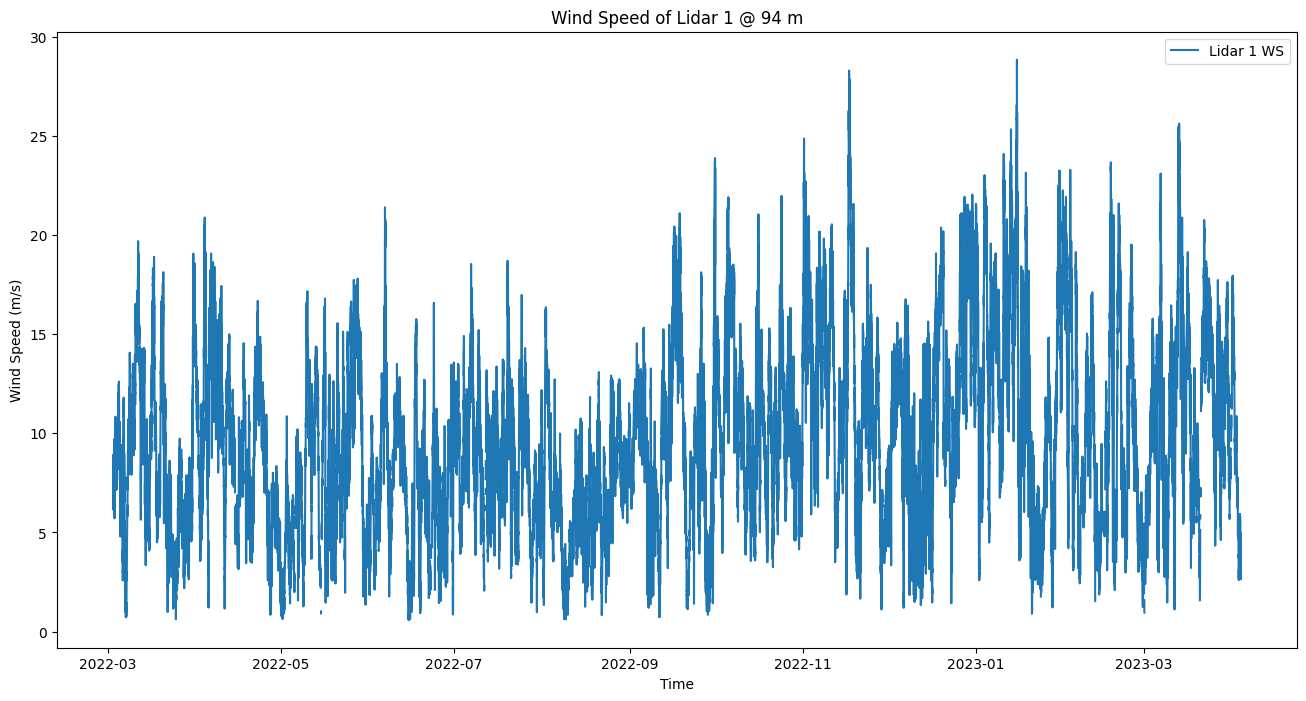

In [20]:
# plot the windspeed of lidar1
plt.figure(figsize=(16,8))
plt.plot(time_buoy6,ws_lidar1,label='Lidar 1 WS')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed of Lidar 1 @ 94 m')
plt.legend()
plt.show()

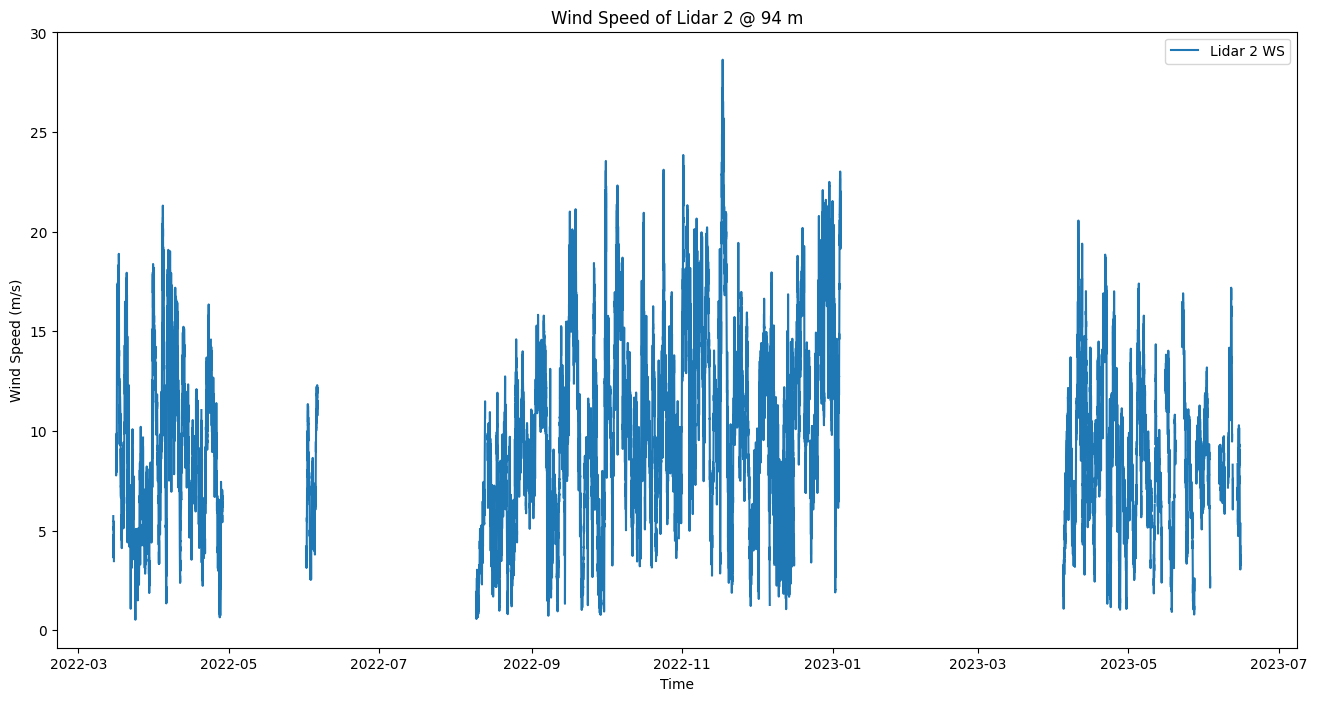

In [21]:
# plot the windspeed of lidar2
plt.figure(figsize=(16,8))
plt.plot(time_buoy2,ws_lidar2,label='Lidar 2 WS')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed of Lidar 2 @ 94 m')
plt.legend()
plt.show()

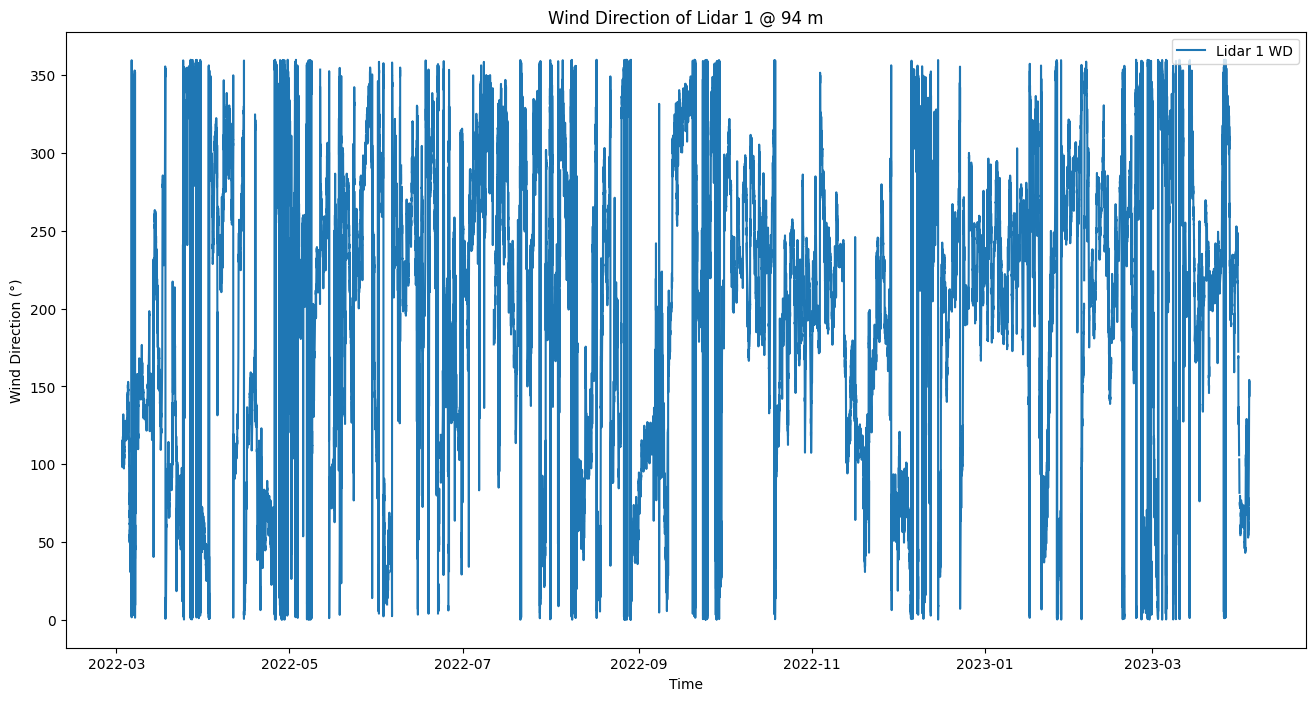

In [22]:
# plot the wind direction of lidar1
plt.figure(figsize=(16,8))
plt.plot(time_buoy6, wd_lidar1,label='Lidar 1 WD')
plt.xlabel('Time')
plt.ylabel('Wind Direction (°)')
plt.title('Wind Direction of Lidar 1 @ 94 m')
plt.legend()
plt.show()

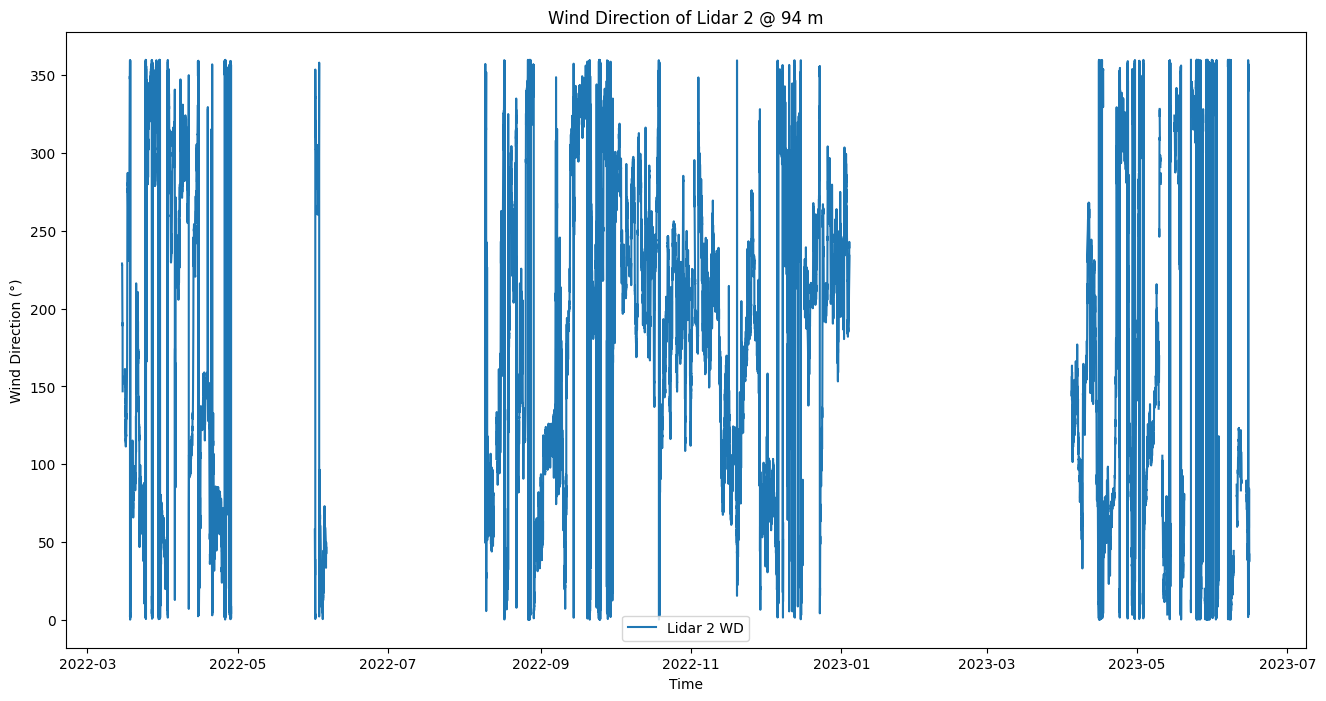

In [23]:
# plot the wind direction of lidar2
plt.figure(figsize=(16,8))
plt.plot(time_buoy2, wd_lidar2,label='Lidar 2 WD')
plt.xlabel('Time')
plt.ylabel('Wind Direction (°)')
plt.title('Wind Direction of Lidar 2 @ 94 m')
plt.legend()
plt.show()

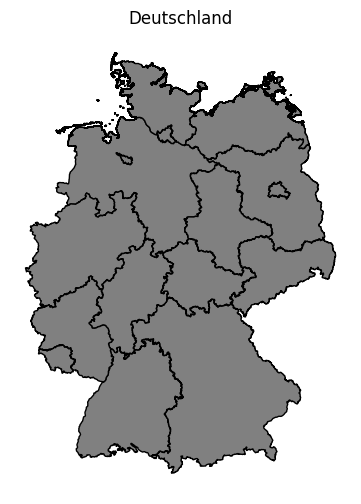

In [24]:
# DE - Germany Map Plot with Lambert Conformal Projection
proj1=ccrs.LambertConformal(central_longitude=10, central_latitude=51)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection=proj1)
deu.plot(ax=ax, legend=True, transform=ccrs.PlateCarree(),edgecolor='black', facecolor='grey',aspect=None)
ax.axis('off') # Switch off the Frame 
ax.set_title(f"Deutschland")

plt.show()

C:\Users\abdel\AppData\Local\Temp\ipykernel_28732\269387031.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nds_center= deu[deu["NAME_1"]=="Niedersachsen"].centroid


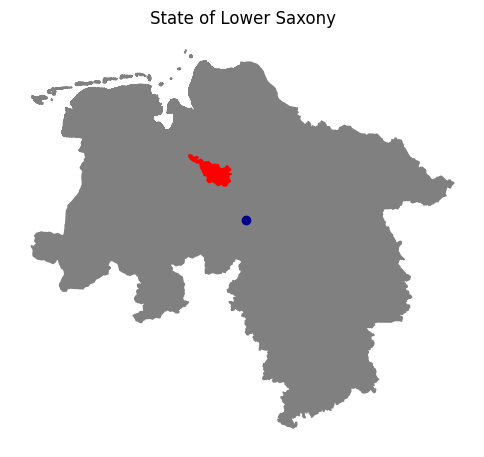

In [25]:
proj1=ccrs.LambertConformal(central_longitude=10, central_latitude=51)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection=proj1)
deu[deu["NAME_1"]=="Niedersachsen"].plot(ax=ax, legend=True, transform=ccrs.PlateCarree(),edgecolor='grey', facecolor='grey',aspect=None)
deu[deu["NAME_1"]=="Bremen"].plot(ax=ax, legend=True, transform=ccrs.PlateCarree(),edgecolor='red', facecolor='red',aspect=None)
nds_center= deu[deu["NAME_1"]=="Niedersachsen"].centroid
ax.scatter(nds_center.x,nds_center.y,transform=ccrs.PlateCarree(),color="darkblue") # Centerpoint of Lower Saxony
ax.axis('off') # Switch off the Frame 
ax.set_title(f"State of Lower Saxony")
plt.show()

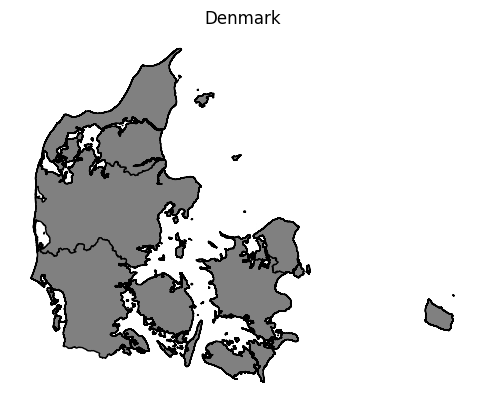

In [26]:
# DN - Denmark Map Plot with Lambert Conformal Projection
proj2=ccrs.LambertConformal(central_longitude=10, central_latitude=51)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection=proj2)
dnk.plot(ax=ax, legend=True, transform=ccrs.PlateCarree(),edgecolor='black', facecolor='grey',aspect=None)
ax.axis('off') # Switch off the Frame
ax.set_title(f"Denmark")

plt.show()

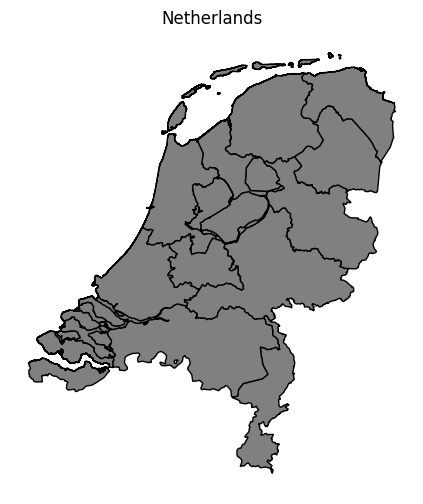

In [27]:
# NL - Netherlands Map Plot with Lambert Conformal Projection
proj3=ccrs.LambertConformal(central_longitude=10, central_latitude=51)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection=proj3)
nld.plot(ax=ax, legend=True, transform=ccrs.PlateCarree(),edgecolor='black', facecolor='grey',aspect=None)
ax.axis('off') # Switch off the Frame
ax.set_title(f"Netherlands")

plt.show()

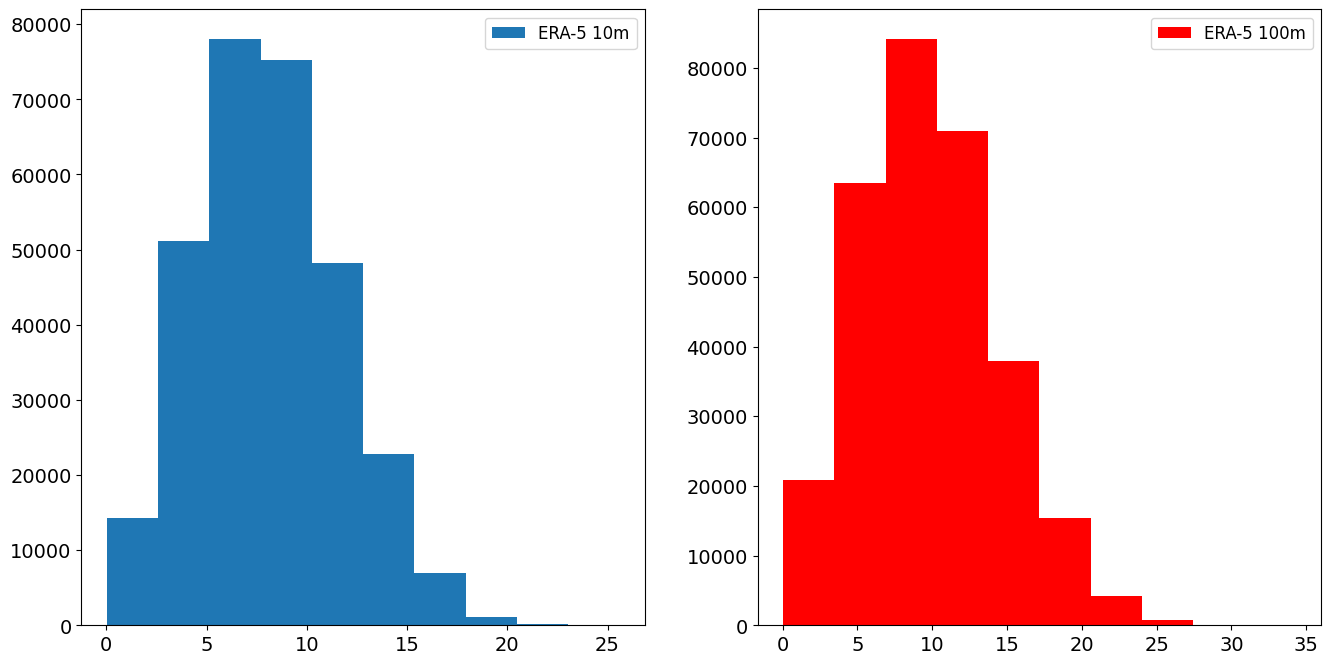

In [28]:
# Era5 Data Plot histogram
fig = plt.figure(figsize=(16,8))
fig.add_subplot(121)
plt.hist(era5_data['ws10'],label='ERA-5 10m')
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend(fontsize= 12)

fig.add_subplot(122)
plt.hist(era5_data['ws100'],label='ERA-5 100m',color='red')
#plt.xlabel('Sea ice extent',fontsize= 14)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend(fontsize= 12)


In [29]:
# describe potential deficiencies (e.g. data gaps)


In [30]:
# plots of power curves of the turbines


3. Do a long-term referencing with lidar measurements and model data (ERA5) using different MCP methods

4. Plot the relevant quantities after long-term referencing

In [31]:
# Do a long-term referencing with lidar measurements and model data (ERA5) using different MCP methods

# resample the lidar data to 1 hour
df_lidar1_resampled = df_lidar1.resample('1h').mean()
df_lidar2_resampled = df_lidar2.resample('1h').mean()

# make 2 copies of the era5 data with same time index as the lidar data
era5_data_lidar1 = era5_data.reindex(df_lidar1_resampled.index, method='nearest')
era5_data_lidar2 = era5_data.reindex(df_lidar2_resampled.index, method='nearest')


In [32]:
# address nan values in the df_lidar1_resampled and df_lidar2_resampled

# Interpolate missing values (keeps data size but may introduce noise)
df_combined_lidar1 = pd.concat([df_lidar1_resampled[['ws', 'wd']], era5_data_lidar1[['ws100', 'ws10', 'wd100', 'wd10']]], axis=1)
df_combined_lidar1 = df_combined_lidar1.interpolate(method='linear')

df_combined_lidar2 = pd.concat([df_lidar2_resampled[['ws', 'wd']], era5_data_lidar2[['ws100', 'ws10', 'wd100', 'wd10']]], axis=1)
df_combined_lidar2 = df_combined_lidar2.interpolate(method='linear')
# fill the nans at the beginning of df_combined_lidar2 using bfill() method 
# (backward fill method because the first values are nan for df_combined_lidar2)
df_combined_lidar2.bfill(inplace=True)
# df_combined_lidar2.fillna(method='bfill', inplace=True) older version of pandas

# Extract cleaned data for Lidar 1 and Lidar 2

# Lidar 1 WS100
X_ws100_lidar1 = df_combined_lidar1[['ws100']].values.reshape(-1, 1)
y_ws100_lidar1 = df_combined_lidar1['ws'].values

# Lidar 1 WS10
X_ws10_lidar1 = df_combined_lidar1[['ws10']].values.reshape(-1, 1)
y_ws10_lidar1 = df_combined_lidar1['ws'].values

# Lidar 2 WS100
X_ws100_lidar2 = df_combined_lidar2[['ws100']].values.reshape(-1, 1)
y_ws100_lidar2 = df_combined_lidar2['ws'].values

# Lidar 2 WS10
X_ws10_lidar2 = df_combined_lidar2[['ws10']].values.reshape(-1, 1)
y_ws10_lidar2 = df_combined_lidar2['ws'].values

# Lidar 1 WD100
X_wd100_lidar1 = df_combined_lidar1[['wd100']].values.reshape(-1, 1)
y_wd100_lidar1 = df_combined_lidar1['wd'].values

# Lidar 1 WD10
X_wd10_lidar1 = df_combined_lidar1[['wd10']].values.reshape(-1, 1)
y_wd10_lidar1 = df_combined_lidar1['wd'].values

# Lidar 2 WD100
X_wd100_lidar2 = df_combined_lidar2[['wd100']].values.reshape(-1, 1)
y_wd100_lidar2 = df_combined_lidar2['wd'].values

# Lidar 2 WD10
X_wd10_lidar2 = df_combined_lidar2[['wd10']].values.reshape(-1, 1)
y_wd10_lidar2 = df_combined_lidar2['wd'].values

Wind Speed Model at 100m - SSE: 19710.405266195536, MSE: 2.07, R²: 0.90


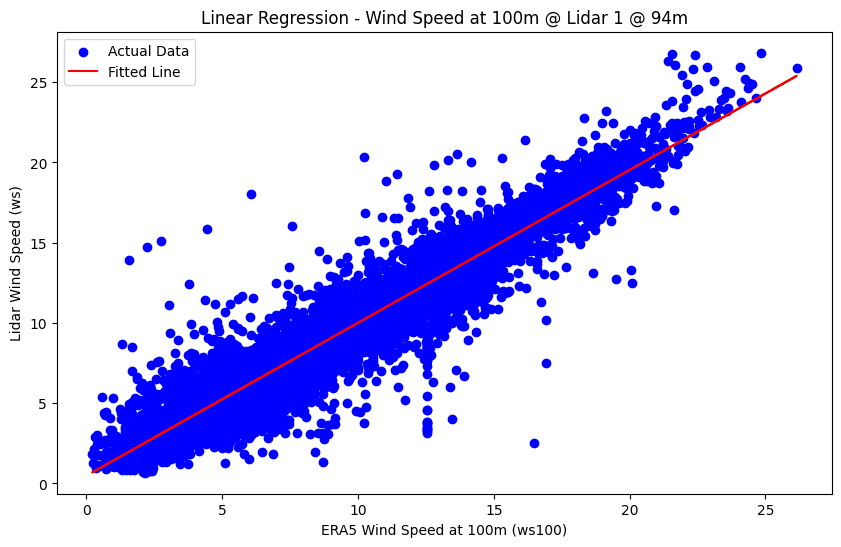

In [105]:
# Linear Regression - Wind Speed at 100m @ Lidar 1

# Initialize and fit the model
model_ws100_lidar1 = LinearRegression()
model_ws100_lidar1.fit(X_ws100_lidar1, y_ws100_lidar1)

# Predict using the model
y_pred_ws100_lidar1 = model_ws100_lidar1.predict(era5_data_lidar1['ws100'].values.reshape(-1, 1))

# Evaluate the model
sse_ws100_lidar1 = np.sum((y_ws100_lidar1 - y_pred_ws100_lidar1)**2)
mse_ws100_lidar1 = mean_squared_error(y_ws100_lidar1, y_pred_ws100_lidar1)
r2_ws100_lidar1 = r2_score(y_ws100_lidar1, y_pred_ws100_lidar1)

print(f'Wind Speed Model at 100m - SSE: {sse_ws100_lidar1}, MSE: {mse_ws100_lidar1:.2f}, R²: {r2_ws100_lidar1:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_ws100_lidar1, y_ws100_lidar1, color='blue', label='Actual Data')
plt.plot(X_ws100_lidar1, y_pred_ws100_lidar1, color='red', label='Fitted Line')
plt.xlabel('ERA5 Wind Speed at 100m (ws100)')
plt.ylabel('Lidar Wind Speed (ws)')
plt.title('Linear Regression - Wind Speed at 100m @ Lidar 1 @ 94m')
plt.legend()
plt.show()

Wind Speed Model at 10m - SSE: 27480.95078220953, MSE: 2.88, R²: 0.86


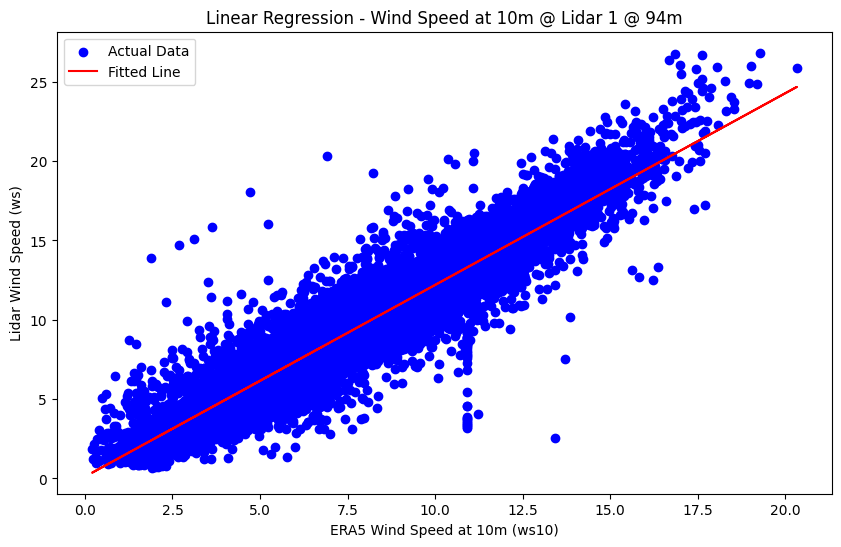

In [106]:
# Linear Regression - Wind Speed at 10m @ Lidar 1

# Initialize and fit the model
model_ws10_lidar1 = LinearRegression()
model_ws10_lidar1.fit(X_ws10_lidar1, y_ws10_lidar1)

# Predict using the model
y_pred_ws10_lidar1 = model_ws10_lidar1.predict(era5_data_lidar1['ws10'].values.reshape(-1, 1))

# Evaluate the model
sse_ws10_lidar1 = np.sum((y_ws10_lidar1 - y_pred_ws10_lidar1)**2)
mse_ws10_lidar1 = mean_squared_error(y_ws10_lidar1, y_pred_ws10_lidar1)
r2_ws10_lidar1 = r2_score(y_ws10_lidar1, y_pred_ws10_lidar1)

print(f'Wind Speed Model at 10m - SSE: {sse_ws10_lidar1}, MSE: {mse_ws10_lidar1:.2f}, R²: {r2_ws10_lidar1:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_ws10_lidar1, y_ws10_lidar1, color='blue', label='Actual Data')
plt.plot(X_ws10_lidar1, y_pred_ws10_lidar1, color='red', label='Fitted Line')
plt.xlabel('ERA5 Wind Speed at 10m (ws10)')
plt.ylabel('Lidar Wind Speed (ws)')
plt.title('Linear Regression - Wind Speed at 10m @ Lidar 1 @ 94m')
plt.legend()
plt.show()

Wind Speed Model at 100m - SSE: 146477.80159602434, MSE: 12.99, R²: 0.39


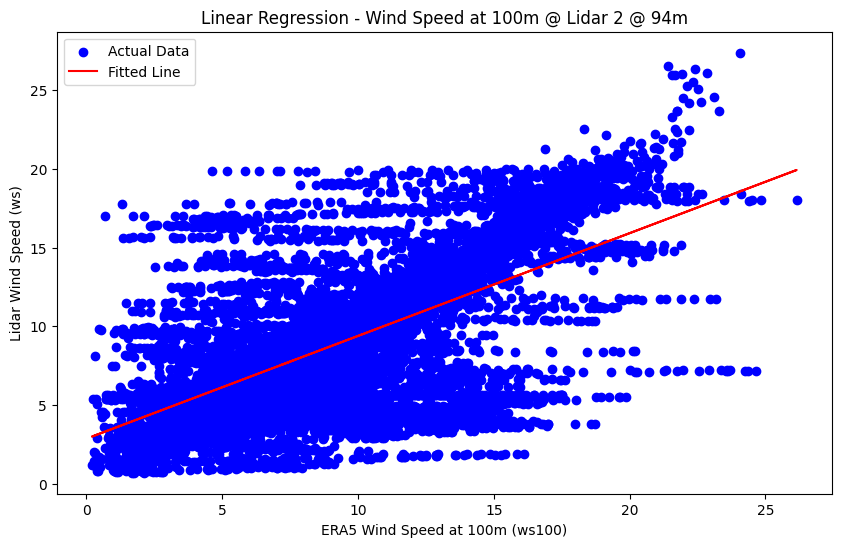

In [107]:
# Linear Regression - Wind Speed at 100m @ Lidar 2

# Initialize and fit the model
model_ws100_lidar2 = LinearRegression()
model_ws100_lidar2.fit(X_ws100_lidar2, y_ws100_lidar2)

# Predict using the model
y_pred_ws100_lidar2 = model_ws100_lidar2.predict(era5_data_lidar2['ws100'].values.reshape(-1, 1))

# Evaluate the model
sse_ws100_lidar2 = np.sum((y_ws100_lidar2 - y_pred_ws100_lidar2)**2) # sum of squared errors
mse_ws100_lidar2 = mean_squared_error(y_ws100_lidar2, y_pred_ws100_lidar2) # mean squared error
r2_ws100_lidar2 = r2_score(y_ws100_lidar2, y_pred_ws100_lidar2) # r2 score (coefficient of determination)

print(f'Wind Speed Model at 100m - SSE: {sse_ws100_lidar2}, MSE: {mse_ws100_lidar2:.2f}, R²: {r2_ws100_lidar2:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_ws100_lidar2, y_ws100_lidar2, color='blue', label='Actual Data')
plt.plot(X_ws100_lidar2, y_pred_ws100_lidar2, color='red', label='Fitted Line')
plt.xlabel('ERA5 Wind Speed at 100m (ws100)')
plt.ylabel('Lidar Wind Speed (ws)')
plt.title('Linear Regression - Wind Speed at 100m @ Lidar 2 @ 94m')
plt.legend()
plt.show()

Wind Speed Model at 10m - SSE: 143397.52902734675, MSE: 12.71, R²: 0.40


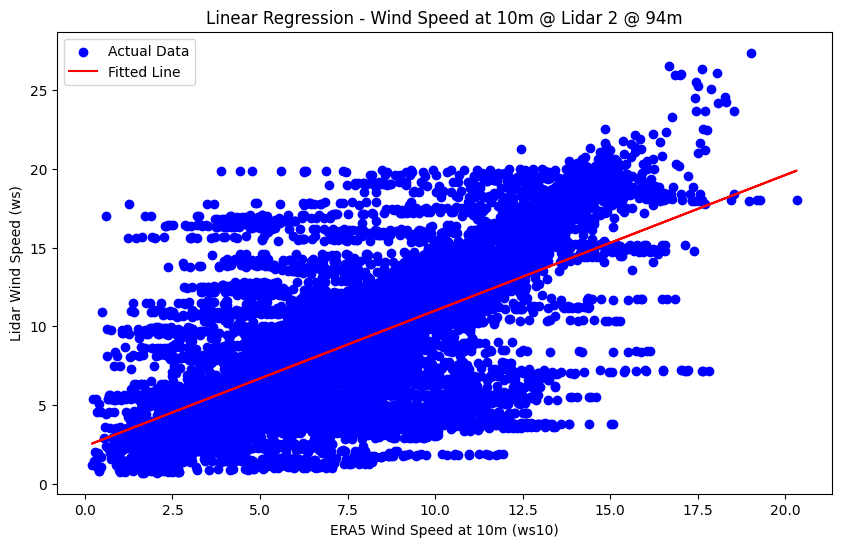

In [108]:
# Linear Regression - Wind Speed at 10m @ Lidar 2

# Initialize and fit the model
model_ws10_lidar2 = LinearRegression()
model_ws10_lidar2.fit(X_ws10_lidar2, y_ws10_lidar2)

# Predict using the model
y_pred_ws10_lidar2 = model_ws10_lidar2.predict(era5_data_lidar2['ws10'].values.reshape(-1, 1))

# Evaluate the model
sse_ws10_lidar2 = np.sum((y_ws10_lidar2 - y_pred_ws10_lidar2)**2)
mse_ws10_lidar2 = mean_squared_error(y_ws10_lidar2, y_pred_ws10_lidar2)
r2_ws10_lidar2 = r2_score(y_ws10_lidar2, y_pred_ws10_lidar2)

print(f'Wind Speed Model at 10m - SSE: {sse_ws10_lidar2}, MSE: {mse_ws10_lidar2:.2f}, R²: {r2_ws10_lidar2:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_ws10_lidar2, y_ws10_lidar2, color='blue', label='Actual Data')
plt.plot(X_ws10_lidar2, y_pred_ws10_lidar2, color='red', label='Fitted Line')
plt.xlabel('ERA5 Wind Speed at 10m (ws10)')
plt.ylabel('Lidar Wind Speed (ws)')
plt.title('Linear Regression - Wind Speed at 10m @ Lidar 2 @ 94m')
plt.legend()
plt.show()

Wind Direction Model at 100m - SSE: 21458123.342673488, MSE: 2250.93, R²: 0.72


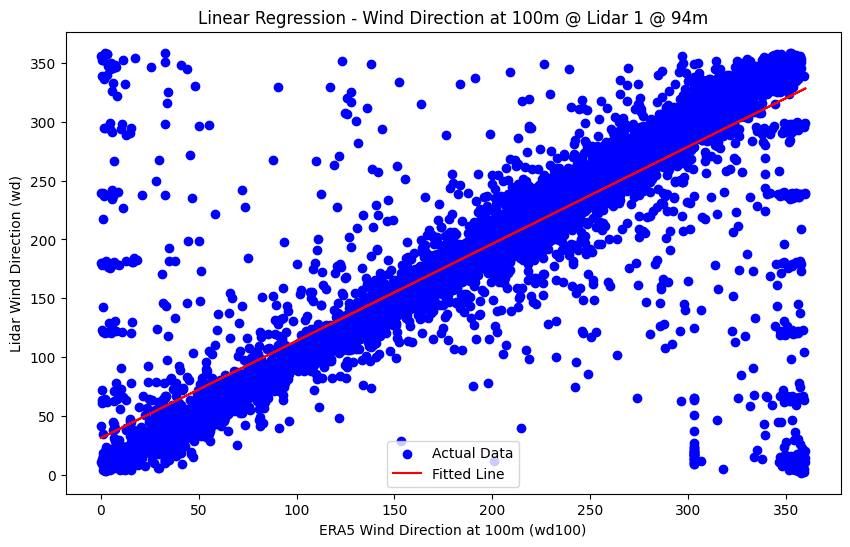

In [109]:
# Linear Regression - Wind Direction at 100m @ Lidar 1

# Initialize and fit the model
model_wd100_lidar1 = LinearRegression()
model_wd100_lidar1.fit(X_wd100_lidar1, y_wd100_lidar1)

# Predict using the model
y_pred_wd100_lidar1 = model_wd100_lidar1.predict(era5_data_lidar1['wd100'].values.reshape(-1, 1))

# Evaluate the model
sse_wd100_lidar1 = np.sum((y_wd100_lidar1 - y_pred_wd100_lidar1)**2)
mse_wd100_lidar1 = mean_squared_error(y_wd100_lidar1, y_pred_wd100_lidar1)
r2_wd100_lidar1 = r2_score(y_wd100_lidar1, y_pred_wd100_lidar1)

print(f'Wind Direction Model at 100m - SSE: {sse_wd100_lidar1}, MSE: {mse_wd100_lidar1:.2f}, R²: {r2_wd100_lidar1:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_wd100_lidar1, y_wd100_lidar1, color='blue', label='Actual Data')
plt.plot(X_wd100_lidar1, y_pred_wd100_lidar1, color='red', label='Fitted Line')
plt.xlabel('ERA5 Wind Direction at 100m (wd100)')
plt.ylabel('Lidar Wind Direction (wd)')
plt.title('Linear Regression - Wind Direction at 100m @ Lidar 1 @ 94m')
plt.legend()
plt.show()

Wind Direction Model at 10m - SSE: 21512196.66005729, MSE: 2256.60, R²: 0.72


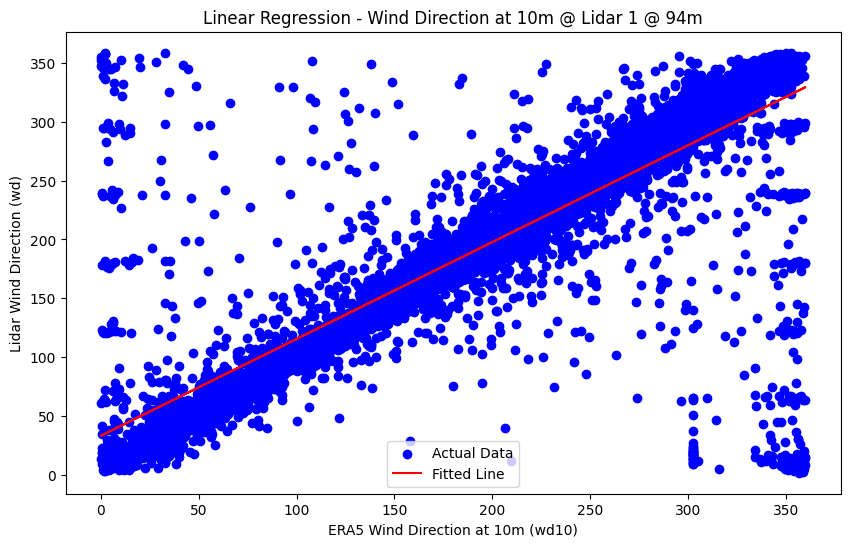

In [110]:
# Linear Regression - Wind Direction at 10m @ Lidar 1

# Initialize and fit the model
model_wd10_lidar1 = LinearRegression()
model_wd10_lidar1.fit(X_wd10_lidar1, y_wd10_lidar1)

# Predict using the model
y_pred_wd10_lidar1 = model_wd10_lidar1.predict(era5_data_lidar1['wd10'].values.reshape(-1, 1))

# Evaluate the model
sse_wd10_lidar1 = np.sum((y_wd10_lidar1 - y_pred_wd10_lidar1)**2)
mse_wd10_lidar1 = mean_squared_error(y_wd10_lidar1, y_pred_wd10_lidar1)
r2_wd10_lidar1 = r2_score(y_wd10_lidar1, y_pred_wd10_lidar1)

print(f'Wind Direction Model at 10m - SSE: {sse_wd10_lidar1}, MSE: {mse_wd10_lidar1:.2f}, R²: {r2_wd10_lidar1:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_wd10_lidar1, y_wd10_lidar1, color='blue', label='Actual Data')
plt.plot(X_wd10_lidar1, y_pred_wd10_lidar1, color='red', label='Fitted Line')
plt.xlabel('ERA5 Wind Direction at 10m (wd10)')
plt.ylabel('Lidar Wind Direction (wd)')
plt.title('Linear Regression - Wind Direction at 10m @ Lidar 1 @ 94m')
plt.legend()
plt.show()

Wind Direction Model at 100m - SSE: 54509826.8613388, MSE: 4832.43, R²: 0.32


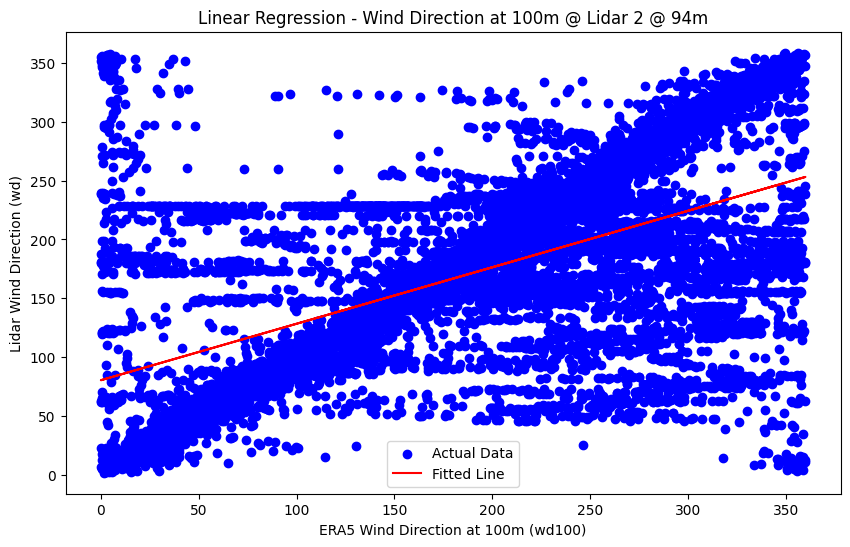

In [111]:
# Linear Regression - Wind Direction at 100m @ Lidar 2

# Initialize and fit the model
model_wd100_lidar2 = LinearRegression()
model_wd100_lidar2.fit(X_wd100_lidar2, y_wd100_lidar2)

# Predict using the model
y_pred_wd100_lidar2 = model_wd100_lidar2.predict(era5_data_lidar2['wd100'].values.reshape(-1, 1))

# Evaluate the model
sse_wd100_lidar2 = np.sum((y_wd100_lidar2 - y_pred_wd100_lidar2)**2)
mse_wd100_lidar2 = mean_squared_error(y_wd100_lidar2, y_pred_wd100_lidar2)
r2_wd100_lidar2 = r2_score(y_wd100_lidar2, y_pred_wd100_lidar2)

print(f'Wind Direction Model at 100m - SSE: {sse_wd100_lidar2}, MSE: {mse_wd100_lidar2:.2f}, R²: {r2_wd100_lidar2:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_wd100_lidar2, y_wd100_lidar2, color='blue', label='Actual Data')
plt.plot(X_wd100_lidar2, y_pred_wd100_lidar2, color='red', label='Fitted Line')
plt.xlabel('ERA5 Wind Direction at 100m (wd100)')
plt.ylabel('Lidar Wind Direction (wd)')
plt.title('Linear Regression - Wind Direction at 100m @ Lidar 2 @ 94m')
plt.legend()
plt.show()

Wind Direction Model at 10m - SSE: 54050927.8144839, MSE: 4791.75, R²: 0.33


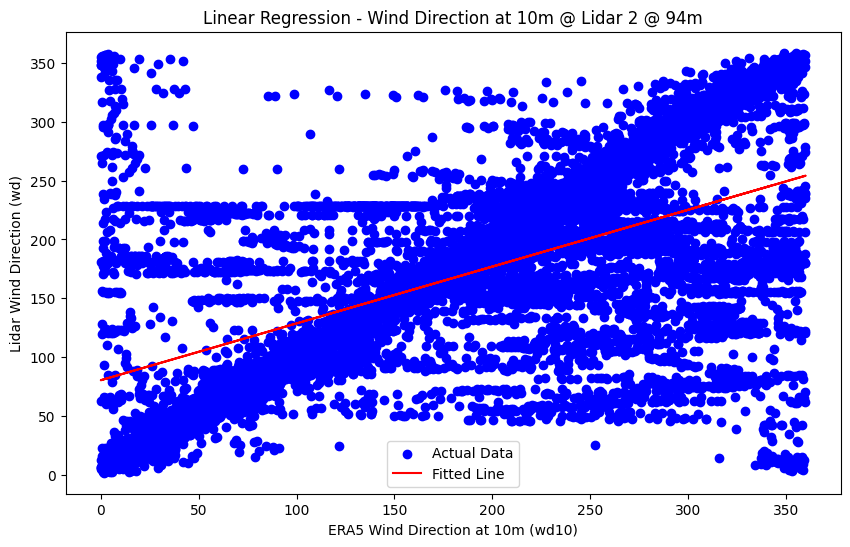

In [113]:
# Linear Regression - Wind Direction at 10m @ Lidar 2

# Initialize and fit the model
model_wd10_lidar2 = LinearRegression()
model_wd10_lidar2.fit(X_wd10_lidar2, y_wd10_lidar2)

# Predict using the model
y_pred_wd10_lidar2 = model_wd10_lidar2.predict(era5_data_lidar2['wd10'].values.reshape(-1, 1))

# Evaluate the model
sse_wd10_lidar2 = np.sum((y_wd10_lidar2 - y_pred_wd10_lidar2)**2)
mse_wd10_lidar2 = mean_squared_error(y_wd10_lidar2, y_pred_wd10_lidar2)
r2_wd10_lidar2 = r2_score(y_wd10_lidar2, y_pred_wd10_lidar2)

print(f'Wind Direction Model at 10m - SSE: {sse_wd10_lidar2}, MSE: {mse_wd10_lidar2:.2f}, R²: {r2_wd10_lidar2:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_wd10_lidar2, y_wd10_lidar2, color='blue', label='Actual Data')
plt.plot(X_wd10_lidar2, y_pred_wd10_lidar2, color='red', label='Fitted Line')
plt.xlabel('ERA5 Wind Direction at 10m (wd10)')
plt.ylabel('Lidar Wind Direction (wd)')
plt.title('Linear Regression - Wind Direction at 10m @ Lidar 2 @ 94m')
plt.legend()
plt.show()

In [114]:
# Calculate Pearson correlation coefficient for wind speed at 100m of Lidar 1
ws_pearson_corr, ws_p_value = pearsonr(df_combined_lidar1['ws'], df_combined_lidar1['ws100'])

print(f'Pearson Correlation Coefficient for Lidar 1 Wind Speed at 100m: {ws_pearson_corr:.2f}')
print(f'P-value: {ws_p_value:.2e}')
print()

# Calculate Pearson correlation coefficient for wind speed at 10m of Lidar 1
ws_pearson_corr, ws_p_value = pearsonr(df_combined_lidar1['ws'], df_combined_lidar1['ws10'])

print(f'Pearson Correlation Coefficient for Lidar 1 Wind Speed at 10m: {ws_pearson_corr:.2f}')
print(f'P-value: {ws_p_value:.2e}')
print()

# Calculate Pearson correlation coefficient for wind speed at 100m of Lidar 2
ws_pearson_corr, ws_p_value = pearsonr(df_combined_lidar2['ws'], df_combined_lidar2['ws100'])

print(f'Pearson Correlation Coefficient for Lidar 2 Wind Speed at 100m: {ws_pearson_corr:.2f}')
print(f'P-value: {ws_p_value:.2e}')
print()

# Calculate Pearson correlation coefficient for wind speed at 10m of Lidar 2
ws_pearson_corr, ws_p_value = pearsonr(df_combined_lidar2['ws'], df_combined_lidar2['ws10'])

print(f'Pearson Correlation Coefficient for Lidar 2 Wind Speed at 10m: {ws_pearson_corr:.2f}')
print(f'P-value: {ws_p_value:.2e}')
print()

# Calculate Pearson correlation coefficient for wind direction at 100m of Lidar 1
wd_pearson_corr, wd_p_value = pearsonr(df_combined_lidar1['wd'], df_combined_lidar1['wd100'])

print(f'Pearson Correlation Coefficient for Lidar 1 Wind Direction at 100m: {wd_pearson_corr:.2f}')
print(f'P-value: {wd_p_value:.2e}')
print()

# Calculate Pearson correlation coefficient for wind direction at 10m of Lidar 1
wd_pearson_corr, wd_p_value = pearsonr(df_combined_lidar1['wd'], df_combined_lidar1['wd10'])

print(f'Pearson Correlation Coefficient for Lidar 1 Wind Direction at 10m: {wd_pearson_corr:.2f}')
print(f'P-value: {wd_p_value:.2e}')
print()

# Calculate Pearson correlation coefficient for wind direction at 100m of Lidar 2
wd_pearson_corr, wd_p_value = pearsonr(df_combined_lidar2['wd'], df_combined_lidar2['wd100'])

print(f'Pearson Correlation Coefficient for Lidar 2 Wind Direction at 100m: {wd_pearson_corr:.2f}')
print(f'P-value: {wd_p_value:.2e}')
print()

# Calculate Pearson correlation coefficient for wind direction at 10m of Lidar 2
wd_pearson_corr, wd_p_value = pearsonr(df_combined_lidar2['wd'], df_combined_lidar2['wd10'])

print(f'Pearson Correlation Coefficient for Lidar 2 Wind Direction at 10m: {wd_pearson_corr:.2f}')
print(f'P-value: {wd_p_value:.2e}')
print()

# Calculate the mean wind speed and wind direction for Lidar 1
mean_ws_lidar1 = df_combined_lidar1['ws'].mean()
mean_wd_lidar1 = df_combined_lidar1['wd'].mean()

print(f'Mean Wind Speed at Lidar 1: {mean_ws_lidar1:.2f} m/s')
print(f'Mean Wind Direction at Lidar 1: {mean_wd_lidar1:.2f}°')
print()

# Calculate the mean wind speed and wind direction for Lidar 2
mean_ws_lidar2 = df_combined_lidar2['ws'].mean()
mean_wd_lidar2 = df_combined_lidar2['wd'].mean()

print(f'Mean Wind Speed at Lidar 2: {mean_ws_lidar2:.2f} m/s')
print(f'Mean Wind Direction at Lidar 2: {mean_wd_lidar2:.2f}°')
print()

# Calculate the standard deviation of wind speed and wind direction for Lidar 1
std_ws_lidar1 = df_combined_lidar1['ws'].std()
std_wd_lidar1 = df_combined_lidar1['wd'].std()

print(f'Standard Deviation of Wind Speed at Lidar 1: {std_ws_lidar1:.2f} m/s')
print(f'Standard Deviation of Wind Direction at Lidar 1: {std_wd_lidar1:.2f}°')
print()

# Calculate the standard deviation of wind speed and wind direction for Lidar 2
std_ws_lidar2 = df_combined_lidar2['ws'].std()
std_wd_lidar2 = df_combined_lidar2['wd'].std()

print(f'Standard Deviation of Wind Speed at Lidar 2: {std_ws_lidar2:.2f} m/s')
print(f'Standard Deviation of Wind Direction at Lidar 2: {std_wd_lidar2:.2f}°')
print()

# Calculate the correlation between wind speed and wind direction for Lidar 1
corr_ws_wd_lidar1 = df_combined_lidar1['ws'].corr(df_combined_lidar1['wd'])

print(f'Correlation between Wind Speed and Wind Direction at Lidar 1: {corr_ws_wd_lidar1:.2f}')
print()

# Calculate the correlation between wind speed and wind direction for Lidar 2
corr_ws_wd_lidar2 = df_combined_lidar2['ws'].corr(df_combined_lidar2['wd'])

print(f'Correlation between Wind Speed and Wind Direction at Lidar 2: {corr_ws_wd_lidar2:.2f}')
print()


Pearson Correlation Coefficient for Lidar 1 Wind Speed at 100m: 0.95
P-value: 0.00e+00

Pearson Correlation Coefficient for Lidar 1 Wind Speed at 10m: 0.93
P-value: 0.00e+00

Pearson Correlation Coefficient for Lidar 2 Wind Speed at 100m: 0.62
P-value: 0.00e+00

Pearson Correlation Coefficient for Lidar 2 Wind Speed at 10m: 0.63
P-value: 0.00e+00

Pearson Correlation Coefficient for Lidar 1 Wind Direction at 100m: 0.85
P-value: 0.00e+00

Pearson Correlation Coefficient for Lidar 1 Wind Direction at 10m: 0.85
P-value: 0.00e+00

Pearson Correlation Coefficient for Lidar 2 Wind Direction at 100m: 0.57
P-value: 0.00e+00

Pearson Correlation Coefficient for Lidar 2 Wind Direction at 10m: 0.57
P-value: 0.00e+00

Mean Wind Speed at Lidar 1: 9.63 m/s
Mean Wind Direction at Lidar 1: 202.33°

Mean Wind Speed at Lidar 2: 9.00 m/s
Mean Wind Direction at Lidar 2: 176.45°

Standard Deviation of Wind Speed at Lidar 1: 4.53 m/s
Standard Deviation of Wind Direction at Lidar 1: 89.99°

Standard Deviatio

In [115]:
# Data frame for the corrected ERA5 data with time index from the buoy 6 data 
# and ws from y_pred_ws100_lidar1 and wd from y_pred_wd100_lidar1
corrected_era5_data_lidar1 = pd.DataFrame(index=df_combined_lidar1.index, 
                            data={'ws100': y_pred_ws100_lidar1, 'wd100': y_pred_wd100_lidar1})

# Data frame for the corrected ERA5 data with time index from the buoy 2 data
# and ws from y_pred_ws100_lidar2 and wd from y_pred_wd100_lidar2
corrected_era5_data_lidar2 = pd.DataFrame(index=df_combined_lidar2.index, 
                            data={'ws100': y_pred_ws100_lidar2, 'wd100': y_pred_wd100_lidar2})

5. Find a geometrically optimized wind farm layout for the areas N-9.1, N-9.2 and N-9.3 using FOXES (you can use the provided material for reference but we want to see the code).

Turbine 0, T0: IEA15MW
Turbine 1, T1: IEA15MW
Turbine 2, T2: IEA15MW
Turbine 3, T3: IEA15MW
Turbine 4, T4: IEA15MW
Turbine 5, T5: IEA15MW
Turbine 6, T6: IEA15MW
Turbine 7, T7: IEA15MW
Turbine 8, T8: IEA15MW
Turbine 9, T9: IEA15MW
Turbine 10, T10: IEA15MW
Turbine 11, T11: IEA15MW
Turbine 12, T12: IEA15MW
Turbine 13, T13: IEA15MW
Turbine 14, T14: IEA15MW
Turbine 15, T15: IEA15MW
Turbine 16, T16: IEA15MW
Turbine 17, T17: IEA15MW
Turbine 18, T18: IEA15MW
Turbine 19, T19: IEA15MW
Turbine 20, T20: IEA15MW
Turbine 21, T21: IEA15MW
Turbine 22, T22: IEA15MW
Turbine 23, T23: IEA15MW
Turbine 24, T24: IEA15MW
Turbine 25, T25: IEA15MW
Turbine 26, T26: IEA15MW
Turbine 27, T27: IEA15MW
Turbine 28, T28: IEA15MW
Turbine 29, T29: IEA15MW
Turbine 30, T30: IEA15MW
Turbine 31, T31: IEA15MW
Turbine 32, T32: IEA15MW
Turbine 33, T33: IEA15MW
Turbine 34, T34: IEA15MW
Turbine 35, T35: IEA15MW
Turbine 36, T36: IEA15MW
Turbine 37, T37: IEA15MW
Turbine 38, T38: IEA15MW
Turbine 39, T39: IEA15MW
Turbine 40, T40: IEA

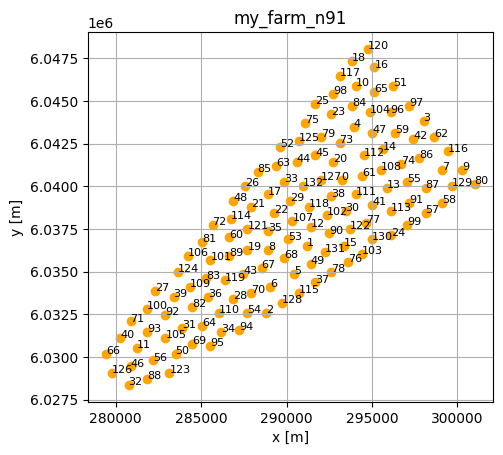

In [116]:
# Find a geometrically optimized wind farm layout for the areas N-9.1, N-9.2 and N-9.3 using FOXES (you can use the provided material for reference but we want to see the code).
# Area_N9_1
farm_n91 = foxes.WindFarm(name="my_farm_n91")
# add turbines to the farm (Inside area_n91 there is a row for each turbine with the columns 'x' and 'y' for the coordinates and 'name' for the name of the turbine)
for i, row in area_n91.iterrows():
    farm_n91.add_turbine(foxes.Turbine(xy=(row['x'], row['y']), 
                                       turbine_models=['IEA15MW']))

# optimize the farm layout
ax = foxes.output.FarmLayoutOutput(farm_n91).get_figure()
plt.show()


## Boundaries of area_n91 are t80, t120, t66, t32

Turbine 0, T0: IEA15MW
Turbine 1, T1: IEA15MW
Turbine 2, T2: IEA15MW
Turbine 3, T3: IEA15MW
Turbine 4, T4: IEA15MW
Turbine 5, T5: IEA15MW
Turbine 6, T6: IEA15MW
Turbine 7, T7: IEA15MW
Turbine 8, T8: IEA15MW
Turbine 9, T9: IEA15MW
Turbine 10, T10: IEA15MW
Turbine 11, T11: IEA15MW
Turbine 12, T12: IEA15MW
Turbine 13, T13: IEA15MW
Turbine 14, T14: IEA15MW
Turbine 15, T15: IEA15MW
Turbine 16, T16: IEA15MW
Turbine 17, T17: IEA15MW
Turbine 18, T18: IEA15MW
Turbine 19, T19: IEA15MW
Turbine 20, T20: IEA15MW
Turbine 21, T21: IEA15MW
Turbine 22, T22: IEA15MW
Turbine 23, T23: IEA15MW
Turbine 24, T24: IEA15MW
Turbine 25, T25: IEA15MW
Turbine 26, T26: IEA15MW
Turbine 27, T27: IEA15MW
Turbine 28, T28: IEA15MW
Turbine 29, T29: IEA15MW
Turbine 30, T30: IEA15MW
Turbine 31, T31: IEA15MW
Turbine 32, T32: IEA15MW
Turbine 33, T33: IEA15MW
Turbine 34, T34: IEA15MW
Turbine 35, T35: IEA15MW
Turbine 36, T36: IEA15MW
Turbine 37, T37: IEA15MW
Turbine 38, T38: IEA15MW
Turbine 39, T39: IEA15MW
Turbine 40, T40: IEA

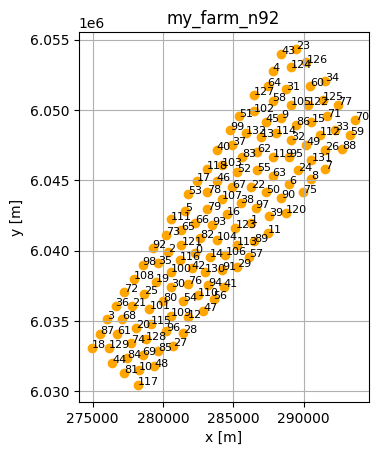

In [117]:
# Area_N9_2
farm_n92 = foxes.WindFarm(name="my_farm_n92")

for i, row in area_n92.iterrows():
    farm_n92.add_turbine(foxes.Turbine(xy=(row['x'], row['y']), 
                                       turbine_models=['IEA15MW']))
    
# optimize the farm layout
ax = foxes.output.FarmLayoutOutput(farm_n92).get_figure()
plt.show()

## Boundaries of area_n92 are t70, t23, t18, t117

Turbine 0, T0: IEA15MW
Turbine 1, T1: IEA15MW
Turbine 2, T2: IEA15MW
Turbine 3, T3: IEA15MW
Turbine 4, T4: IEA15MW
Turbine 5, T5: IEA15MW
Turbine 6, T6: IEA15MW
Turbine 7, T7: IEA15MW
Turbine 8, T8: IEA15MW
Turbine 9, T9: IEA15MW
Turbine 10, T10: IEA15MW
Turbine 11, T11: IEA15MW
Turbine 12, T12: IEA15MW
Turbine 13, T13: IEA15MW
Turbine 14, T14: IEA15MW
Turbine 15, T15: IEA15MW
Turbine 16, T16: IEA15MW
Turbine 17, T17: IEA15MW
Turbine 18, T18: IEA15MW
Turbine 19, T19: IEA15MW
Turbine 20, T20: IEA15MW
Turbine 21, T21: IEA15MW
Turbine 22, T22: IEA15MW
Turbine 23, T23: IEA15MW
Turbine 24, T24: IEA15MW
Turbine 25, T25: IEA15MW
Turbine 26, T26: IEA15MW
Turbine 27, T27: IEA15MW
Turbine 28, T28: IEA15MW
Turbine 29, T29: IEA15MW
Turbine 30, T30: IEA15MW
Turbine 31, T31: IEA15MW
Turbine 32, T32: IEA15MW
Turbine 33, T33: IEA15MW
Turbine 34, T34: IEA15MW
Turbine 35, T35: IEA15MW
Turbine 36, T36: IEA15MW
Turbine 37, T37: IEA15MW
Turbine 38, T38: IEA15MW
Turbine 39, T39: IEA15MW
Turbine 40, T40: IEA

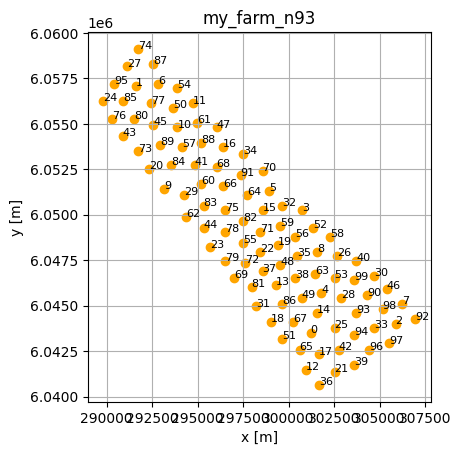

In [118]:
# Area_N9_3
farm_n93 = foxes.WindFarm(name="my_farm_n93")

for i, row in area_n93.iterrows():
    farm_n93.add_turbine(foxes.Turbine(xy=(row['x'], row['y']), 
                                       turbine_models=['IEA15MW']))
    
# optimize the farm layout
ax = foxes.output.FarmLayoutOutput(farm_n93).get_figure()
plt.show()

# Boudaries of area_n93 are t36, t92, t74, t24

In [119]:
# Function to get the boundaries of the wind farm area
def boundaries_from_dataframe(df):
    
    # Find the max x and its corresponding y
    max_x = df['x'].max()
    max_x_y = df.loc[df['x'].idxmax(), 'y']

    # Find the max y and its corresponding x
    max_y = df['y'].max()
    max_y_x = df.loc[df['y'].idxmax(), 'x']

    # Find the min x and its corresponding y
    min_x = df['x'].min()
    min_x_y = df.loc[df['x'].idxmin(), 'y']

    # Find the min y and its corresponding x
    min_y = df['y'].min()
    min_y_x = df.loc[df['y'].idxmin(), 'x']

    # Create the corner points array in the specified order
    corner_points = np.array([
        [max_x, max_x_y],
        [max_y_x, max_y],
        [min_x, min_x_y],
        [min_y_x, min_y]
    ], dtype=np.float64)
    
    return corner_points

Problem 'geom_reg_grid' (GeomRegGrid): Initializing
---------------------------------------------------
  n_vars_int  : 0
  n_vars_float: 5
---------------------------------------------------
  n_objectives: 1
  n_obj_cmptns: 1
---------------------------------------------------
  n_constraints: 1
  n_con_cmptns: 1
---------------------------------------------------
Grid data:
  pmin        = [ 279424.82404139 6028365.76942519]
  pmax        = [ 301024.82404139 6048045.76942519]
  min dist    = 720.0
  max dist    = 29220.924010030893
  n row max   = 43
  n max       = 1849


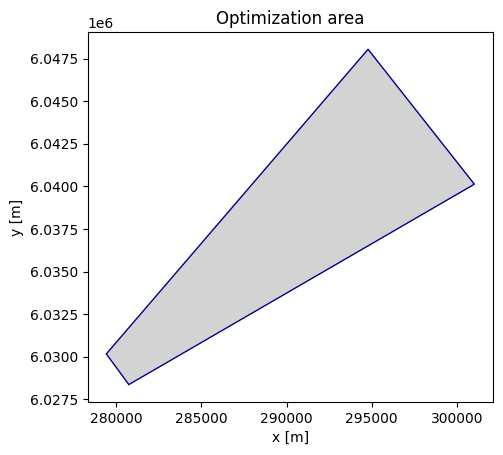

In [120]:
# geometrically optimized wind farm layout for the areas N-9.1

# area of interest N-9.1 boundaries
bounds_n91 = boundaries_from_dataframe(area_n91) # get the boundaries of the wind farm area

D_n91 = area_n91['D'][0]  # Diameter of the rotor

n_turbines_n91 = len(area_n91)  # Number of turbines

boundary_n91 = foxes.utils.geom2d.ClosedPolygon(bounds_n91) # create a closed polygon from the boundaries

problem_n91 = grg.GeomRegGrid( # create a geometric regular grid problem
    boundary_n91, 
    n_turbines=n_turbines_n91,  # the number of turbines to be placed 
    min_dist=3*D_n91,   # the minimal distance between turbines
    D=D_n91            # this avoids that rotor blades can reach out of area
)

problem_n91.add_objective(grg.MaxDensity(problem_n91, dfactor=2)) # maximize the density of turbines

problem_n91.add_constraint(grg.Valid(problem_n91)) # add a constraint to check if the turbines are inside the boundary
problem_n91.initialize() # initialize the problem

problem_n91.get_fig() # get the figure of the problem
plt.show()

Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: GA (GA)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: GA
  pop_size: 100
  seed: 42

Termination:
------------
  n_gen: 100

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      100 |  1.020000E+02 |  1.308200E+02 |             - |             -
     2 |      200 |  0.000000E+00 |  1.267100E+02 |  2.112120E+03 |  2.112120E+03
     3 |      300 |  0.000000E+00 |  1.189600E+02 |  2.516791E+03 |  2.051509E+03
     4 |      400 |  0.000000E+00 |  1.027800E+02 |  2.105796E+03 |  1.335521E+03
     5 |      500 |  0.000000E+00 |  7.323000E+01 |  3.322798E+03 |  1.206283E+03
     6 |      600 |  0.000000E+00 |  3.136000E+01 |  3.733274E+03 |  1.188993E+03
     7 |      700 |  0.000000E+00 |  1.1800000000 |  3.797624E+03 |  1.188993E+03
     8 |      800 |  0.000000E+00 |  0.000000E+00 |  2.576629E+03 |  1.053184E+03
     9 |  

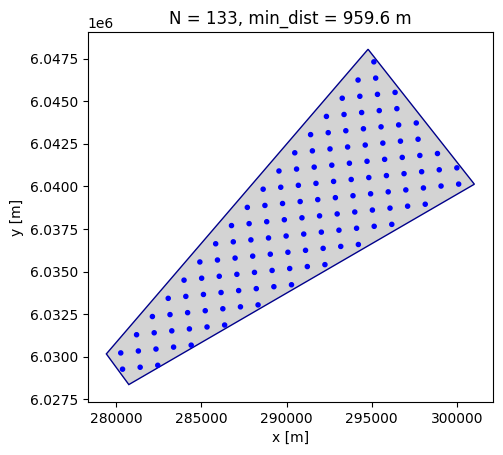

In [121]:
# Run the optimization

# selecting an optimizer. Here we pick the Genetic algorithm from `pymoo`, 
# called [GA](https://pymoo.org/algorithms/soo/ga.html):
solver_n91 = Optimizer_pymoo( # create an optimizer
    problem_n91,
    problem_pars=dict(vectorize=True), # vectorize the problem
    algo_pars=dict(    # the parameters of the algorithm
        type="GA",     # the type of the algorithm
        pop_size=100,  # the number of layouts per generation
        seed=42,       # the random seed, for reproducible results
    ),
    setup_pars=dict(), # the setup parameters of the optimization
    term_pars=dict(n_gen=100),  # the number of generations 
)
solver_n91.initialize() # initialize the solver
solver_n91.print_info() # print the information about the solver

# Run the optimization
results_n91 = solver_n91.solve() # solve the optimization problem
solver_n91.finalize(results_n91) # finalize the solver

# Plot the results
xy_n91, valid_n91 = results_n91.problem_results # get the results
problem_n91.get_fig(xy_n91, valid_n91) # plot the results
plt.show()

Problem 'geom_reg_grid' (GeomRegGrid): Initializing
---------------------------------------------------
  n_vars_int  : 0
  n_vars_float: 5
---------------------------------------------------
  n_objectives: 1
  n_obj_cmptns: 1
---------------------------------------------------
  n_constraints: 1
  n_con_cmptns: 1
---------------------------------------------------
Grid data:
  pmin        = [ 274958.42664909 6030455.14875722]
  pmax        = [ 293678.42664909 6054335.14875722]
  min dist    = 720.0
  max dist    = 30342.920096786995
  n row max   = 45
  n max       = 2025


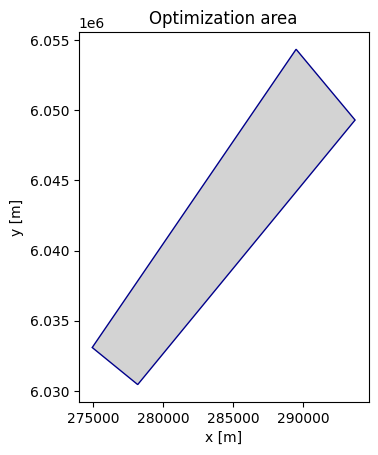

In [122]:
# geometrically optimized wind farm layout for the areas N-9.2

# area of interest N-9.2 boundaries
bounds_n92 = boundaries_from_dataframe(area_n92) # get the boundaries of the wind farm area

D_n92 = area_n92['D'][0]  # Diameter of the rotor

n_turbines_n92 = len(area_n92)  # Number of turbines

boundary_n92 = foxes.utils.geom2d.ClosedPolygon(bounds_n92) # create a closed polygon from the boundaries

problem_n92 = grg.GeomRegGrid( # create a geometric regular grid problem
    boundary_n92, 
    n_turbines=n_turbines_n92,  # the number of turbines to be placed 
    min_dist=3*D_n92,   # the minimal distance between turbines
    D=D_n92            # this avoids that rotor blades can reach out of area
)

problem_n92.add_objective(grg.MaxDensity(problem_n92, dfactor=2)) # maximize the density of turbines

problem_n92.add_constraint(grg.Valid(problem_n92)) # add a constraint to check if the turbines are inside the boundary
problem_n92.initialize() # initialize the problem

problem_n92.get_fig() # get the figure of the problem
plt.show()

Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: GA (GA)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: GA
  pop_size: 100
  seed: 42

Termination:
------------
  n_gen: 100

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      100 |  1.090000E+02 |  1.313300E+02 |             - |             -
     2 |      200 |  1.050000E+02 |  1.284700E+02 |             - |             -
     3 |      300 |  8.600000E+01 |  1.236500E+02 |             - |             -
     4 |      400 |  2.900000E+01 |  1.123000E+02 |             - |             -
     5 |      500 |  2.0000000000 |  9.286000E+01 |             - |             -
     6 |      600 |  0.000000E+00 |  6.384000E+01 |  3.620658E+03 |  1.137570E+03
     7 |      700 |  0.000000E+00 |  3.042000E+01 |  4.898238E+03 |  1.137570E+03
     8 |      800 |  0.000000E+00 |  4.1400000000 |  5.046505E+03 |  1.000098E+03
     9 |  

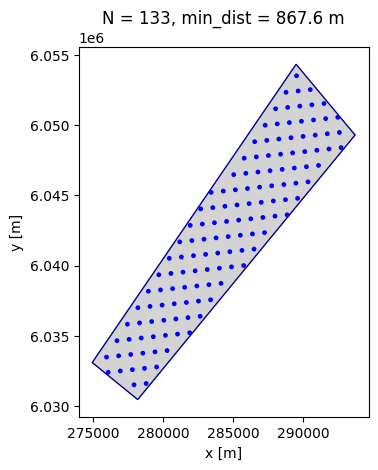

In [123]:
# Run the optimization

# selecting an optimizer. Here we pick the Genetic algorithm from `pymoo`,
# called [GA](https://pymoo.org/algorithms/soo/ga.html):
solver_n92 = Optimizer_pymoo( # create an optimizer
    problem_n92,
    problem_pars=dict(vectorize=True), # vectorize the problem
    algo_pars=dict(    # the algorithm parameters
        type="GA",     # the type of the algorithm
        pop_size=100,  # the number of layouts per generation
        seed=42,       # the random seed, for reproducible results
    ),
    setup_pars=dict(),  # the setup parameters of the optimization
    term_pars=dict(n_gen=100),  # the number of generations 
)
solver_n92.initialize() # initialize the solver
solver_n92.print_info() # print the information about the solver

# Run the optimization
results_n92 = solver_n92.solve() # solve the optimization problem
solver_n92.finalize(results_n92) # finalize the solver

# Plot the results
xy_n92, valid_n92 = results_n92.problem_results # get the results
problem_n92.get_fig(xy_n92, valid_n92) # plot the results
plt.show()

Problem 'geom_reg_grid' (GeomRegGrid): Initializing
---------------------------------------------------
  n_vars_int  : 0
  n_vars_float: 5
---------------------------------------------------
  n_objectives: 1
  n_obj_cmptns: 1
---------------------------------------------------
  n_constraints: 1
  n_con_cmptns: 1
---------------------------------------------------
Grid data:
  pmin        = [ 289805.48197821 6040640.31749603]
  pmax        = [ 306965.48197821 6059120.31749603]
  min dist    = 720.0
  max dist    = 25218.564590396498
  n row max   = 38
  n max       = 1444


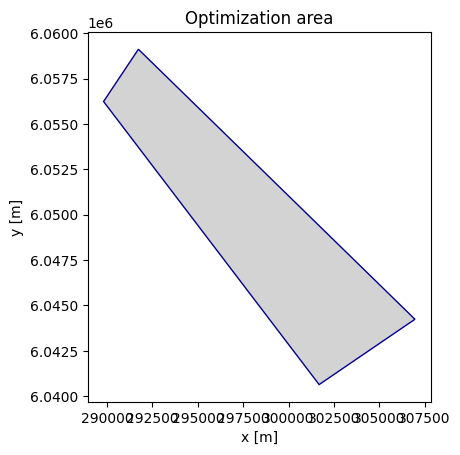

In [124]:
# geometrically optimized wind farm layout for the areas N-9.3

# area of interest N-9.3 boundaries
bounds_n93 = boundaries_from_dataframe(area_n93) # get the boundaries of the wind farm area

D_n93 = area_n93['D'][0]  # Diameter of the rotor

n_turbines_n93 = len(area_n93)  # Number of turbines

boundary_n93 = foxes.utils.geom2d.ClosedPolygon(bounds_n93) # create a closed polygon from the boundaries   

problem_n93 = grg.GeomRegGrid( # create a geometric regular grid problem
    boundary_n93,
    n_turbines=n_turbines_n93,  # the number of turbines to be placed 
    min_dist=3*D_n93,   # the minimal distance between turbines
    D=D_n93            # this avoids that rotor blades can reach out of area
)

problem_n93.add_objective(grg.MaxDensity(problem_n93, dfactor=2)) # maximize the density of turbines

problem_n93.add_constraint(grg.Valid(problem_n93)) # add a constraint to check if the turbines are inside the boundary
problem_n93.initialize() # initialize the problem

problem_n93.get_fig() # get the figure of the problem
plt.show()

Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: GA (GA)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: GA
  pop_size: 100
  seed: 42

Termination:
------------
  n_gen: 100

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      100 |  7.600000E+01 |  9.815000E+01 |             - |             -
     2 |      200 |  4.500000E+01 |  9.542000E+01 |             - |             -
     3 |      300 |  2.000000E+01 |  8.908000E+01 |             - |             -
     4 |      400 |  0.000000E+00 |  7.594000E+01 |  2.600939E+03 |  2.600939E+03
     5 |      500 |  0.000000E+00 |  5.373000E+01 |  4.499896E+03 |  2.238240E+03
     6 |      600 |  0.000000E+00 |  2.763000E+01 |  4.619341E+03 |  1.919886E+03
     7 |      700 |  0.000000E+00 |  7.2900000000 |  4.202485E+03 |  9.809190E+02
     8 |      800 |  0.000000E+00 |  0.0400000000 |  4.271497E+03 |  9.809190E+02
     9 |  

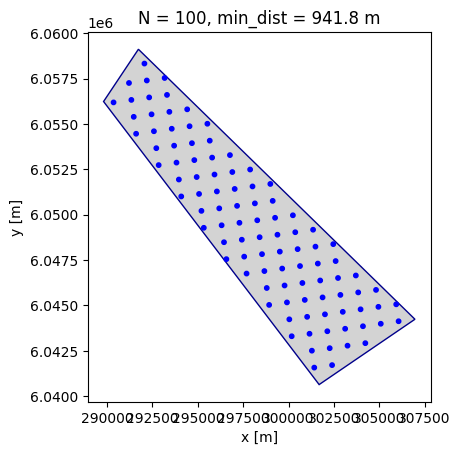

In [125]:
# Run the optimization

# selecting an optimizer. Here we pick the Genetic algorithm from `pymoo`,
# called [GA](https://pymoo.org/algorithms/soo/ga.html):
solver_n93 = Optimizer_pymoo( # create an optimizer
    problem_n93,
    problem_pars=dict(vectorize=True), # vectorize the problem
    algo_pars=dict( # the algorithm parameters
        type="GA",    # the type of the algorithm
        pop_size=100,  # the number of layouts per generation
        seed=42,       # the random seed, for reproducible results
    ),
    setup_pars=dict(), # the setup parameters of the optimization
    term_pars=dict(n_gen=100),  # the number of generations 
)
solver_n93.initialize() # initialize the solver
solver_n93.print_info() # print the information about the solver

# Run the optimization
results_n93 = solver_n93.solve() # solve the optimization problem
solver_n93.finalize(results_n93) # finalize the solver

# Plot the results
xy_n93, valid_n93 = results_n93.problem_results # get the results
problem_n93.get_fig(xy_n93, valid_n93) # plot the results
plt.show()

6. Calculate the yield of the areas N-9.1, N-9.2, N-9.3 without external effects. Use the long-term corrected ERA5 data as input.

In [126]:
# Fuction to convert wind speed to power
def wind_to_power(ws, power_curve):
    """
    Function to convert wind speed to power using a power curve.
    
    Parameters:
    ws (float): Wind speed in m/s
    power_curve (pd.DataFrame): Power curve with columns 'ws' for wind speed and 'power' for power
    
    Returns:
    float: Power in kW
    """
    # interpolate power curve
    power = np.interp(ws['ws100'], power_curve['ws'], power_curve['P'])
    return power

# Calculate power output for Lidar 1 and Lidar 2 using NREL 5MW power curve
power_lidar1_NREL = wind_to_power(corrected_era5_data_lidar1, power_curve_NREL_5MW)
power_lidar2_NREL = wind_to_power(corrected_era5_data_lidar2, power_curve_NREL_5MW)

# Calculate power output for Lidar 1 and Lidar 2 using IEA 15MW power curve
power_lidar1_IEA = wind_to_power(corrected_era5_data_lidar1, power_curve_IEA_15MW)
power_lidar2_IEA = wind_to_power(corrected_era5_data_lidar2, power_curve_IEA_15MW)

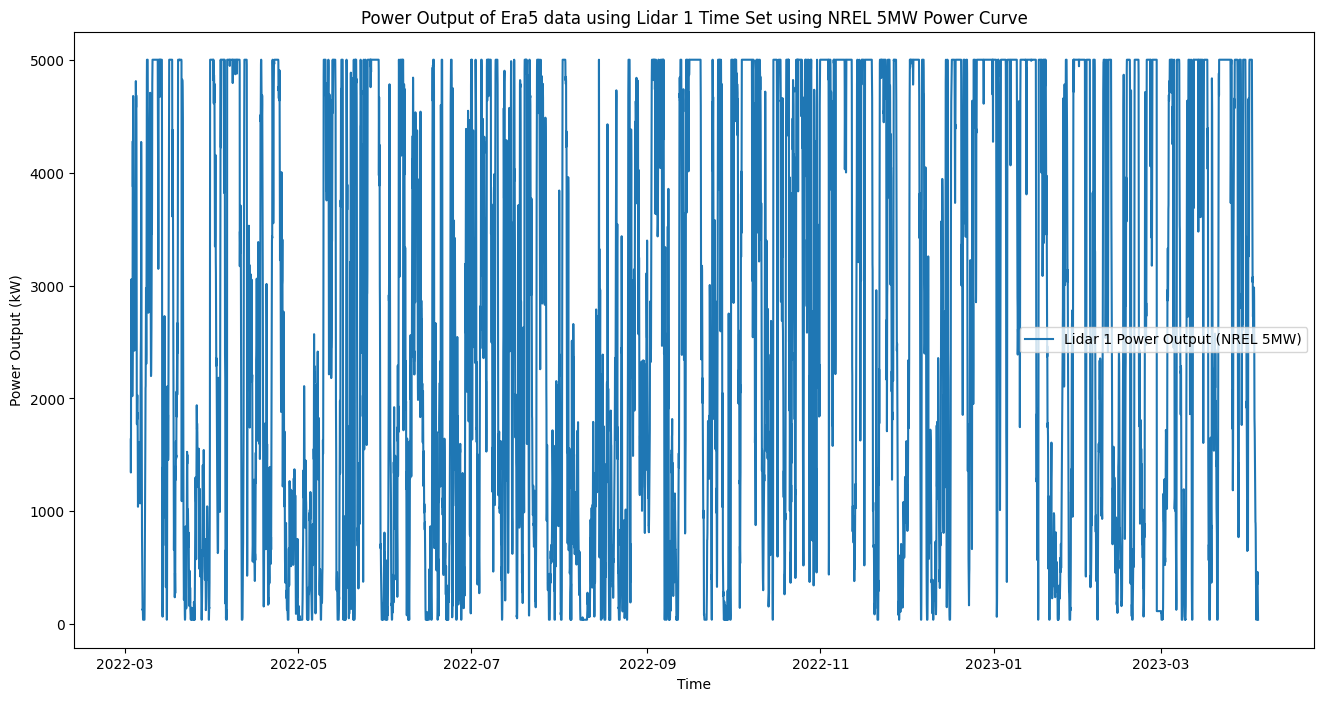

In [127]:
# plot the power output of lidar1 using NREL 5MW power curve
plt.figure(figsize=(16,8))
plt.plot(corrected_era5_data_lidar1.index,power_lidar1_NREL,label='Lidar 1 Power Output (NREL 5MW)')
plt.xlabel('Time')
plt.ylabel('Power Output (kW)')
plt.title('Power Output of Era5 data using Lidar 1 Time Set using NREL 5MW Power Curve')
plt.legend()
plt.show()

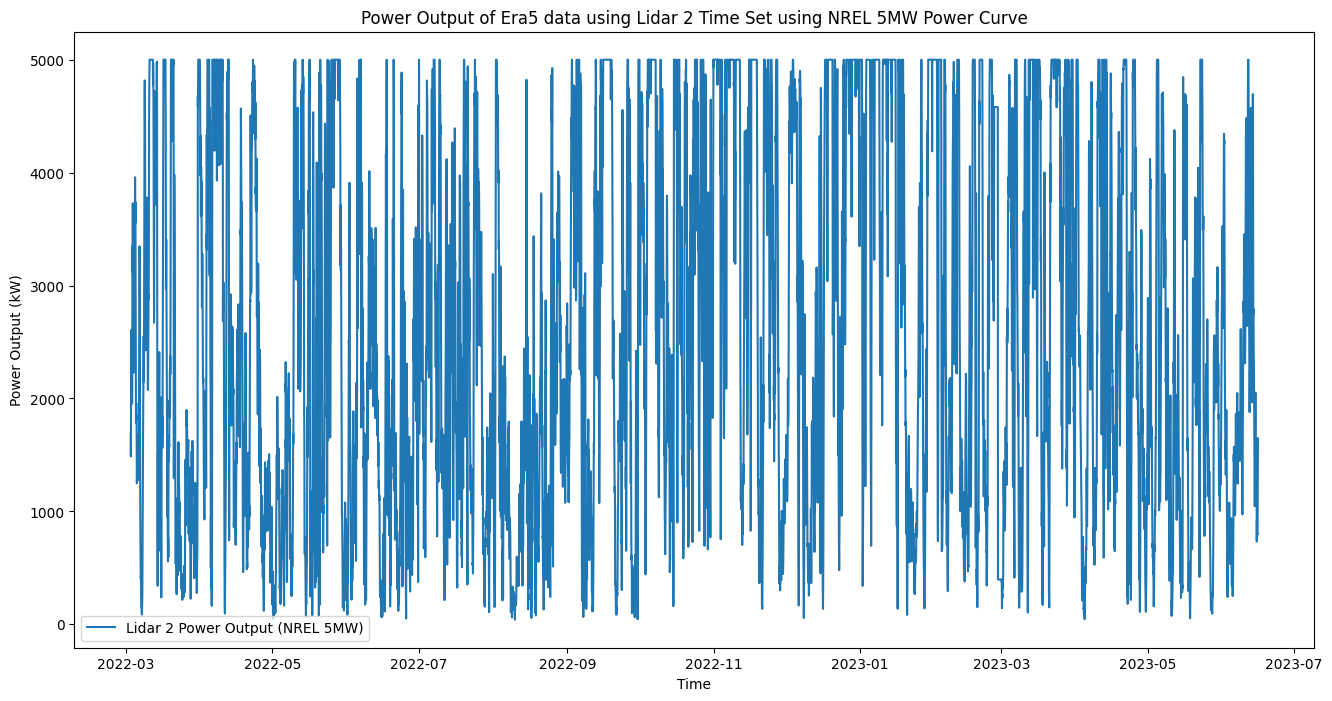

In [128]:
# plot the power output of lidar2 using NREL 5MW power curve
plt.figure(figsize=(16,8))
plt.plot(corrected_era5_data_lidar2.index,power_lidar2_NREL,label='Lidar 2 Power Output (NREL 5MW)')
plt.xlabel('Time')
plt.ylabel('Power Output (kW)')
plt.title('Power Output of Era5 data using Lidar 2 Time Set using NREL 5MW Power Curve')
plt.legend()
plt.show()

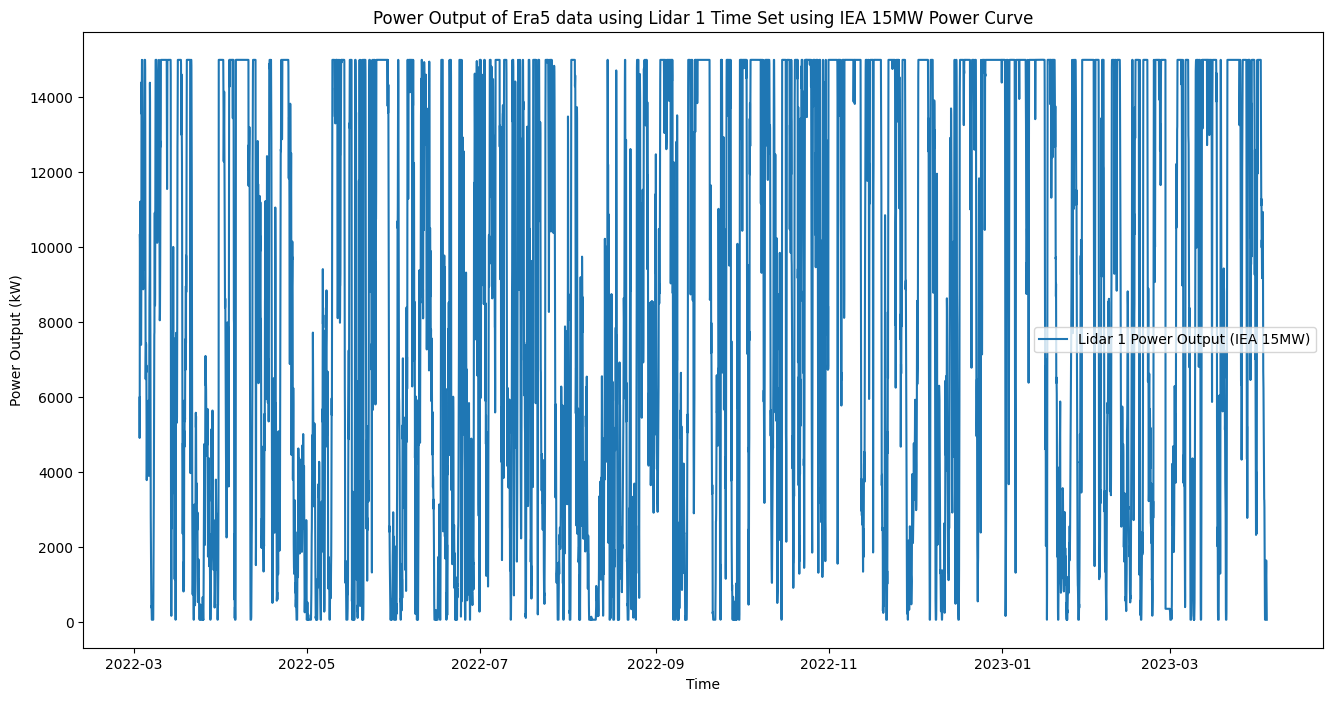

In [129]:
# plot the power output of lidar1 using IEA 15MW power curve
plt.figure(figsize=(16,8))
plt.plot(corrected_era5_data_lidar1.index,power_lidar1_IEA,label='Lidar 1 Power Output (IEA 15MW)')
plt.xlabel('Time')
plt.ylabel('Power Output (kW)')
plt.title('Power Output of Era5 data using Lidar 1 Time Set using IEA 15MW Power Curve')
plt.legend()
plt.show()

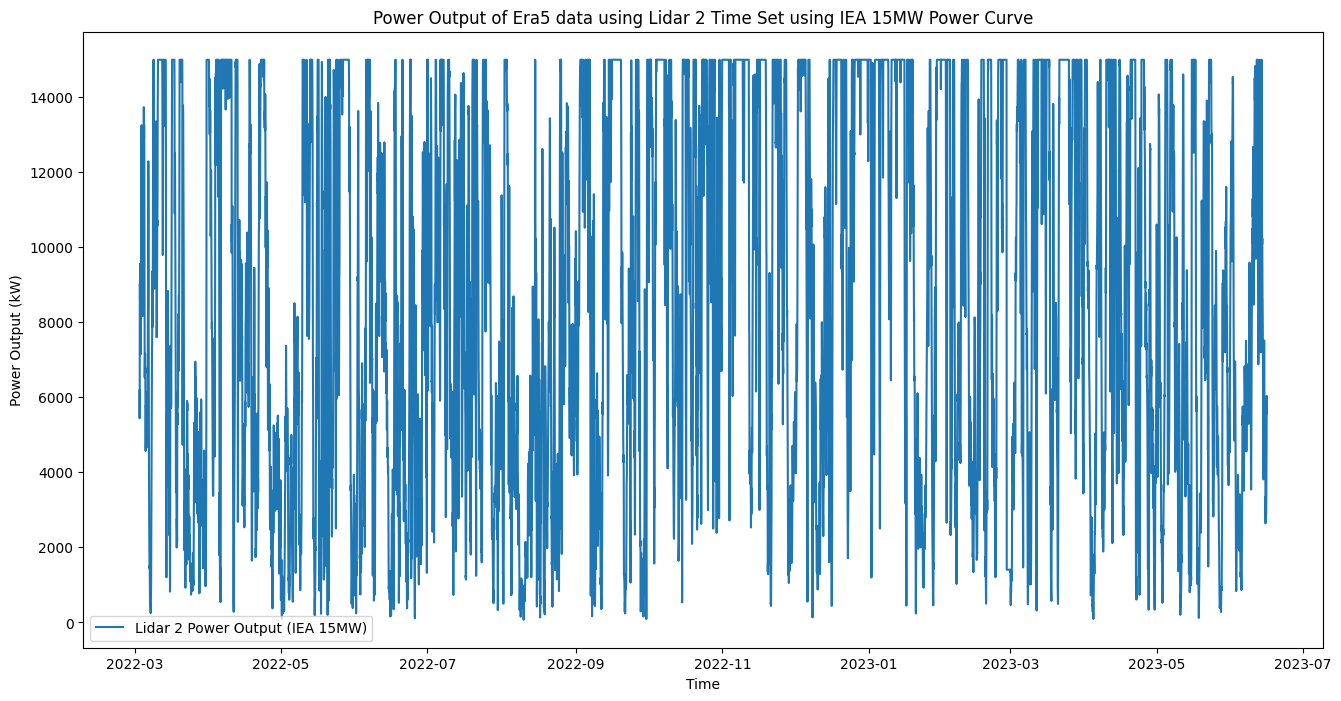

In [130]:
# plot the power output of lidar2 using IEA 15MW power curve
plt.figure(figsize=(16,8))
plt.plot(corrected_era5_data_lidar2.index,power_lidar2_IEA,label='Lidar 2 Power Output (IEA 15MW)')
plt.xlabel('Time')
plt.ylabel('Power Output (kW)')
plt.title('Power Output of Era5 data using Lidar 2 Time Set using IEA 15MW Power Curve')
plt.legend()
plt.show()

In [131]:
# Calculate monthly yield for Lidar 1 and Lidar 2 using NREL 5MW power curve (Used only @ 100m)

# Convert power_lidar1_NREL to a pandas DataFrame
df_power_lidar1_NREL = pd.DataFrame(power_lidar1_NREL, index=corrected_era5_data_lidar1.index, columns=['Power'])

# Resample the DataFrame to monthly frequency and calculate the sum
monthly_yield_lidar1_NREL = df_power_lidar1_NREL.resample('ME').sum() / 1000  # convert to MWh

print('Monthly Yield for of Era5 data using Lidar 1 Time Set using NREL 5MW Power Curve:')
print(monthly_yield_lidar1_NREL)
print()

# Convert power_lidar2_NREL to a pandas DataFrame
df_power_lidar2_NREL = pd.DataFrame(power_lidar2_NREL, index=corrected_era5_data_lidar2.index, columns=['Power'])

# Resample the DataFrame to monthly frequency and calculate the sum
monthly_yield_lidar2_NREL = df_power_lidar2_NREL.resample('ME').sum() / 1000  # convert to MWh

print('Monthly Yield for of Era5 data using Lidar 2 Time Set using NREL 5MW Power Curve:')
print(monthly_yield_lidar2_NREL)
print()


Monthly Yield for of Era5 data using Lidar 1 Time Set using NREL 5MW Power Curve:
                  Power
2022-03-31  1644.040044
2022-04-30  1984.909499
2022-05-31  1740.583985
2022-06-30  1346.591064
2022-07-31  1946.914456
2022-08-31  1146.804386
2022-09-30  2008.479032
2022-10-31  2595.610762
2022-11-30  2660.689560
2022-12-31  2535.205032
2023-01-31  2637.297877
2023-02-28  1915.812686
2023-03-31  2498.006790
2023-04-30   204.836831

Monthly Yield for of Era5 data using Lidar 2 Time Set using NREL 5MW Power Curve:
                  Power
2022-03-31  1605.952787
2022-04-30  1897.933129
2022-05-31  1684.805068
2022-06-30  1301.872047
2022-07-31  1789.249235
2022-08-31  1156.553356
2022-09-30  1892.244402
2022-10-31  2389.424960
2022-11-30  2553.170500
2022-12-31  2412.186082
2023-01-31  2558.806960
2023-02-28  1868.794968
2023-03-31  2370.045903
2023-04-30  1857.229624
2023-05-31  1554.685081
2023-06-30   729.817956



In [132]:
# Calculate monthly yield for Lidar 1 and Lidar 2 using IEA 15MW power curve

# Convert power_lidar1_IEA to a pandas DataFrame
df_power_lidar1_IEA = pd.DataFrame(power_lidar1_IEA, index=corrected_era5_data_lidar1.index, columns=['Power'])

# Resample the DataFrame to monthly frequency and calculate the sum
monthly_yield_lidar1_IEA = df_power_lidar1_IEA.resample('ME').sum() / 1000  # convert to MWh

print('Monthly Yield for Era5 data using Lidar 1 Time Set using IEA 15MW Power Curve:')
print(monthly_yield_lidar1_IEA)
print()

# Convert power_lidar2_IEA to a pandas DataFrame
df_power_lidar2_IEA = pd.DataFrame(power_lidar2_IEA, index=corrected_era5_data_lidar2.index, columns=['Power'])

# Resample the DataFrame to monthly frequency and calculate the sum
monthly_yield_lidar2_IEA = df_power_lidar2_IEA.resample('ME').sum() / 1000  # convert to MWh

print('Monthly Yield for of Era5 data using Lidar 2 Time Set using IEA 15MW Power Curve:')
print(monthly_yield_lidar2_IEA)
print()

Monthly Yield for Era5 data using Lidar 1 Time Set using IEA 15MW Power Curve:
                  Power
2022-03-31  5387.139667
2022-04-30  6460.895613
2022-05-31  5630.230295
2022-06-30  4639.538384
2022-07-31  6582.832730
2022-08-31  3965.036436
2022-09-30  6487.823671
2022-10-31  8375.319157
2022-11-30  8313.856968
2022-12-31  8029.862846
2023-01-31  8248.740888
2023-02-28  6104.879947
2023-03-31  7924.807345
2023-04-30   669.563916

Monthly Yield for of Era5 data using Lidar 2 Time Set using IEA 15MW Power Curve:
                  Power
2022-03-31  5427.145170
2022-04-30  6383.645892
2022-05-31  5674.964983
2022-06-30  4630.565961
2022-07-31  6289.257716
2022-08-31  4121.856976
2022-09-30  6354.131657
2022-10-31  8017.135610
2022-11-30  8178.525074
2022-12-31  7888.645329
2023-01-31  8162.531976
2023-02-28  6140.412656
2023-03-31  7760.355994
2023-04-30  6303.350631
2023-05-31  5453.096758
2023-06-30  2610.703156



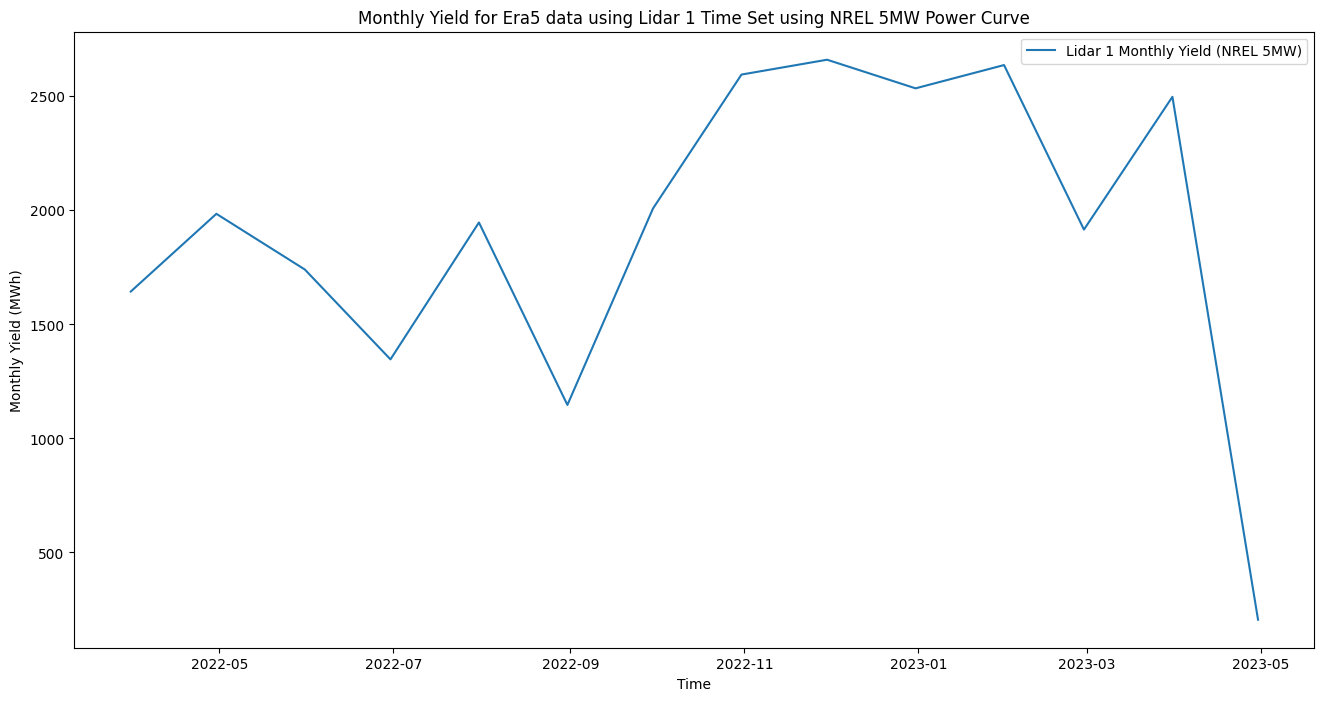

In [133]:
# Plot the monthly yield for Lidar 1 using NREL 5MW power curve
plt.figure(figsize=(16,8))
plt.plot(monthly_yield_lidar1_NREL.index, monthly_yield_lidar1_NREL['Power'], label='Lidar 1 Monthly Yield (NREL 5MW)')
plt.xlabel('Time')
plt.ylabel('Monthly Yield (MWh)')
plt.title('Monthly Yield for Era5 data using Lidar 1 Time Set using NREL 5MW Power Curve')
plt.legend()
plt.show()

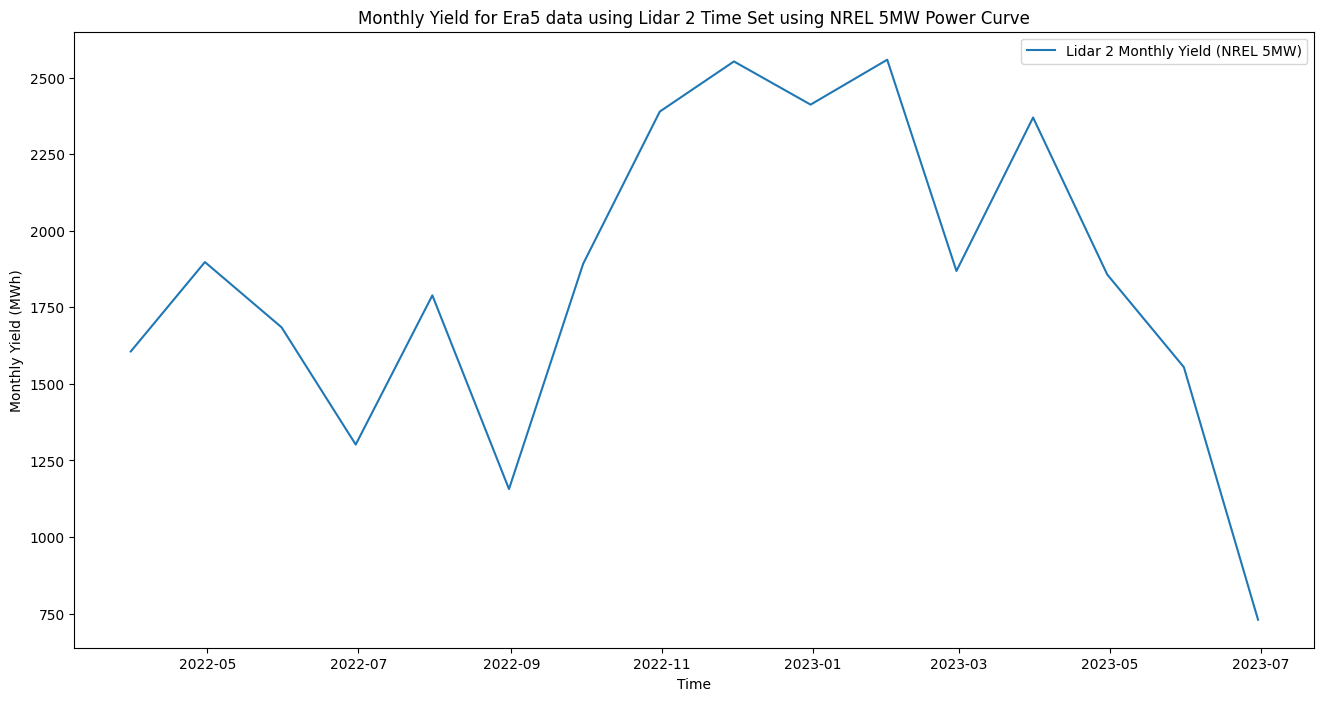

In [134]:
# Plot the monthly yield for Lidar 2 using NREL 5MW power curve
plt.figure(figsize=(16,8))
plt.plot(monthly_yield_lidar2_NREL.index, monthly_yield_lidar2_NREL['Power'], label='Lidar 2 Monthly Yield (NREL 5MW)')
plt.xlabel('Time')
plt.ylabel('Monthly Yield (MWh)')
plt.title('Monthly Yield for Era5 data using Lidar 2 Time Set using NREL 5MW Power Curve')
plt.legend()
plt.show()

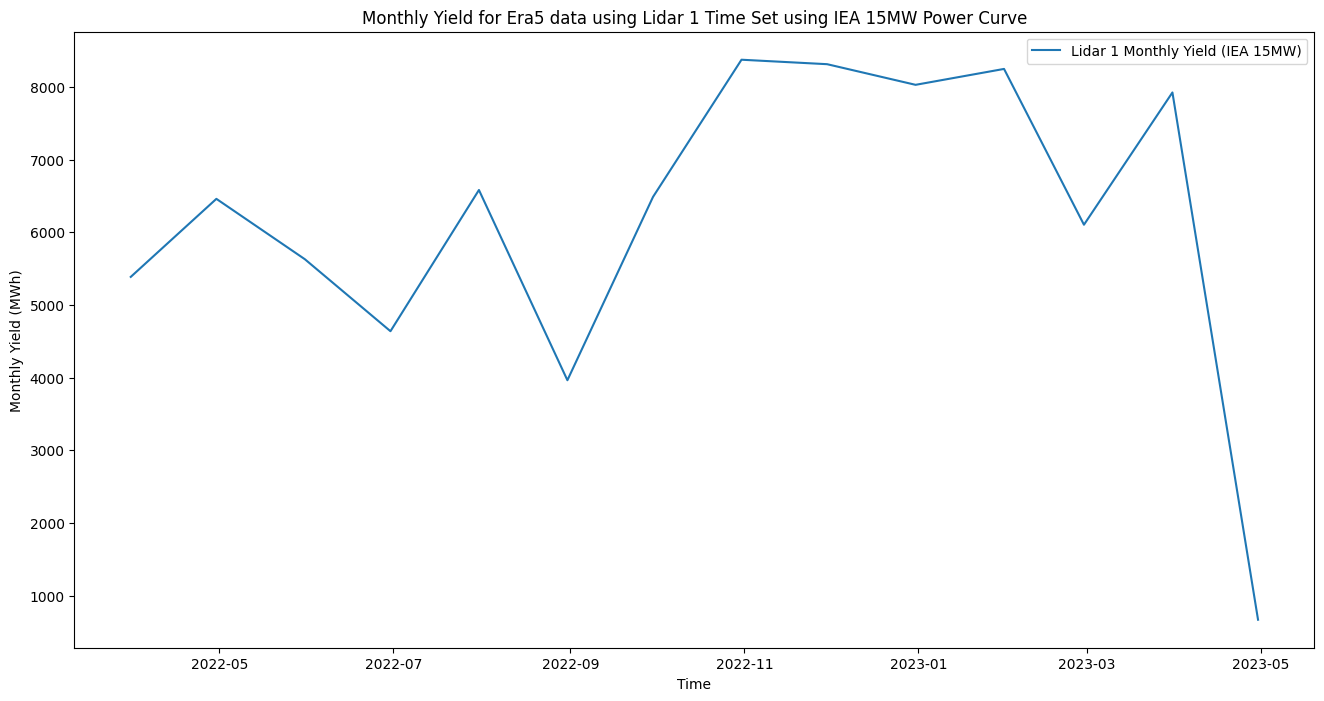

In [135]:
# Plot the monthly yield for Lidar 1 using IEA 15MW power curve
plt.figure(figsize=(16,8))
plt.plot(monthly_yield_lidar1_IEA.index, monthly_yield_lidar1_IEA['Power'], label='Lidar 1 Monthly Yield (IEA 15MW)')
plt.xlabel('Time')
plt.ylabel('Monthly Yield (MWh)')
plt.title('Monthly Yield for Era5 data using Lidar 1 Time Set using IEA 15MW Power Curve')
plt.legend()
plt.show()

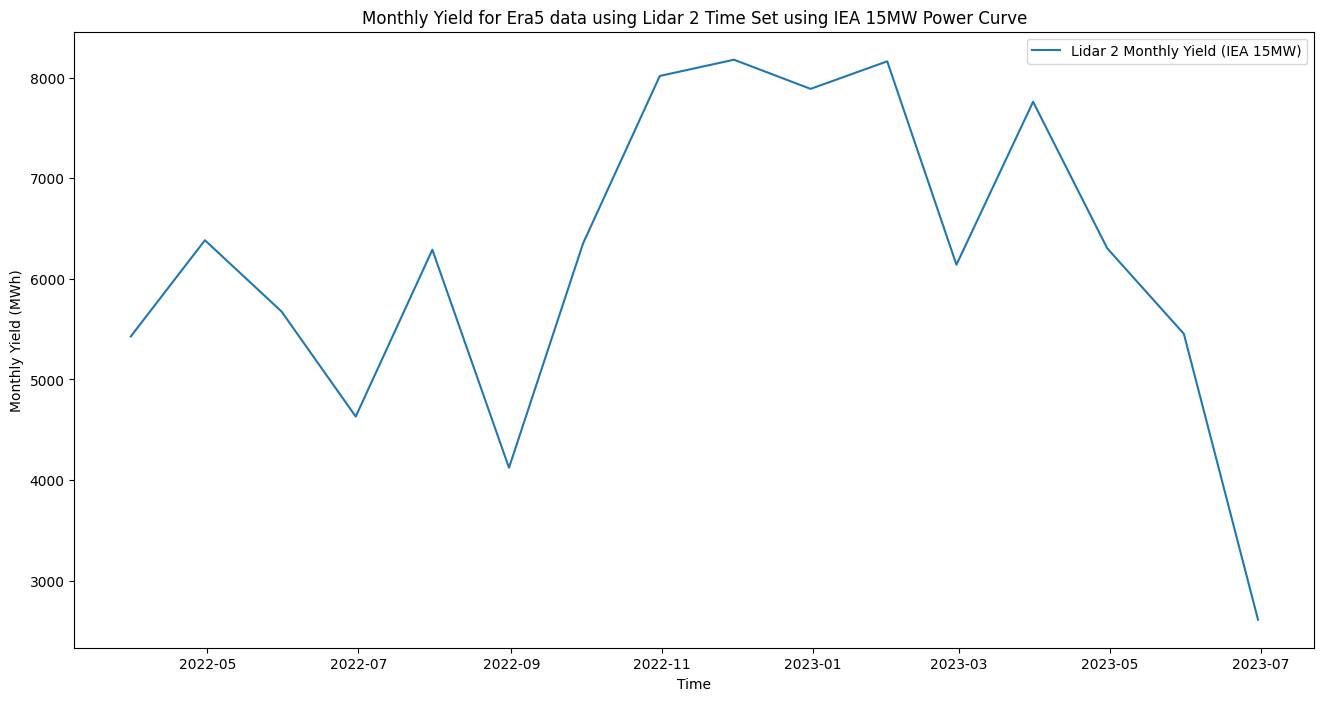

In [136]:
# Plot the monthly yield for Lidar 2 using IEA 15MW power curve
plt.figure(figsize=(16,8))
plt.plot(monthly_yield_lidar2_IEA.index, monthly_yield_lidar2_IEA['Power'], label='Lidar 2 Monthly Yield (IEA 15MW)')
plt.xlabel('Time')
plt.ylabel('Monthly Yield (MWh)')
plt.title('Monthly Yield for Era5 data using Lidar 2 Time Set using IEA 15MW Power Curve')
plt.legend()
plt.show()

In [137]:
# Area N-9.1 Yield Calculation

# No of turbines in area N-9.1
n_turbines_n91 = len(area_n91)

# Calculate the total power output for area N-9.1 using NREL 5MW power curve
# Multiply the monthly yield by the number of turbines using NREL 5MW power curve and IEA 15MW power curve
total_monthly_yield_n91_NREL_lidar1time = monthly_yield_lidar1_NREL * n_turbines_n91
total_monthly_yield_n91_IEA_lidar1time = monthly_yield_lidar1_IEA * n_turbines_n91
total_monthly_yield_n91_NREL_lidar2time = monthly_yield_lidar2_NREL * n_turbines_n91
total_monthly_yield_n91_IEA_lidar2time = monthly_yield_lidar2_IEA * n_turbines_n91


print('Total Monthly Yield for Area N-9.1 using NREL 5MW Power Curve and Lidar 1 Time Set:')
print(total_monthly_yield_n91_NREL_lidar1time)
print()

print('Total Monthly Yield for Area N-9.1 using IEA 15MW Power Curve and Lidar 1 Time Set:')
print(total_monthly_yield_n91_IEA_lidar1time)
print()

print('Total Monthly Yield for Area N-9.1 using NREL 5MW Power Curve and Lidar 2 Time Set:')
print(total_monthly_yield_n91_NREL_lidar2time)
print()

print('Total Monthly Yield for Area N-9.1 using IEA 15MW Power Curve and Lidar 2 Time Set:')
print(total_monthly_yield_n91_IEA_lidar2time)
print()

Total Monthly Yield for Area N-9.1 using NREL 5MW Power Curve and Lidar 1 Time Set:
                    Power
2022-03-31  218657.325791
2022-04-30  263992.963370
2022-05-31  231497.669999
2022-06-30  179096.611490
2022-07-31  258939.622680
2022-08-31  152524.983322
2022-09-30  267127.711197
2022-10-31  345216.231292
2022-11-30  353871.711424
2022-12-31  337182.269218
2023-01-31  350760.617676
2023-02-28  254803.087302
2023-03-31  332234.903123
2023-04-30   27243.298538

Total Monthly Yield for Area N-9.1 using IEA 15MW Power Curve and Lidar 1 Time Set:
                   Power
2022-03-31  7.164896e+05
2022-04-30  8.592991e+05
2022-05-31  7.488206e+05
2022-06-30  6.170586e+05
2022-07-31  8.755168e+05
2022-08-31  5.273498e+05
2022-09-30  8.628805e+05
2022-10-31  1.113917e+06
2022-11-30  1.105743e+06
2022-12-31  1.067972e+06
2023-01-31  1.097083e+06
2023-02-28  8.119490e+05
2023-03-31  1.053999e+06
2023-04-30  8.905200e+04

Total Monthly Yield for Area N-9.1 using NREL 5MW Power Curve and

In [138]:
# Area N-9.2 Yield Calculation

# No of turbines in area N-9.2
n_turbines_n92 = len(area_n92)

# Calculate the total power output for area N-9.2 using NREL 5MW power curve and IEA 15MW power curve
total_monthly_yield_n92_NREL_lidar1time = monthly_yield_lidar1_NREL * n_turbines_n92
total_monthly_yield_n92_IEA_lidar1time = monthly_yield_lidar1_IEA * n_turbines_n92
total_monthly_yield_n92_NREL_lidar2time = monthly_yield_lidar2_NREL * n_turbines_n92
total_monthly_yield_n92_IEA_lidar2time = monthly_yield_lidar2_IEA * n_turbines_n92

print('Total Monthly Yield for Area N-9.2 using NREL 5MW Power Curve and Lidar 1 Time Set:')
print(total_monthly_yield_n92_NREL_lidar1time)
print()

print('Total Monthly Yield for Area N-9.2 using IEA 15MW Power Curve and Lidar 1 Time Set:')
print(total_monthly_yield_n92_IEA_lidar1time)
print()

print('Total Monthly Yield for Area N-9.2 using NREL 5MW Power Curve and Lidar 2 Time Set:')
print(total_monthly_yield_n92_NREL_lidar2time)
print()

print('Total Monthly Yield for Area N-9.2 using IEA 15MW Power Curve and Lidar 2 Time Set:')
print(total_monthly_yield_n92_IEA_lidar2time)
print()

Total Monthly Yield for Area N-9.2 using NREL 5MW Power Curve and Lidar 1 Time Set:
                    Power
2022-03-31  218657.325791
2022-04-30  263992.963370
2022-05-31  231497.669999
2022-06-30  179096.611490
2022-07-31  258939.622680
2022-08-31  152524.983322
2022-09-30  267127.711197
2022-10-31  345216.231292
2022-11-30  353871.711424
2022-12-31  337182.269218
2023-01-31  350760.617676
2023-02-28  254803.087302
2023-03-31  332234.903123
2023-04-30   27243.298538

Total Monthly Yield for Area N-9.2 using IEA 15MW Power Curve and Lidar 1 Time Set:
                   Power
2022-03-31  7.164896e+05
2022-04-30  8.592991e+05
2022-05-31  7.488206e+05
2022-06-30  6.170586e+05
2022-07-31  8.755168e+05
2022-08-31  5.273498e+05
2022-09-30  8.628805e+05
2022-10-31  1.113917e+06
2022-11-30  1.105743e+06
2022-12-31  1.067972e+06
2023-01-31  1.097083e+06
2023-02-28  8.119490e+05
2023-03-31  1.053999e+06
2023-04-30  8.905200e+04

Total Monthly Yield for Area N-9.2 using NREL 5MW Power Curve and

In [139]:
# Area N-9.3 Yield Calculation

# No of turbines in area N-9.3
n_turbines_n93 = len(area_n93)

# Calculate the total power output for area N-9.3 using NREL 5MW power curve and IEA 15MW power curve
total_monthly_yield_n93_NREL_lidar1time = monthly_yield_lidar1_NREL * n_turbines_n93
total_monthly_yield_n93_IEA_lidar1time = monthly_yield_lidar1_IEA * n_turbines_n93
total_monthly_yield_n93_NREL_lidar2time = monthly_yield_lidar2_NREL * n_turbines_n93
total_monthly_yield_n93_IEA_lidar2time = monthly_yield_lidar2_IEA * n_turbines_n93

print('Total Monthly Yield for Area N-9.3 using NREL 5MW Power Curve and Lidar 1 Time Set:')
print(total_monthly_yield_n93_NREL_lidar1time)
print()

print('Total Monthly Yield for Area N-9.3 using IEA 15MW Power Curve and Lidar 1 Time Set:')
print(total_monthly_yield_n93_IEA_lidar1time)
print()

print('Total Monthly Yield for Area N-9.3 using NREL 5MW Power Curve and Lidar 2 Time Set:')
print(total_monthly_yield_n93_NREL_lidar2time)
print()

print('Total Monthly Yield for Area N-9.3 using IEA 15MW Power Curve and Lidar 2 Time Set:')
print(total_monthly_yield_n93_IEA_lidar2time)
print()

Total Monthly Yield for Area N-9.3 using NREL 5MW Power Curve and Lidar 1 Time Set:
                    Power
2022-03-31  164404.004354
2022-04-30  198490.949903
2022-05-31  174058.398496
2022-06-30  134659.106384
2022-07-31  194691.445624
2022-08-31  114680.438588
2022-09-30  200847.903156
2022-10-31  259561.076160
2022-11-30  266068.955958
2022-12-31  253520.503171
2023-01-31  263729.787726
2023-02-28  191581.268648
2023-03-31  249800.679040
2023-04-30   20483.683111

Total Monthly Yield for Area N-9.3 using IEA 15MW Power Curve and Lidar 1 Time Set:
                    Power
2022-03-31  538713.966703
2022-04-30  646089.561308
2022-05-31  563023.029501
2022-06-30  463953.838442
2022-07-31  658283.272976
2022-08-31  396503.643563
2022-09-30  648782.367074
2022-10-31  837531.915667
2022-11-30  831385.696814
2022-12-31  802986.284564
2023-01-31  824874.088786
2023-02-28  610487.994745
2023-03-31  792480.734450
2023-04-30   66956.391635

Total Monthly Yield for Area N-9.3 using NREL 5MW 

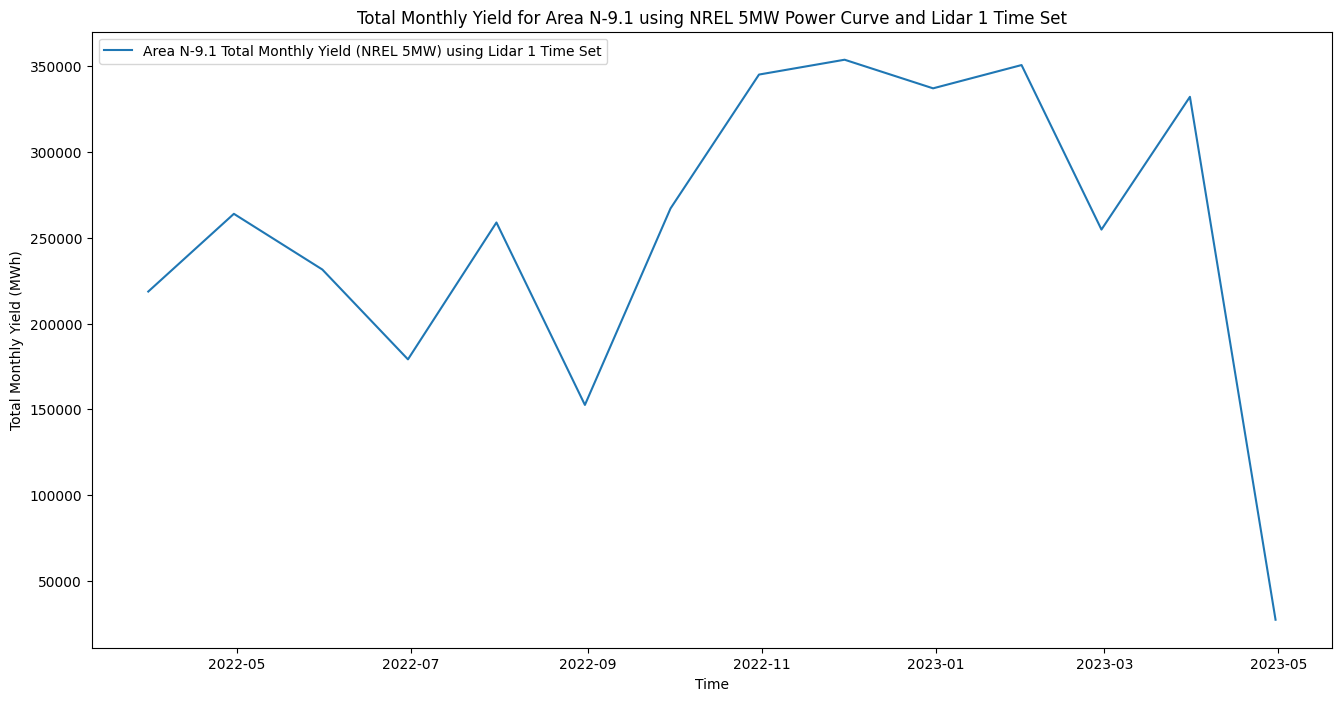

In [140]:
# Plot the total monthly yield for area N-9.1 using NREL 5MW power curve and Lidar 1 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n91_NREL_lidar1time.index, total_monthly_yield_n91_NREL_lidar1time['Power'], label='Area N-9.1 Total Monthly Yield (NREL 5MW) using Lidar 1 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.1 using NREL 5MW Power Curve and Lidar 1 Time Set')
plt.legend()
plt.show()

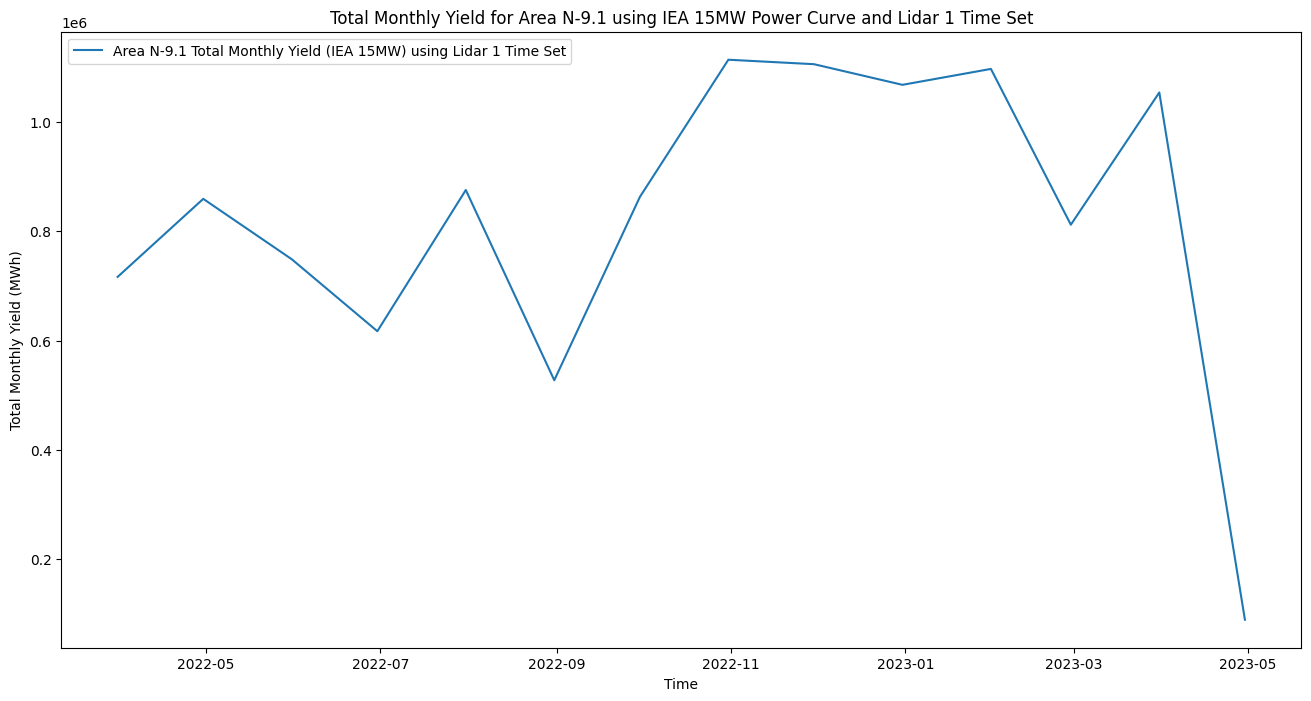

In [141]:
# Plot the total monthly yield for area N-9.1 using IEA 15MW power curveand Lidar 1 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n91_IEA_lidar1time.index, total_monthly_yield_n91_IEA_lidar1time['Power'], label='Area N-9.1 Total Monthly Yield (IEA 15MW) using Lidar 1 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.1 using IEA 15MW Power Curve and Lidar 1 Time Set')
plt.legend()
plt.show()

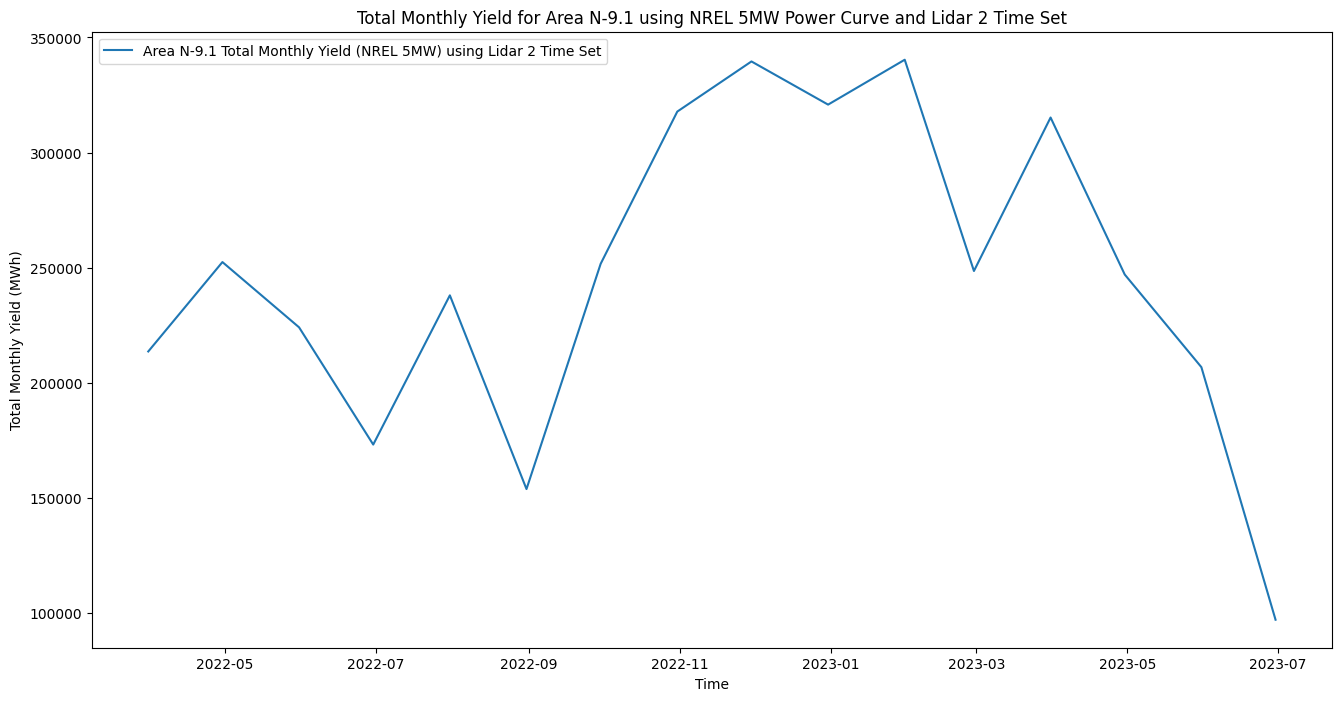

In [142]:
# Plot the total monthly yield for area N-9.1 using NREL 5MW power curve and Lidar 2 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n91_NREL_lidar2time.index, total_monthly_yield_n91_NREL_lidar2time['Power'], label='Area N-9.1 Total Monthly Yield (NREL 5MW) using Lidar 2 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.1 using NREL 5MW Power Curve and Lidar 2 Time Set')
plt.legend()
plt.show()

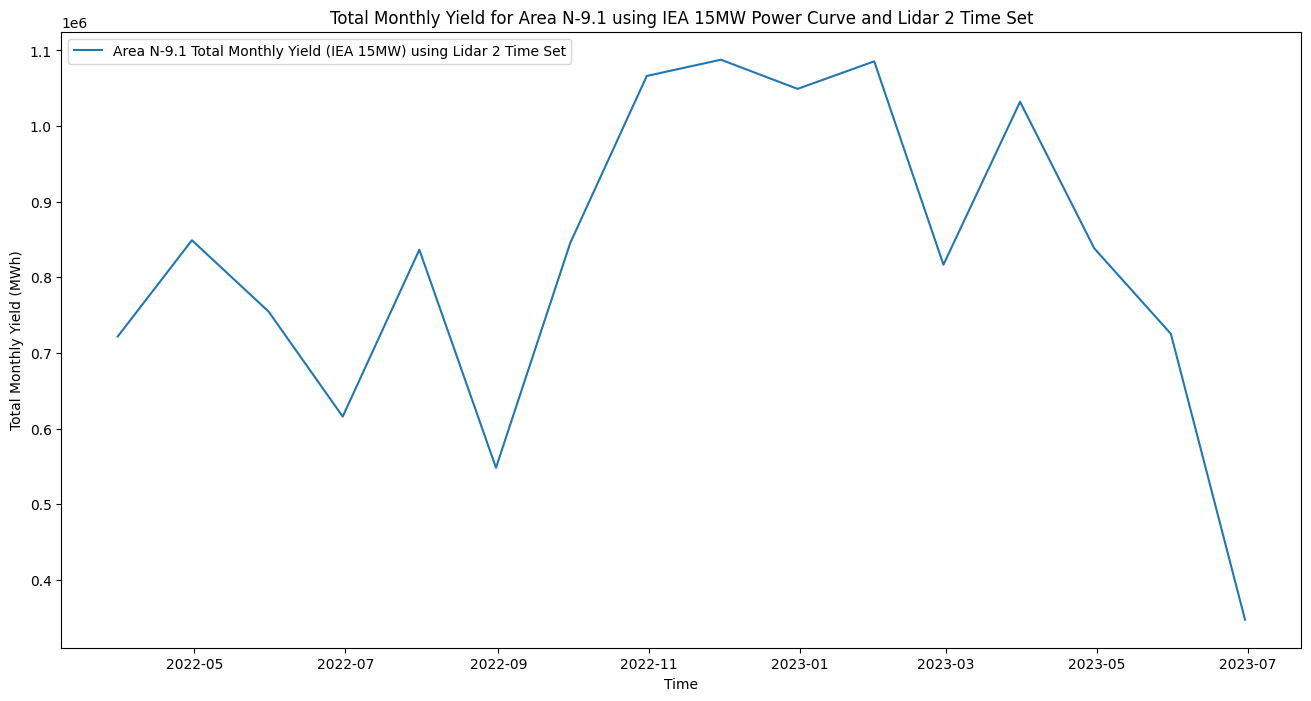

In [143]:
# Plot the total monthly yield for area N-9.1 using IEA 15MW power curve and Lidar 2 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n91_IEA_lidar2time.index, total_monthly_yield_n91_IEA_lidar2time['Power'], label='Area N-9.1 Total Monthly Yield (IEA 15MW) using Lidar 2 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.1 using IEA 15MW Power Curve and Lidar 2 Time Set')
plt.legend()
plt.show()

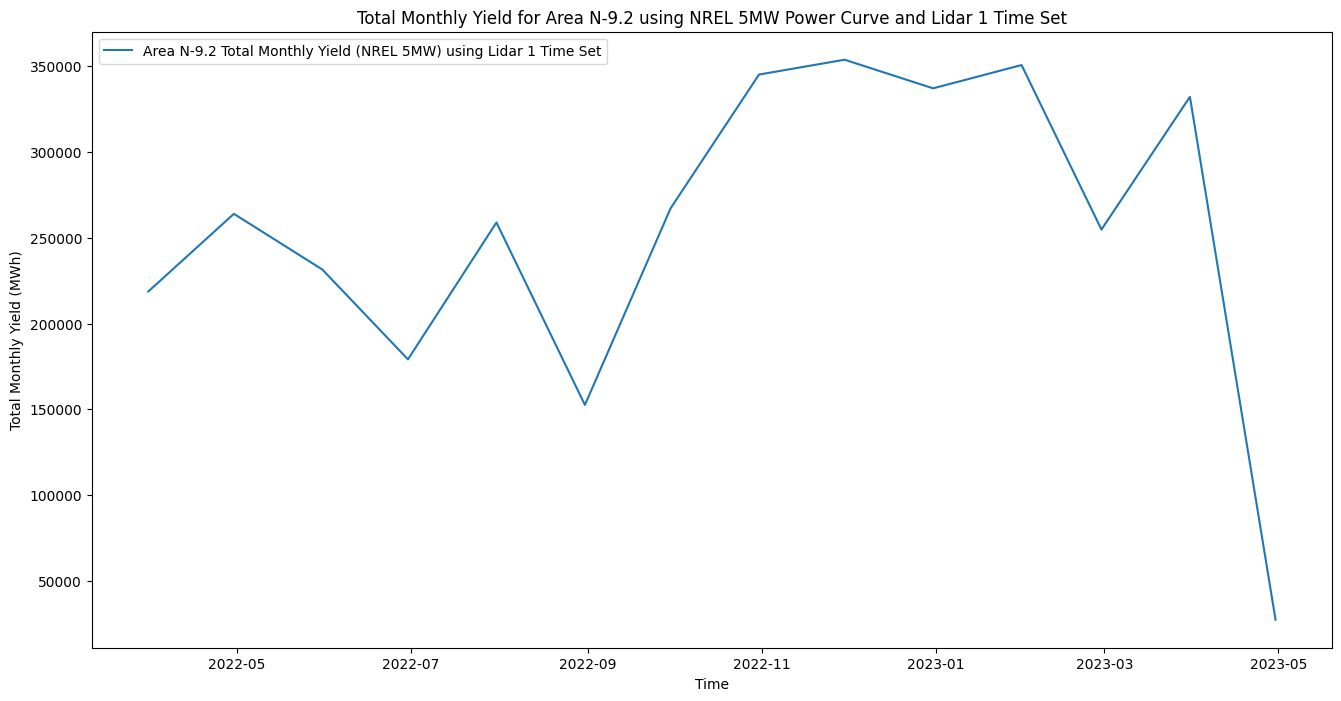

In [144]:
# Plot the total monthly yield for area N-9.2 using NREL 5MW power curve and Lidar 1 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n92_NREL_lidar1time.index, total_monthly_yield_n92_NREL_lidar1time['Power'], label='Area N-9.2 Total Monthly Yield (NREL 5MW) using Lidar 1 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.2 using NREL 5MW Power Curve and Lidar 1 Time Set')
plt.legend()
plt.show()

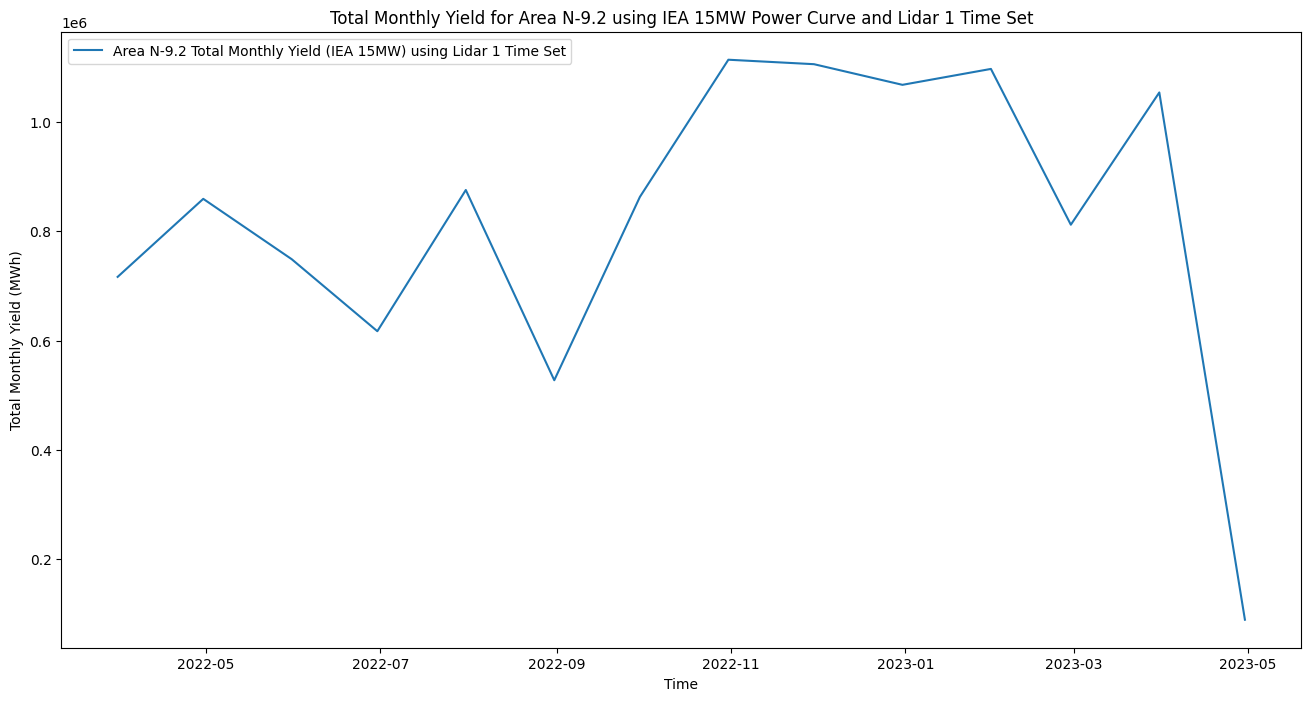

In [145]:
# Plot the total monthly yield for area N-9.2 using IEA 15MW power curve and Lidar 1 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n92_IEA_lidar1time.index, total_monthly_yield_n92_IEA_lidar1time['Power'], label='Area N-9.2 Total Monthly Yield (IEA 15MW) using Lidar 1 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.2 using IEA 15MW Power Curve and Lidar 1 Time Set')
plt.legend()
plt.show()

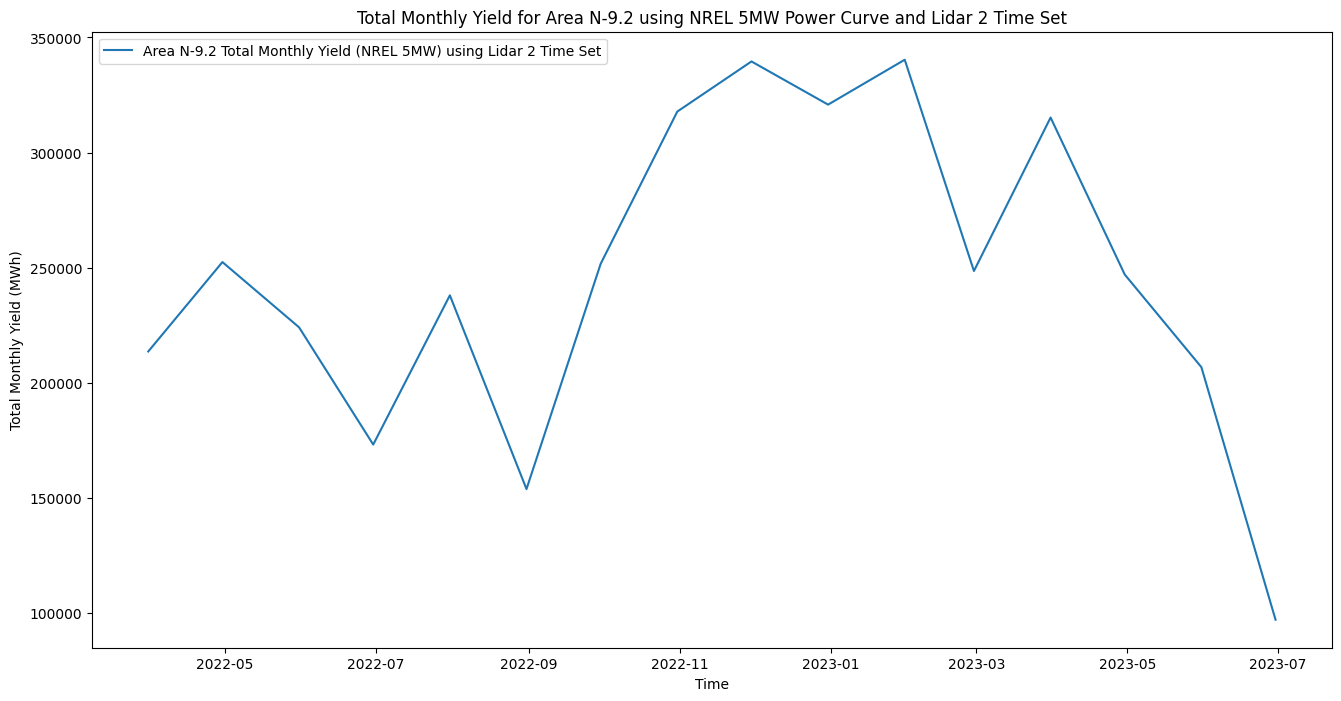

In [146]:
# Plot the total monthly yield for area N-9.2 using NREL 5MW power curve and Lidar 2 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n92_NREL_lidar2time.index, total_monthly_yield_n92_NREL_lidar2time['Power'], label='Area N-9.2 Total Monthly Yield (NREL 5MW) using Lidar 2 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.2 using NREL 5MW Power Curve and Lidar 2 Time Set')
plt.legend()
plt.show()

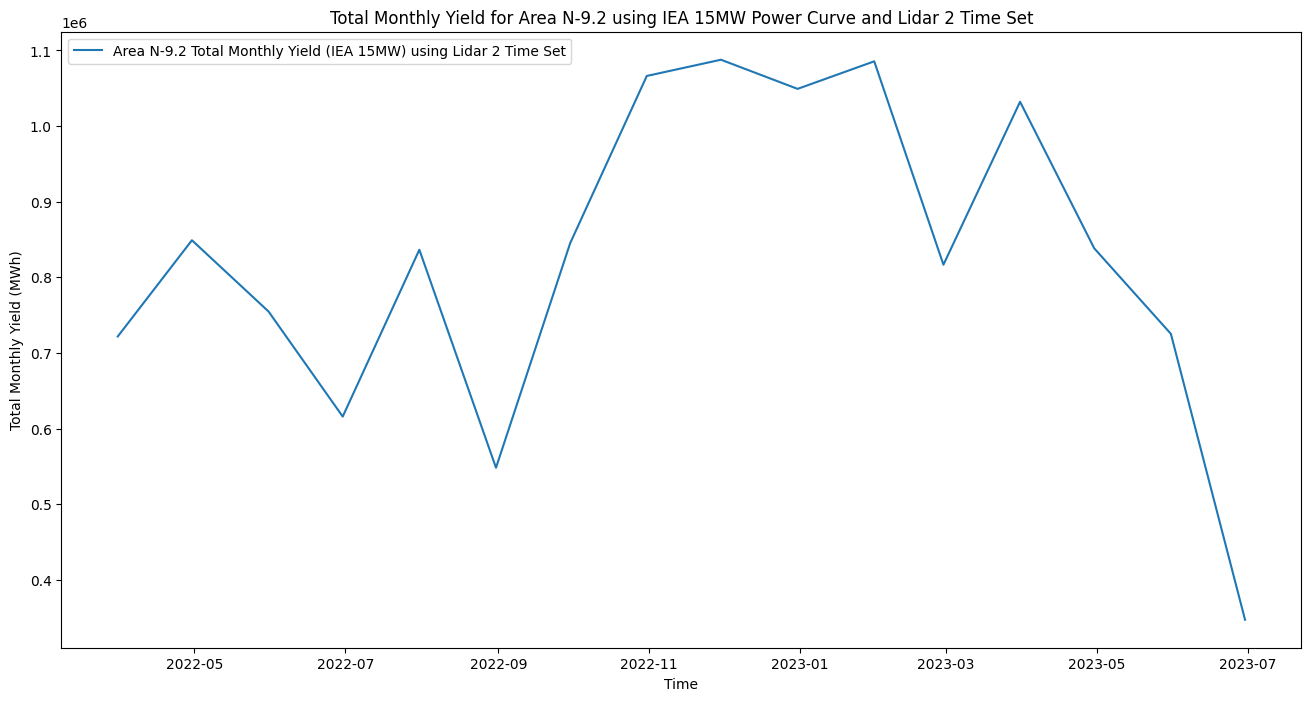

In [147]:
# Plot the total monthly yield for area N-9.2 using IEA 15MW power curve and Lidar 2 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n92_IEA_lidar2time.index, total_monthly_yield_n92_IEA_lidar2time['Power'], label='Area N-9.2 Total Monthly Yield (IEA 15MW) using Lidar 2 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.2 using IEA 15MW Power Curve and Lidar 2 Time Set')
plt.legend()
plt.show()

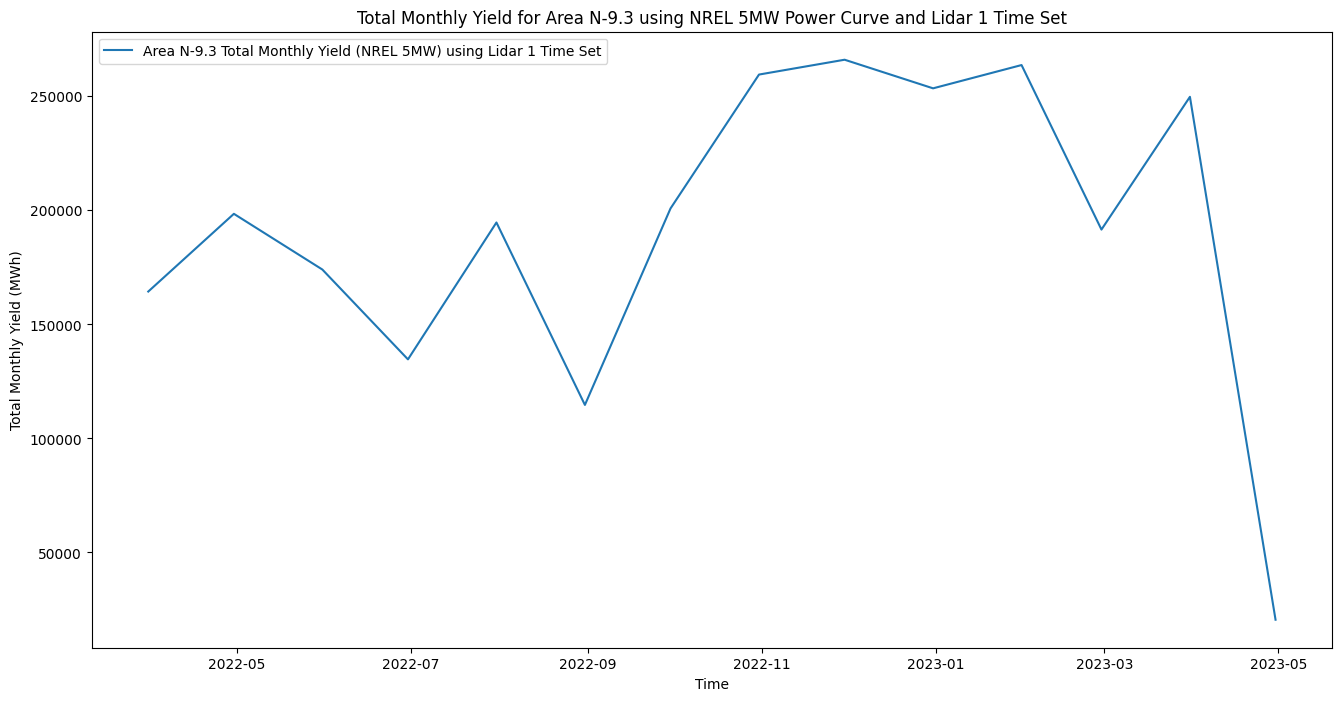

In [148]:
# Plot the total monthly yield for area N-9.3 using NREL 5MW power curve and Lidar 1 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n93_NREL_lidar1time.index, total_monthly_yield_n93_NREL_lidar1time['Power'], label='Area N-9.3 Total Monthly Yield (NREL 5MW) using Lidar 1 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.3 using NREL 5MW Power Curve and Lidar 1 Time Set')
plt.legend()
plt.show()

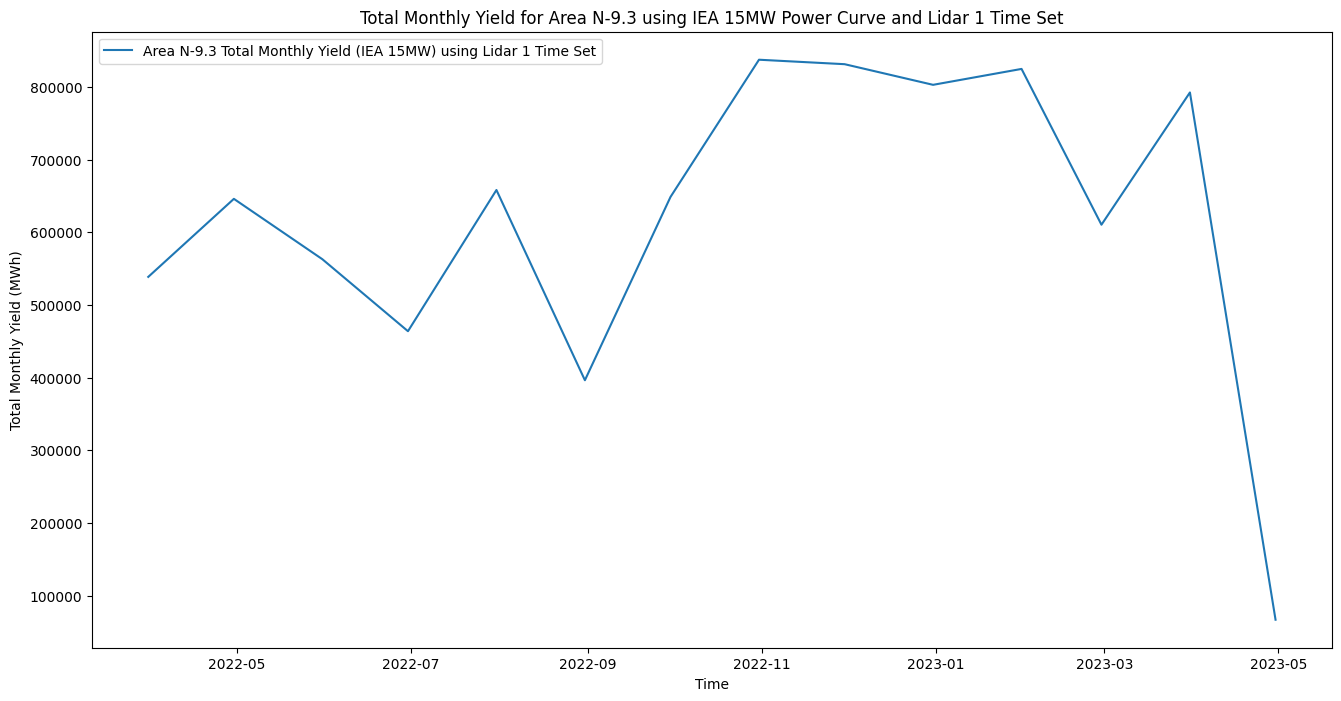

In [149]:
# Plot the total monthly yield for area N-9.3 using IEA 15MW power curve and Lidar 1 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n93_IEA_lidar1time.index, total_monthly_yield_n93_IEA_lidar1time['Power'], label='Area N-9.3 Total Monthly Yield (IEA 15MW) using Lidar 1 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.3 using IEA 15MW Power Curve and Lidar 1 Time Set')
plt.legend()
plt.show()

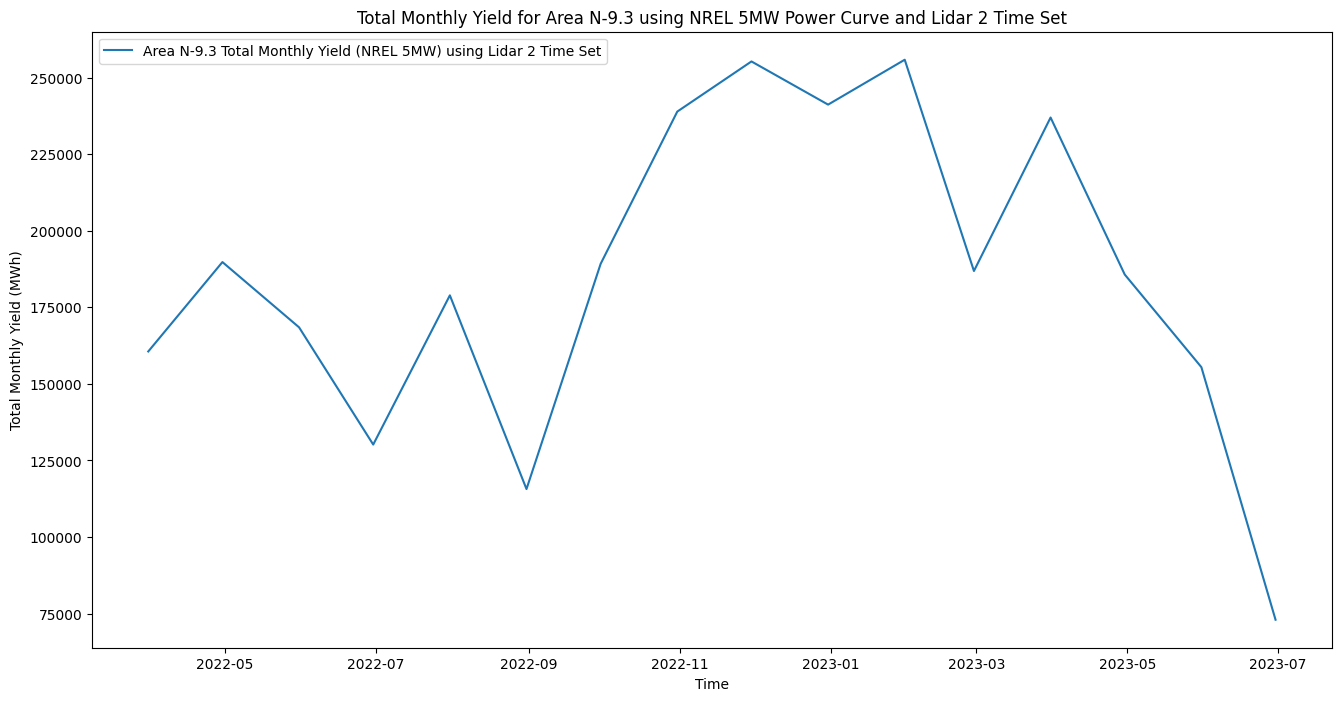

In [150]:
# Plot the total monthly yield for area N-9.3 using NREL 5MW power curve and Lidar 2 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n93_NREL_lidar2time.index, total_monthly_yield_n93_NREL_lidar2time['Power'], label='Area N-9.3 Total Monthly Yield (NREL 5MW) using Lidar 2 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.3 using NREL 5MW Power Curve and Lidar 2 Time Set')
plt.legend()
plt.show()

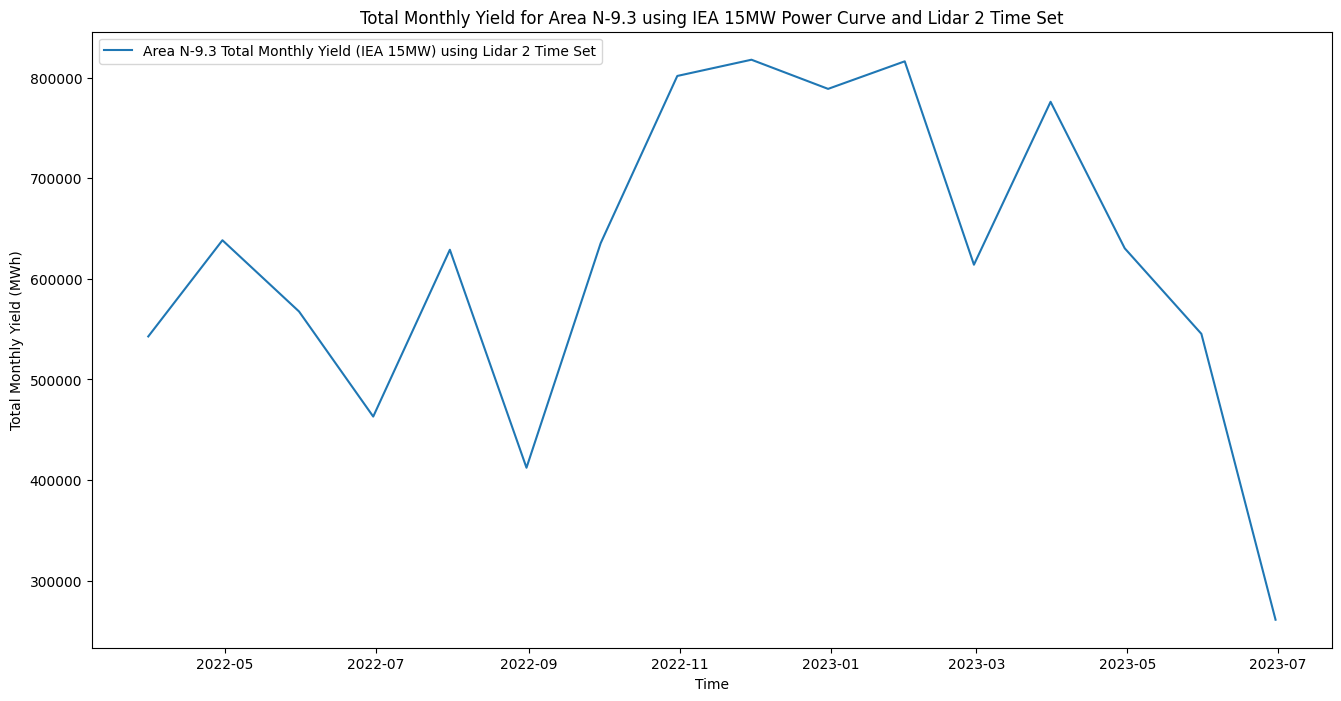

In [151]:
# Plot the total monthly yield for area N-9.3 using IEA 15MW power curve and Lidar 2 Time Set
plt.figure(figsize=(16,8))
plt.plot(total_monthly_yield_n93_IEA_lidar2time.index, total_monthly_yield_n93_IEA_lidar2time['Power'], label='Area N-9.3 Total Monthly Yield (IEA 15MW) using Lidar 2 Time Set')
plt.xlabel('Time')
plt.ylabel('Total Monthly Yield (MWh)')
plt.title('Total Monthly Yield for Area N-9.3 using IEA 15MW Power Curve and Lidar 2 Time Set')
plt.legend()
plt.show()

In [152]:
# The total yield for each area can be calculated by summing the total monthly yield for each area

# Area N-9.1 Total Yield Calculation
total_yield_n91_NREL_lidar1time = (power_lidar1_NREL*n_turbines_n91).sum()
total_yield_n91_IEA_lidar1time = (power_lidar1_IEA*n_turbines_n91).sum()
total_yield_n91_NREL_lidar2time = (power_lidar2_NREL*n_turbines_n91).sum()
total_yield_n91_IEA_lidar2time = (power_lidar2_IEA*n_turbines_n91).sum()

print('Total Yield for Area N-9.1 using NREL 5MW Power Curve and Lidar 1 Time Set:')
print(total_yield_n91_NREL_lidar1time)
print()

print('Total Yield for Area N-9.1 using IEA 15MW Power Curve and Lidar 1 Time Set:')
print(total_yield_n91_IEA_lidar1time)
print()

print('Total Yield for Area N-9.1 using NREL 5MW Power Curve and Lidar 2 Time Set:')
print(total_yield_n91_NREL_lidar2time)
print()

print('Total Yield for Area N-9.1 using IEA 15MW Power Curve and Lidar 2 Time Set:')
print(total_yield_n91_IEA_lidar2time)
print()

Total Yield for Area N-9.1 using NREL 5MW Power Curve and Lidar 1 Time Set:
3573149006.421486

Total Yield for Area N-9.1 using IEA 15MW Power Curve and Lidar 1 Time Set:
11547130205.6834

Total Yield for Area N-9.1 using NREL 5MW Power Curve and Lidar 2 Time Set:
3939828683.711376

Total Yield for Area N-9.1 using IEA 15MW Power Curve and Lidar 2 Time Set:
13219711296.614307



In [153]:
# Area N-9.2 Total Yield Calculation
total_yield_n92_NREL_lidar1time = (power_lidar1_NREL*n_turbines_n92).sum()
total_yield_n92_IEA_lidar1time = (power_lidar1_IEA*n_turbines_n92).sum()
total_yield_n92_NREL_lidar2time = (power_lidar2_NREL*n_turbines_n92).sum()
total_yield_n92_IEA_lidar2time = (power_lidar2_IEA*n_turbines_n92).sum()

print('Total Yield for Area N-9.2 using NREL 5MW Power Curve and Lidar 1 Time Set:')
print(total_yield_n92_NREL_lidar1time)
print()

print('Total Yield for Area N-9.2 using IEA 15MW Power Curve and Lidar 1 Time Set:')
print(total_yield_n92_IEA_lidar1time)
print()

print('Total Yield for Area N-9.2 using NREL 5MW Power Curve and Lidar 2 Time Set:')
print(total_yield_n92_NREL_lidar2time)
print()

print('Total Yield for Area N-9.2 using IEA 15MW Power Curve and Lidar 2 Time Set:')
print(total_yield_n92_IEA_lidar2time)
print()

Total Yield for Area N-9.2 using NREL 5MW Power Curve and Lidar 1 Time Set:
3573149006.421486

Total Yield for Area N-9.2 using IEA 15MW Power Curve and Lidar 1 Time Set:
11547130205.6834

Total Yield for Area N-9.2 using NREL 5MW Power Curve and Lidar 2 Time Set:
3939828683.711376

Total Yield for Area N-9.2 using IEA 15MW Power Curve and Lidar 2 Time Set:
13219711296.614307



In [154]:
# Area N-9.3 Total Yield Calculation
total_yield_n93_NREL_lidar1time = (power_lidar1_NREL*n_turbines_n93).sum()
total_yield_n93_IEA_lidar1time = (power_lidar1_IEA*n_turbines_n93).sum()
total_yield_n93_NREL_lidar2time = (power_lidar2_NREL*n_turbines_n93).sum()
total_yield_n93_IEA_lidar2time = (power_lidar2_IEA*n_turbines_n93).sum()

print('Total Yield for Area N-9.3 using NREL 5MW Power Curve and Lidar 1 Time Set:')
print(total_yield_n93_NREL_lidar1time)
print()

print('Total Yield for Area N-9.3 using IEA 15MW Power Curve and Lidar 1 Time Set:')
print(total_yield_n93_IEA_lidar1time)
print()

print('Total Yield for Area N-9.3 using NREL 5MW Power Curve and Lidar 2 Time Set:')
print(total_yield_n93_NREL_lidar2time)
print()

print('Total Yield for Area N-9.3 using IEA 15MW Power Curve and Lidar 2 Time Set:')
print(total_yield_n93_IEA_lidar2time)
print()

Total Yield for Area N-9.3 using NREL 5MW Power Curve and Lidar 1 Time Set:
2686578200.3169065

Total Yield for Area N-9.3 using IEA 15MW Power Curve and Lidar 1 Time Set:
8682052786.22812

Total Yield for Area N-9.3 using NREL 5MW Power Curve and Lidar 2 Time Set:
2962277205.798027

Total Yield for Area N-9.3 using IEA 15MW Power Curve and Lidar 2 Time Set:
9939632553.845343



7. Use three other FOXES setups of your choice (wake models) to calculate the yield again and plot the differences. Explain your results.

In [155]:
mbook = foxes.models.ModelBook()
mbook.print_toc()

axial_induction
---------------
Betz: BetzAxialInduction()
Madsen: MadsenAxialInduction()

farm_controllers
----------------
basic_ctrl: BasicFarmController()

farm_models
-----------
farm_PMask: Turbine2FarmModel(PowerMask(var_ws_P=REWS3, P_lim=100, induction=Betz))
farm_hubh_data: Turbine2FarmModel(RotorCentreCalc())
farm_kTI: Turbine2FarmModel(kTI(kTI=None, kb=0, ti_var=TI, k_var=k))
farm_kTI_amb: Turbine2FarmModel(kTI(kTI=None, kb=0, ti_var=AMB_TI, k_var=k))
farm_thrust2ct: Turbine2FarmModel(Thrust2Ct(thrust_var=T, var_ws_ct=REWS2))
farm_yaw2yawm: Turbine2FarmModel(YAW2YAWM())
farm_yawm2yaw: Turbine2FarmModel(YAWM2YAW())

partial_wakes
-------------
centre: PartialCentre()
rotor_points: RotorPoints()
top_hat: PartialTopHat()

axiwake<n>: PartialAxiwake with
  n=(Number of evaluation points)

grid<n2>: PartialGrid with
  n2=(Number of points in square grid)

point_models
------------
tke2ti: TKE2TI()

rotor_models
------------
centre: CentreRotor()

grid<n2>: GridRotor with
  calc_v

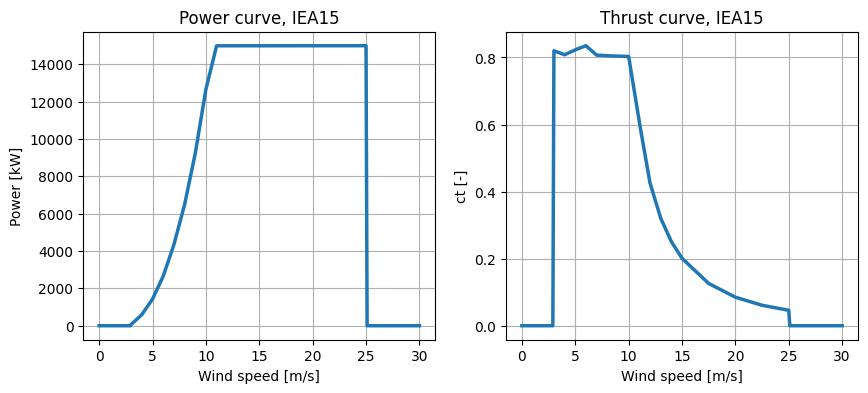

In [156]:
# Add the IEA 15MW power curve to the model book

mbook = foxes.models.ModelBook()
mbook.turbine_types["IEA15"] = foxes.models.turbine_types.PCtFile("turbine-info/power_curves/IEA-15MW-D240-H150.csv")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
o = foxes.output.TurbineTypeCurves(mbook)
o.plot_curves("IEA15", [FV.P, FV.CT], axs=axs)
plt.show()

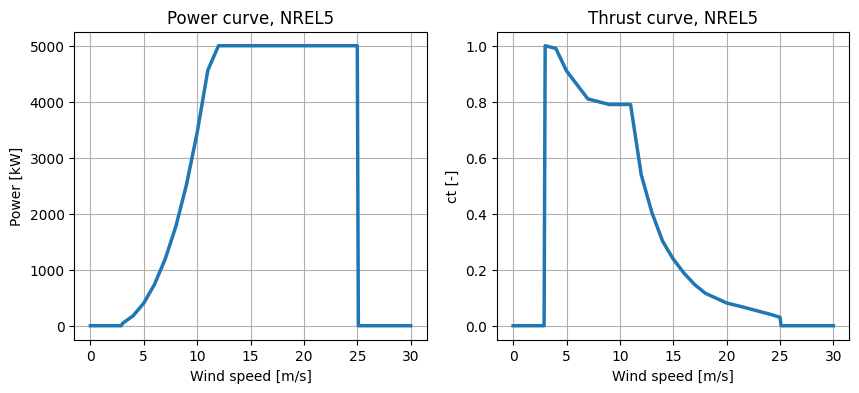

In [157]:
# Add the NREL 5MW power curve to the model book

mbook = foxes.models.ModelBook()
mbook.turbine_types["NREL5"] = foxes.models.turbine_types.PCtFile("turbine-info/power_curves/NREL-5MW-D126-H90.csv")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
o = foxes.output.TurbineTypeCurves(mbook)
o.plot_curves("NREL5", [FV.P, FV.CT], axs=axs)
plt.show()

In [158]:
# Function to print out states, wind rose plot, and calculate power output, mean power, 
# farm power, turbine results, farm power, farm ambient power, farm efficiency, 
# and annual farm yield

def wake_models(farm, corrected_era100, WakeModel):
    # Here creating states: --------------------------------------------------------------------------------------
    states = foxes.input.states.StatesTable(
        data_source=corrected_era100,
        output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
        var2col={FV.WS: "ws100", FV.WD: "wd100"},
        fixed_vars={FV.RHO: 1.225, FV.TI: 0.05},)
    print('States: \n',states.data_source)
    
    # Here the wind rose plot: ------------------------------------------------------------------------------------
    o = foxes.output.StatesRosePlotOutput(states, point=[0., 0., 100.])
    fig = o.get_figure(20, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
    plt.show()
    
    mbook = foxes.ModelBook()
    # Creating algorithm: ------------------------------------------------------------------------------------------
    algo = foxes.algorithms.Downwind(
        farm,
        states,  
        rotor_model="centre",
        wake_frame='rotor_wd',
        partial_wakes='centre',
        wake_models=[WakeModel],
        chunks={FC.STATE: 1000, FC.POINT: 4000},
    )
    
    # Calculation: --------------------------------------------------------------------------------------------------
    farm_results = algo.calc_farm()
    P = farm_results["P"].to_numpy()
    print('Power: \n',P)
    
    weights0 = farm_results["weight"][:, 0] # Here the weights do not depend on the turbine; we pick them from turbine 0
    P_mean = np.einsum('st,s->t', P, weights0)
    print('Mean Power: \n',P_mean)
    
    print(f"Farm power: {np.sum(P_mean)/1000:.1f} MW")
    o = foxes.output.FarmResultsEval(farm_results)
    turbine_results = o.reduce_states({FV.REWS: "mean", FV.P: "mean"})
    print('Turbine results: \n', turbine_results)
    
    P0_mean_farm = o.calc_mean_farm_power(ambient=True)
    P_mean_farm = o.calc_mean_farm_power()
    print(f"\nFarm power      : {P_mean_farm/1000:.1f} MW")
    print(f"Farm ambient power: {P0_mean_farm/1000:.1f} MW")
    print(f"Farm efficiency   : {o.calc_farm_efficiency()*100:.2f} %")
    print(f"Annual farm yield : {o.calc_farm_yield(algo=algo):.2f} GWh")
    p_mean = round(P_mean_farm / 1000, 1)
    p_amb = round(P0_mean_farm/1000, 1)
    effc_farm = round(o.calc_farm_efficiency()*100,2)
    ann_yield_farm = round(o.calc_farm_yield(algo=algo),2)
        
    return farm_results, turbine_results, P_mean, p_mean, p_amb, effc_farm, ann_yield_farm

States: 
                         ws100       wd100
2022-03-03 00:00:00  7.770964  128.065024
2022-03-03 01:00:00  7.269293  129.769493
2022-03-03 02:00:00  7.848122  120.282530
2022-03-03 03:00:00  9.325797  114.574077
2022-03-03 04:00:00  9.287364  120.568951
...                       ...         ...
2023-04-04 00:00:00  5.054970  117.820620
2023-04-04 01:00:00  4.595493  128.862389
2023-04-04 02:00:00  4.070104  139.086736
2023-04-04 03:00:00  3.360304  151.816568
2023-04-04 04:00:00  2.456378  157.056198

[9533 rows x 2 columns]


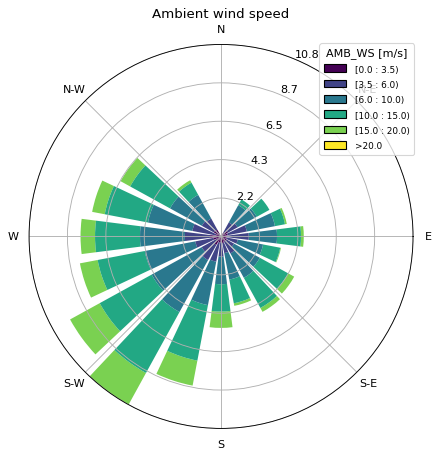


Initializing algorithm 'Downwind'
Initializing model 'Downwind'
Initializing model 'StatesTable13'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'IEA15MW'
Turbine type 'IEA15MW': Reading static data from context 'power_ct_curve'
Path: C:\Users\abdel\AppData\Roaming\Python\Python312\site-packages\foxes\data\power_ct_curves\IEA-15MW-D240-H150.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Initializing model 'Betz'
Initializing model 'Jensen_linear_k004'
Initializing model 'centre'

--------------------------------------------------
  Running Downwind: calc_farm
--------------------------------------------------
  n_states : 9533
  n_turbines: 133
--------------------------------------------------
  states   : StatesTable()
  rotor    : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
--------------------------------------------------
  wakes:
    0) Jensen_linear_k004:

In [159]:
# Jensen linear k004 wake model for area N-9.1
farm_results_jensen_n91 = wake_models(farm_n91, corrected_era5_data_lidar1, 'Jensen_linear_k004')

States: 
                         ws100       wd100
2022-03-03 00:00:00  7.770964  128.065024
2022-03-03 01:00:00  7.269293  129.769493
2022-03-03 02:00:00  7.848122  120.282530
2022-03-03 03:00:00  9.325797  114.574077
2022-03-03 04:00:00  9.287364  120.568951
...                       ...         ...
2023-04-04 00:00:00  5.054970  117.820620
2023-04-04 01:00:00  4.595493  128.862389
2023-04-04 02:00:00  4.070104  139.086736
2023-04-04 03:00:00  3.360304  151.816568
2023-04-04 04:00:00  2.456378  157.056198

[9533 rows x 2 columns]


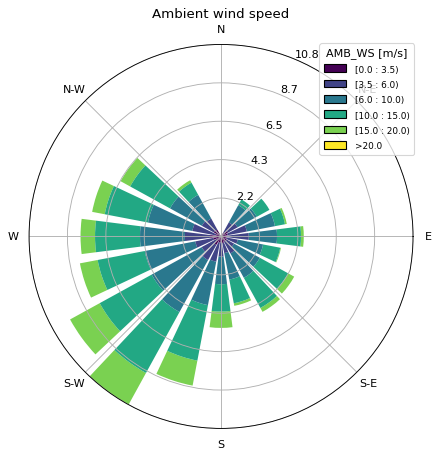


Initializing algorithm 'Downwind'
Initializing model 'Downwind'
Initializing model 'StatesTable14'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'IEA15MW'
Turbine type 'IEA15MW': Reading static data from context 'power_ct_curve'
Path: C:\Users\abdel\AppData\Roaming\Python\Python312\site-packages\foxes\data\power_ct_curves\IEA-15MW-D240-H150.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Initializing model 'Madsen'
Initializing model 'Bastankhah2014_linear_k004'
Initializing model 'centre'

--------------------------------------------------
  Running Downwind: calc_farm
--------------------------------------------------
  n_states : 9533
  n_turbines: 133
--------------------------------------------------
  states   : StatesTable()
  rotor    : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
--------------------------------------------------
  wakes:
    0) Bastankha

In [160]:
# Bastankhah 2014 linear k004 wake model for area N-9.1
farm_results_bastankhah_n91 = wake_models(farm_n91, corrected_era5_data_lidar1, 'Bastankhah2014_linear_k004')

States: 
                         ws100       wd100
2022-03-03 00:00:00  7.770964  128.065024
2022-03-03 01:00:00  7.269293  129.769493
2022-03-03 02:00:00  7.848122  120.282530
2022-03-03 03:00:00  9.325797  114.574077
2022-03-03 04:00:00  9.287364  120.568951
...                       ...         ...
2023-04-04 00:00:00  5.054970  117.820620
2023-04-04 01:00:00  4.595493  128.862389
2023-04-04 02:00:00  4.070104  139.086736
2023-04-04 03:00:00  3.360304  151.816568
2023-04-04 04:00:00  2.456378  157.056198

[9533 rows x 2 columns]


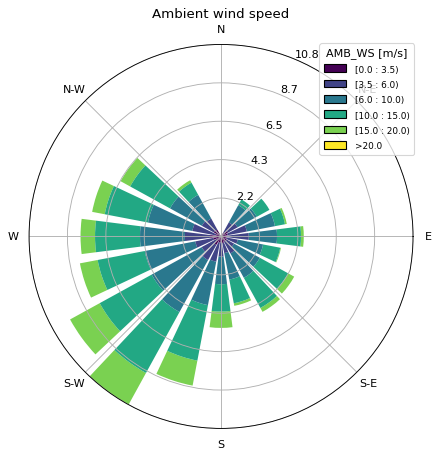


Initializing algorithm 'Downwind'
Initializing model 'Downwind'
Initializing model 'StatesTable15'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'IEA15MW'
Turbine type 'IEA15MW': Reading static data from context 'power_ct_curve'
Path: C:\Users\abdel\AppData\Roaming\Python\Python312\site-packages\foxes\data\power_ct_curves\IEA-15MW-D240-H150.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Initializing model 'Madsen'
Initializing model 'TurbOPark_linear_k004'
Initializing model 'centre'

--------------------------------------------------
  Running Downwind: calc_farm
--------------------------------------------------
  n_states : 9533
  n_turbines: 133
--------------------------------------------------
  states   : StatesTable()
  rotor    : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
--------------------------------------------------
  wakes:
    0) TurbOPark_line

In [161]:
# Turbo Park Linear k004 wake model for area N-9.1
farm_results_turbopark_n91 = wake_models(farm_n91, corrected_era5_data_lidar1, 'TurbOPark_linear_k004')

States: 
                         ws100       wd100
2022-03-03 00:00:00  7.770964  128.065024
2022-03-03 01:00:00  7.269293  129.769493
2022-03-03 02:00:00  7.848122  120.282530
2022-03-03 03:00:00  9.325797  114.574077
2022-03-03 04:00:00  9.287364  120.568951
...                       ...         ...
2023-04-04 00:00:00  5.054970  117.820620
2023-04-04 01:00:00  4.595493  128.862389
2023-04-04 02:00:00  4.070104  139.086736
2023-04-04 03:00:00  3.360304  151.816568
2023-04-04 04:00:00  2.456378  157.056198

[9533 rows x 2 columns]


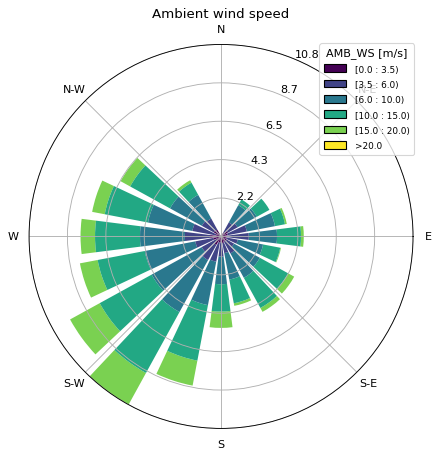


Initializing algorithm 'Downwind'
Initializing model 'Downwind'
Initializing model 'StatesTable16'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'IEA15MW'
Turbine type 'IEA15MW': Reading static data from context 'power_ct_curve'
Path: C:\Users\abdel\AppData\Roaming\Python\Python312\site-packages\foxes\data\power_ct_curves\IEA-15MW-D240-H150.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Initializing model 'Betz'
Initializing model 'Jensen_linear_k004'
Initializing model 'centre'

--------------------------------------------------
  Running Downwind: calc_farm
--------------------------------------------------
  n_states : 9533
  n_turbines: 133
--------------------------------------------------
  states   : StatesTable()
  rotor    : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
--------------------------------------------------
  wakes:
    0) Jensen_linear_k004:

In [162]:
# Jensen linear k004 wake model for area N-9.2
farm_results_jensen_n92 = wake_models(farm_n92, corrected_era5_data_lidar1, 'Jensen_linear_k004')

States: 
                         ws100       wd100
2022-03-03 00:00:00  7.770964  128.065024
2022-03-03 01:00:00  7.269293  129.769493
2022-03-03 02:00:00  7.848122  120.282530
2022-03-03 03:00:00  9.325797  114.574077
2022-03-03 04:00:00  9.287364  120.568951
...                       ...         ...
2023-04-04 00:00:00  5.054970  117.820620
2023-04-04 01:00:00  4.595493  128.862389
2023-04-04 02:00:00  4.070104  139.086736
2023-04-04 03:00:00  3.360304  151.816568
2023-04-04 04:00:00  2.456378  157.056198

[9533 rows x 2 columns]


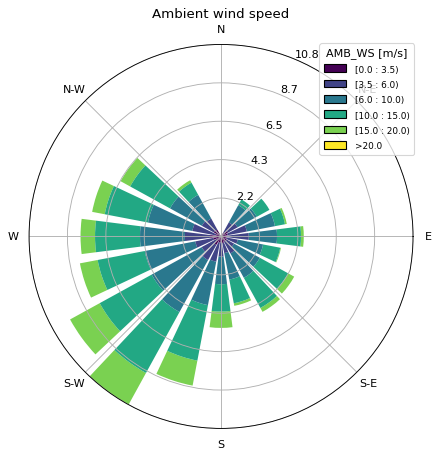


Initializing algorithm 'Downwind'
Initializing model 'Downwind'
Initializing model 'StatesTable17'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'IEA15MW'
Turbine type 'IEA15MW': Reading static data from context 'power_ct_curve'
Path: C:\Users\abdel\AppData\Roaming\Python\Python312\site-packages\foxes\data\power_ct_curves\IEA-15MW-D240-H150.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Initializing model 'Madsen'
Initializing model 'Bastankhah2014_linear_k004'
Initializing model 'centre'

--------------------------------------------------
  Running Downwind: calc_farm
--------------------------------------------------
  n_states : 9533
  n_turbines: 133
--------------------------------------------------
  states   : StatesTable()
  rotor    : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
--------------------------------------------------
  wakes:
    0) Bastankha

In [163]:
# Bastankhah 2014 linear k004 wake model for area N-9.2
farm_results_bastankhah_n92 = wake_models(farm_n92, corrected_era5_data_lidar1, 'Bastankhah2014_linear_k004')

States: 
                         ws100       wd100
2022-03-03 00:00:00  7.770964  128.065024
2022-03-03 01:00:00  7.269293  129.769493
2022-03-03 02:00:00  7.848122  120.282530
2022-03-03 03:00:00  9.325797  114.574077
2022-03-03 04:00:00  9.287364  120.568951
...                       ...         ...
2023-04-04 00:00:00  5.054970  117.820620
2023-04-04 01:00:00  4.595493  128.862389
2023-04-04 02:00:00  4.070104  139.086736
2023-04-04 03:00:00  3.360304  151.816568
2023-04-04 04:00:00  2.456378  157.056198

[9533 rows x 2 columns]


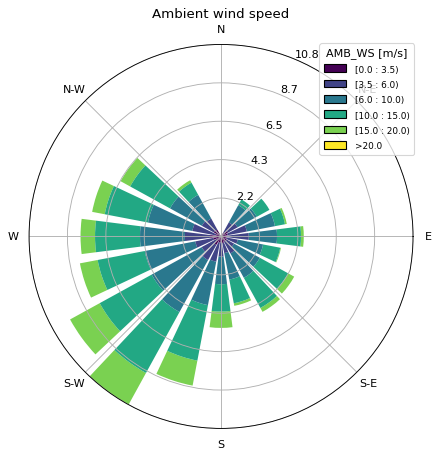


Initializing algorithm 'Downwind'
Initializing model 'Downwind'
Initializing model 'StatesTable18'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'IEA15MW'
Turbine type 'IEA15MW': Reading static data from context 'power_ct_curve'
Path: C:\Users\abdel\AppData\Roaming\Python\Python312\site-packages\foxes\data\power_ct_curves\IEA-15MW-D240-H150.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Initializing model 'Madsen'
Initializing model 'TurbOPark_linear_k004'
Initializing model 'centre'

--------------------------------------------------
  Running Downwind: calc_farm
--------------------------------------------------
  n_states : 9533
  n_turbines: 133
--------------------------------------------------
  states   : StatesTable()
  rotor    : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
--------------------------------------------------
  wakes:
    0) TurbOPark_line

In [164]:
# Turbo Park Linear k004 wake model for area N-9.2
farm_results_turbopark_n92 = wake_models(farm_n92, corrected_era5_data_lidar1, 'TurbOPark_linear_k004')

States: 
                         ws100       wd100
2022-03-03 00:00:00  7.770964  128.065024
2022-03-03 01:00:00  7.269293  129.769493
2022-03-03 02:00:00  7.848122  120.282530
2022-03-03 03:00:00  9.325797  114.574077
2022-03-03 04:00:00  9.287364  120.568951
...                       ...         ...
2023-04-04 00:00:00  5.054970  117.820620
2023-04-04 01:00:00  4.595493  128.862389
2023-04-04 02:00:00  4.070104  139.086736
2023-04-04 03:00:00  3.360304  151.816568
2023-04-04 04:00:00  2.456378  157.056198

[9533 rows x 2 columns]


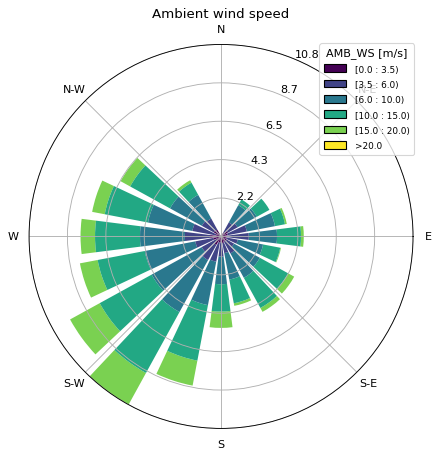


Initializing algorithm 'Downwind'
Initializing model 'Downwind'
Initializing model 'StatesTable19'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'IEA15MW'
Turbine type 'IEA15MW': Reading static data from context 'power_ct_curve'
Path: C:\Users\abdel\AppData\Roaming\Python\Python312\site-packages\foxes\data\power_ct_curves\IEA-15MW-D240-H150.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Initializing model 'Betz'
Initializing model 'Jensen_linear_k004'
Initializing model 'centre'

--------------------------------------------------
  Running Downwind: calc_farm
--------------------------------------------------
  n_states : 9533
  n_turbines: 100
--------------------------------------------------
  states   : StatesTable()
  rotor    : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
--------------------------------------------------
  wakes:
    0) Jensen_linear_k004:

In [165]:
# Jensen linear k004 wake model for area N-9.3
farm_results_jensen_n93 = wake_models(farm_n93, corrected_era5_data_lidar1, 'Jensen_linear_k004')

States: 
                         ws100       wd100
2022-03-03 00:00:00  7.770964  128.065024
2022-03-03 01:00:00  7.269293  129.769493
2022-03-03 02:00:00  7.848122  120.282530
2022-03-03 03:00:00  9.325797  114.574077
2022-03-03 04:00:00  9.287364  120.568951
...                       ...         ...
2023-04-04 00:00:00  5.054970  117.820620
2023-04-04 01:00:00  4.595493  128.862389
2023-04-04 02:00:00  4.070104  139.086736
2023-04-04 03:00:00  3.360304  151.816568
2023-04-04 04:00:00  2.456378  157.056198

[9533 rows x 2 columns]


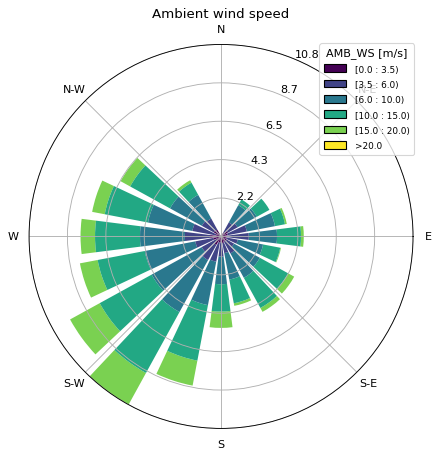


Initializing algorithm 'Downwind'
Initializing model 'Downwind'
Initializing model 'StatesTable20'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'IEA15MW'
Turbine type 'IEA15MW': Reading static data from context 'power_ct_curve'
Path: C:\Users\abdel\AppData\Roaming\Python\Python312\site-packages\foxes\data\power_ct_curves\IEA-15MW-D240-H150.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Initializing model 'Madsen'
Initializing model 'Bastankhah2014_linear_k004'
Initializing model 'centre'

--------------------------------------------------
  Running Downwind: calc_farm
--------------------------------------------------
  n_states : 9533
  n_turbines: 100
--------------------------------------------------
  states   : StatesTable()
  rotor    : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
--------------------------------------------------
  wakes:
    0) Bastankha

In [166]:
# Bastankhah 2014 linear k004 wake model for area N-9.3
farm_results_bastankhah_n93 = wake_models(farm_n93, corrected_era5_data_lidar1, 'Bastankhah2014_linear_k004')

States: 
                         ws100       wd100
2022-03-03 00:00:00  7.770964  128.065024
2022-03-03 01:00:00  7.269293  129.769493
2022-03-03 02:00:00  7.848122  120.282530
2022-03-03 03:00:00  9.325797  114.574077
2022-03-03 04:00:00  9.287364  120.568951
...                       ...         ...
2023-04-04 00:00:00  5.054970  117.820620
2023-04-04 01:00:00  4.595493  128.862389
2023-04-04 02:00:00  4.070104  139.086736
2023-04-04 03:00:00  3.360304  151.816568
2023-04-04 04:00:00  2.456378  157.056198

[9533 rows x 2 columns]


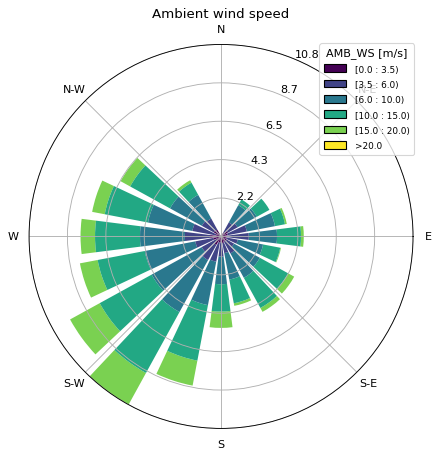


Initializing algorithm 'Downwind'
Initializing model 'Downwind'
Initializing model 'StatesTable21'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'IEA15MW'
Turbine type 'IEA15MW': Reading static data from context 'power_ct_curve'
Path: C:\Users\abdel\AppData\Roaming\Python\Python312\site-packages\foxes\data\power_ct_curves\IEA-15MW-D240-H150.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Initializing model 'Madsen'
Initializing model 'TurbOPark_linear_k004'
Initializing model 'centre'

--------------------------------------------------
  Running Downwind: calc_farm
--------------------------------------------------
  n_states : 9533
  n_turbines: 100
--------------------------------------------------
  states   : StatesTable()
  rotor    : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
--------------------------------------------------
  wakes:
    0) TurbOPark_line

In [167]:
# Turbo Park Linear k004 wake model for area N-9.3
farm_results_turbopark_n93 = wake_models(farm_n93, corrected_era5_data_lidar1, 'TurbOPark_linear_k004')

In [168]:
# show the results test 
print(farm_results_bastankhah_n91[1]['P'])

# min
print('\n', farm_results_bastankhah_n91[1]['P'].min())

# max
print('\n', farm_results_bastankhah_n91[1]['P'].max())

turbine
0      7265.999886
1      7486.307302
2      8059.543190
3      7554.961873
4      7524.046976
          ...     
128    8002.379384
129    7807.044454
130    7654.395208
131    7488.489867
132    7300.630067
Name: P, Length: 133, dtype: float64

 7245.631543461553

 8695.839341072213


In [169]:
def compare_models(farm_results_jensen, farm_results_bastankhah, farm_results_turbopark, layout, area):
    
    # Plot the comparison of the models
    fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(20, 20))
    
    # make same max and min for all
    vmin = min(farm_results_jensen[1]['P'].min(), farm_results_bastankhah[1]['P'].min(), farm_results_turbopark[1]['P'].min())
    vmax = max(farm_results_jensen[1]['P'].max(), farm_results_bastankhah[1]['P'].max(), farm_results_turbopark[1]['P'].max())
    
    # Create the first scatter plot in the first subplot
    scatter1 = ax1.scatter(area['x'], area['y'], c=farm_results_jensen[1]['P'], vmin=vmin, vmax=vmax, s=100, alpha=0.5, cmap='viridis')
    colorbar1 = fig.colorbar(scatter1, ax=ax1)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title(f'Generated Power of layout {layout} with wake model "Jensen_linear_k004"')

    # Create the second scatter plot in the second subplot
    scatter2 = ax2.scatter(area['x'], area['y'], c=farm_results_bastankhah[1]['P'], vmin=vmin, vmax=vmax, s=100, alpha=0.5, cmap='viridis')
    colorbar2 = fig.colorbar(scatter2, ax=ax2)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title(f'Generated Power of layout {layout} with wake model "Bastankhah2014_linear_k004"')

    # Create the third scatter plot in the second subplot
    scatter3 = ax3.scatter(area['x'], area['y'], c=farm_results_turbopark[1]['P'], vmin=vmin, vmax=vmax, s=100, alpha=0.5, cmap='viridis')
    colorbar3 = fig.colorbar(scatter3, ax=ax3)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_title(f'Generated Power of layout {layout} with wake model "TurbOPark_linear_k004"')
        
    return

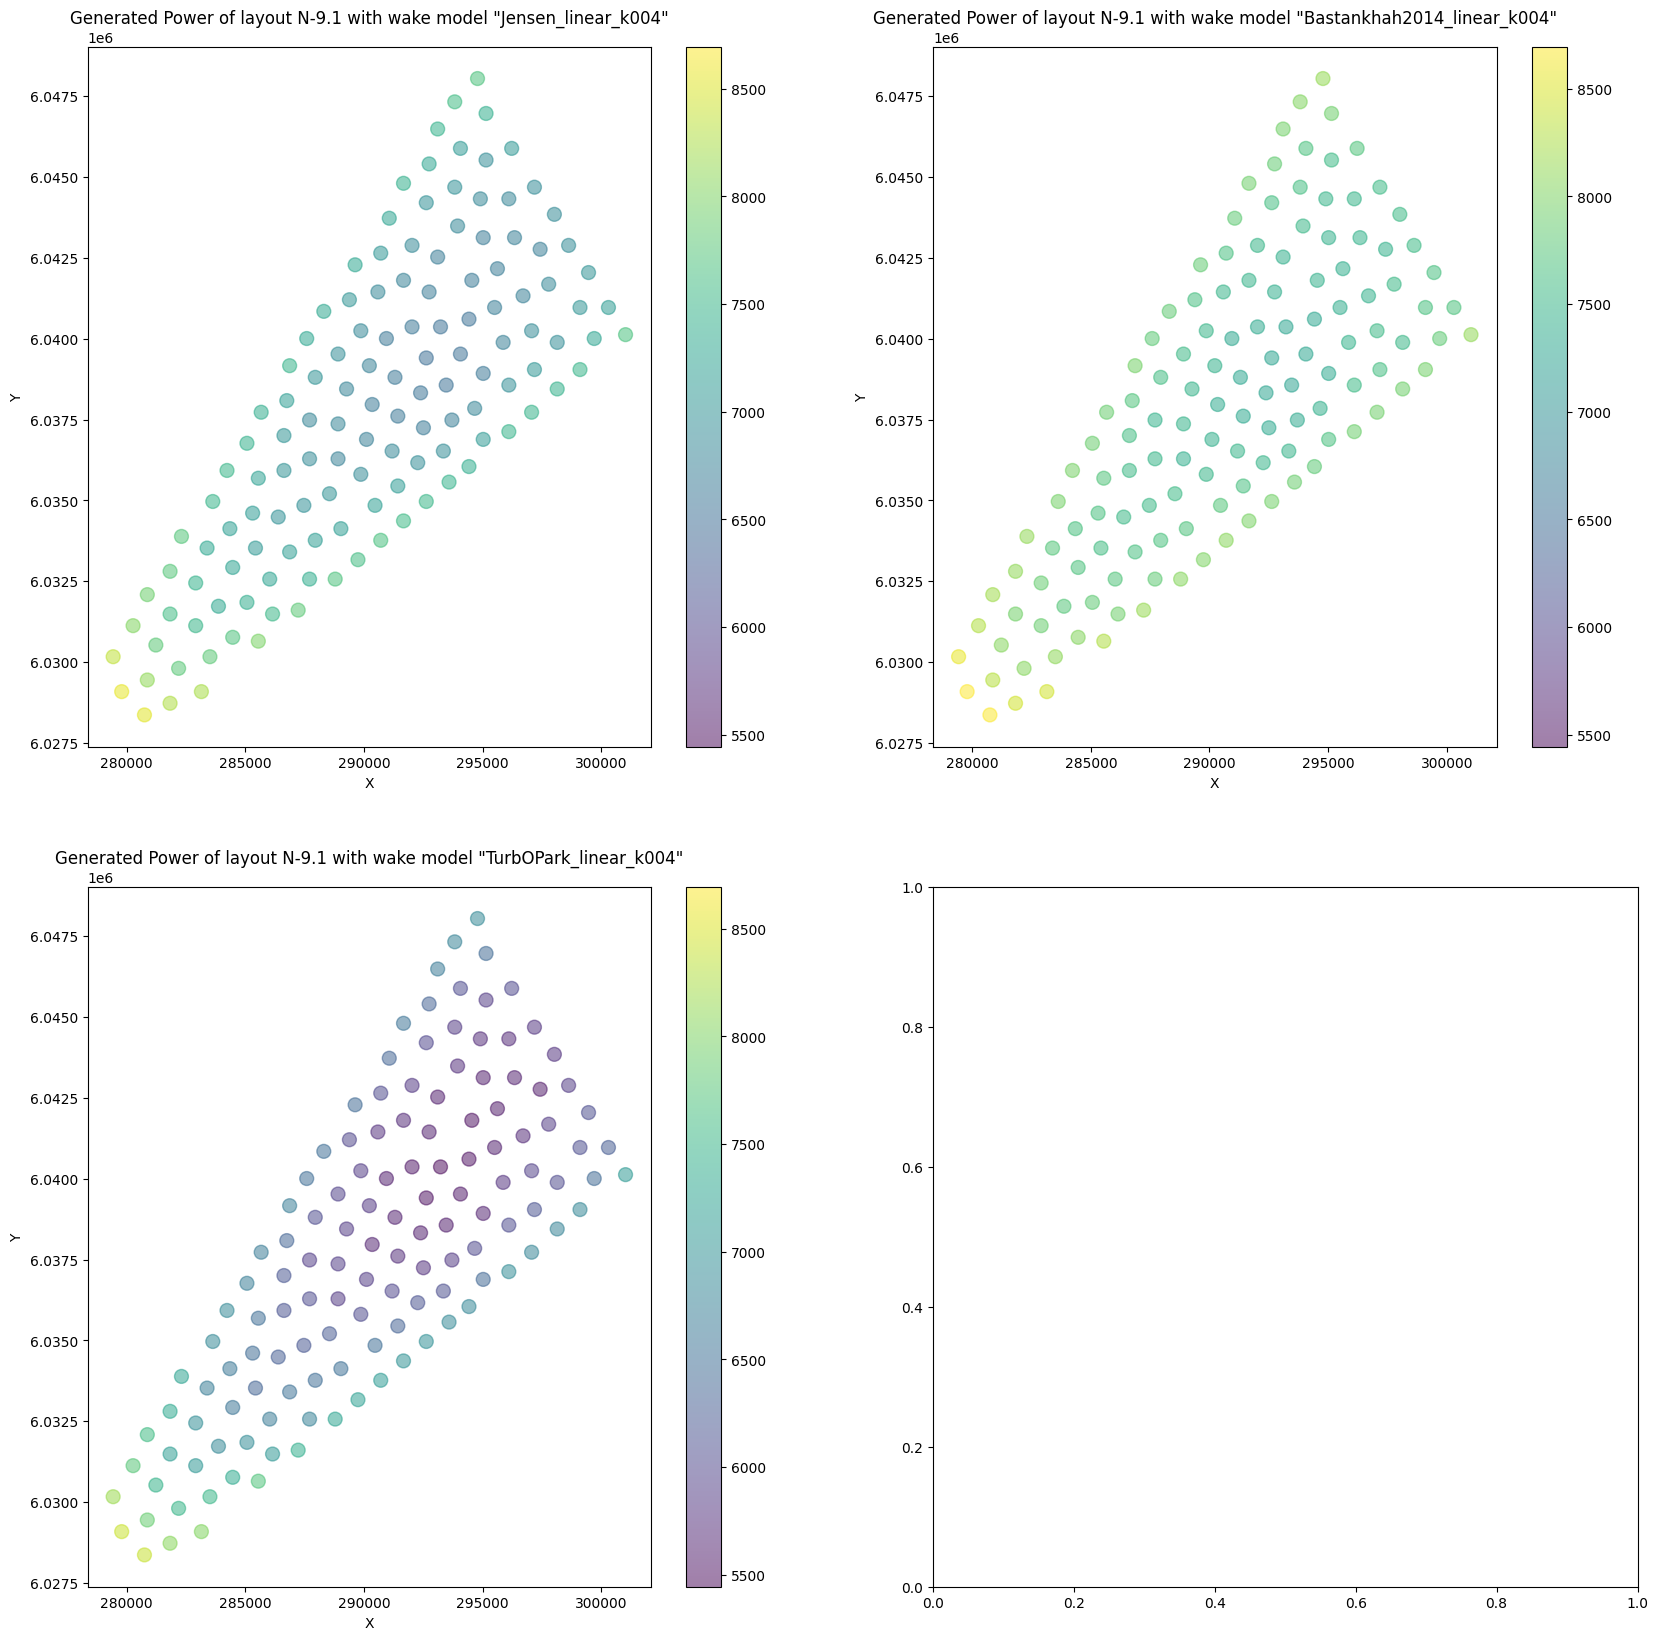

In [170]:
# Comparison of the models for area N-9.1
compare_models(farm_results_jensen_n91, farm_results_bastankhah_n91, farm_results_turbopark_n91, 'N-9.1', area_n91)

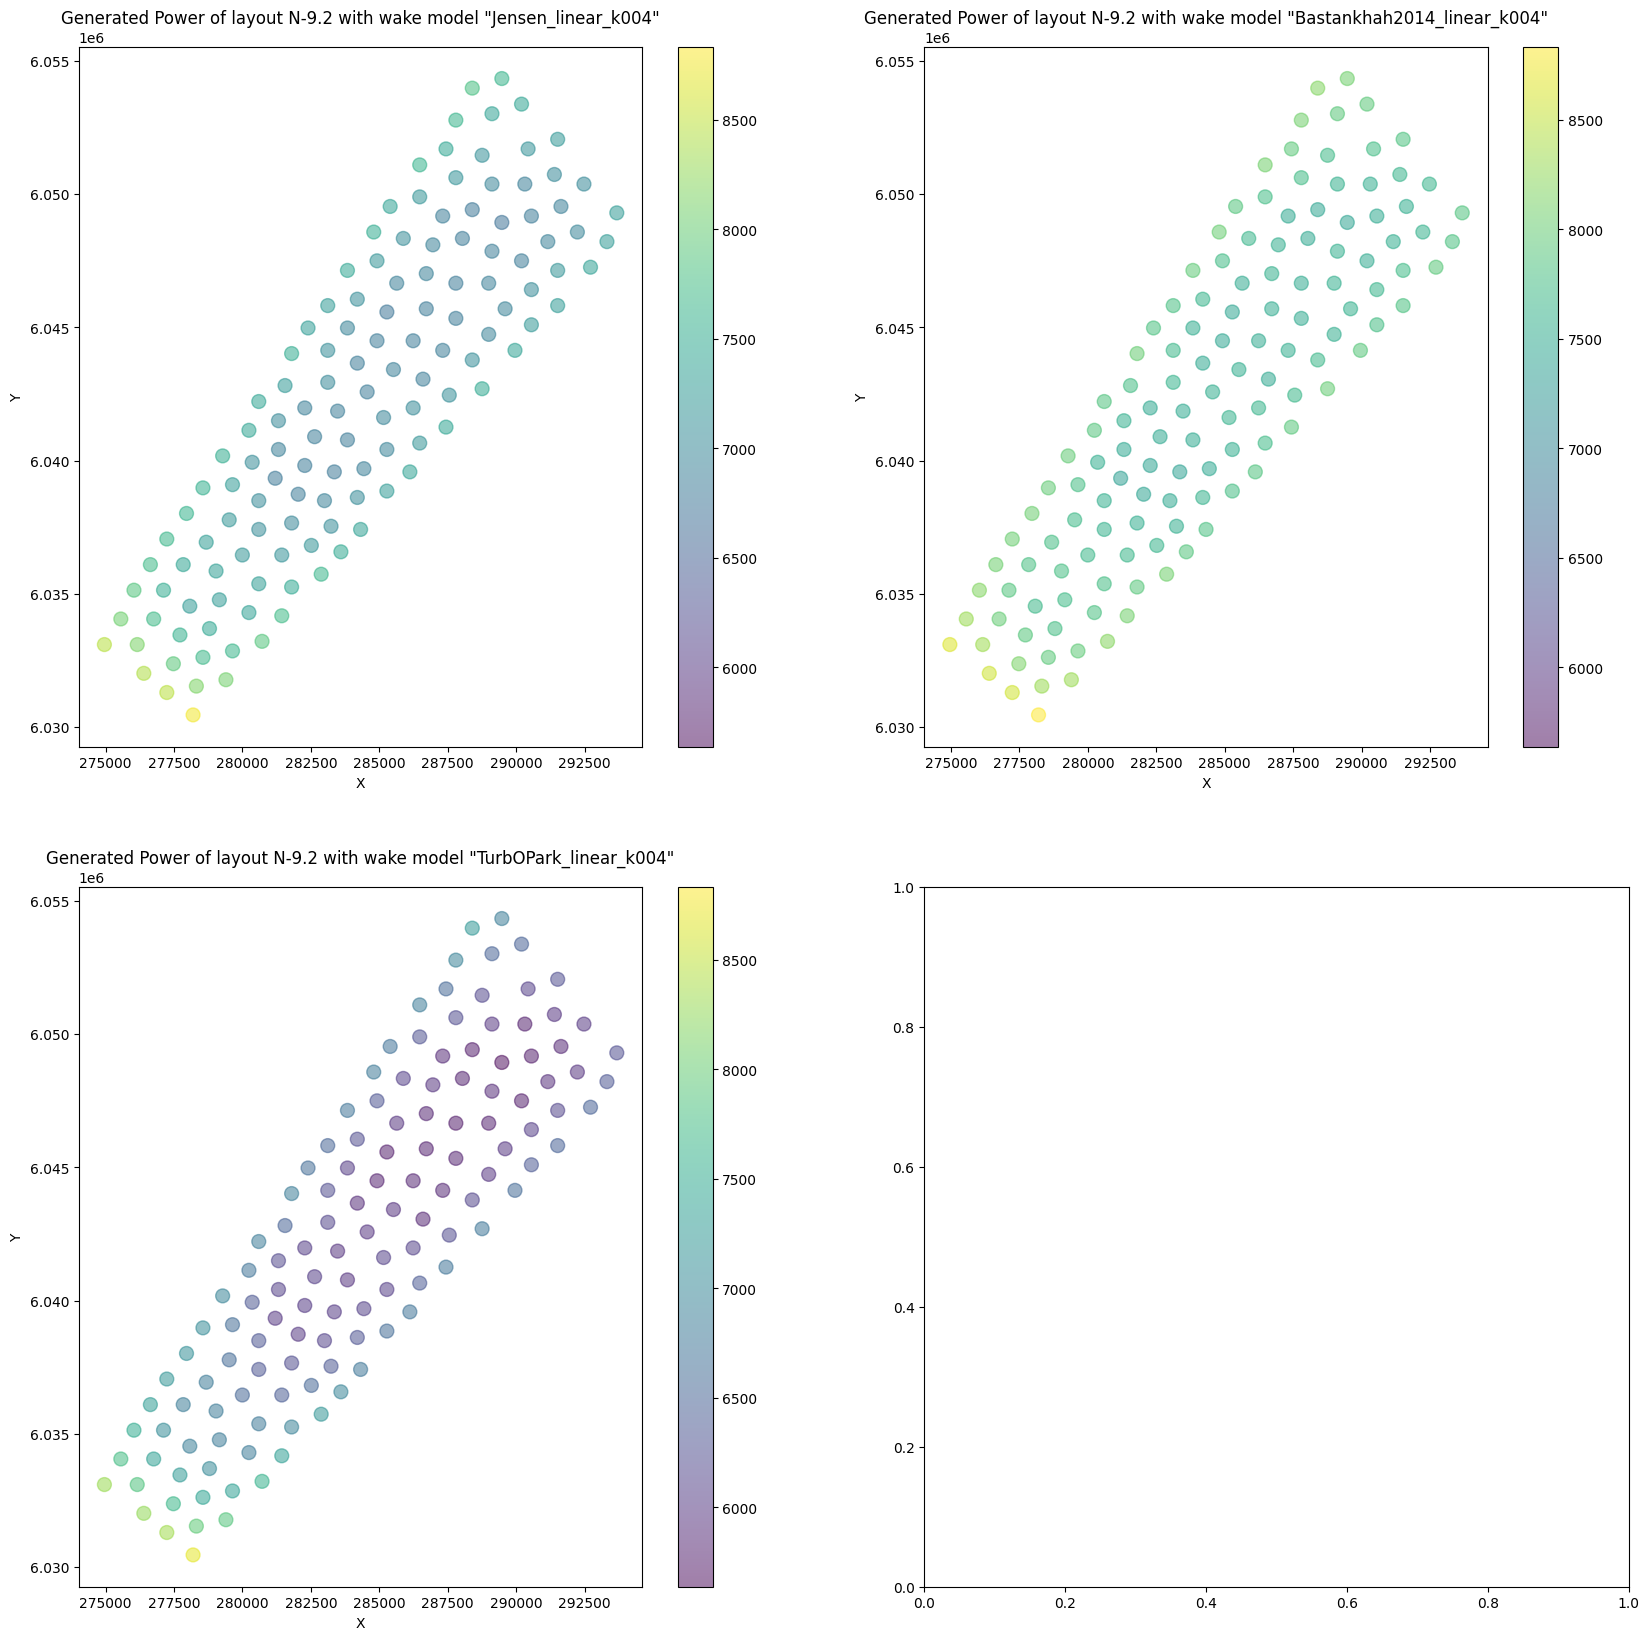

In [171]:
# Comparison of the models for area N-9.2
compare_models(farm_results_jensen_n92, farm_results_bastankhah_n92, farm_results_turbopark_n92, 'N-9.2', area_n92)

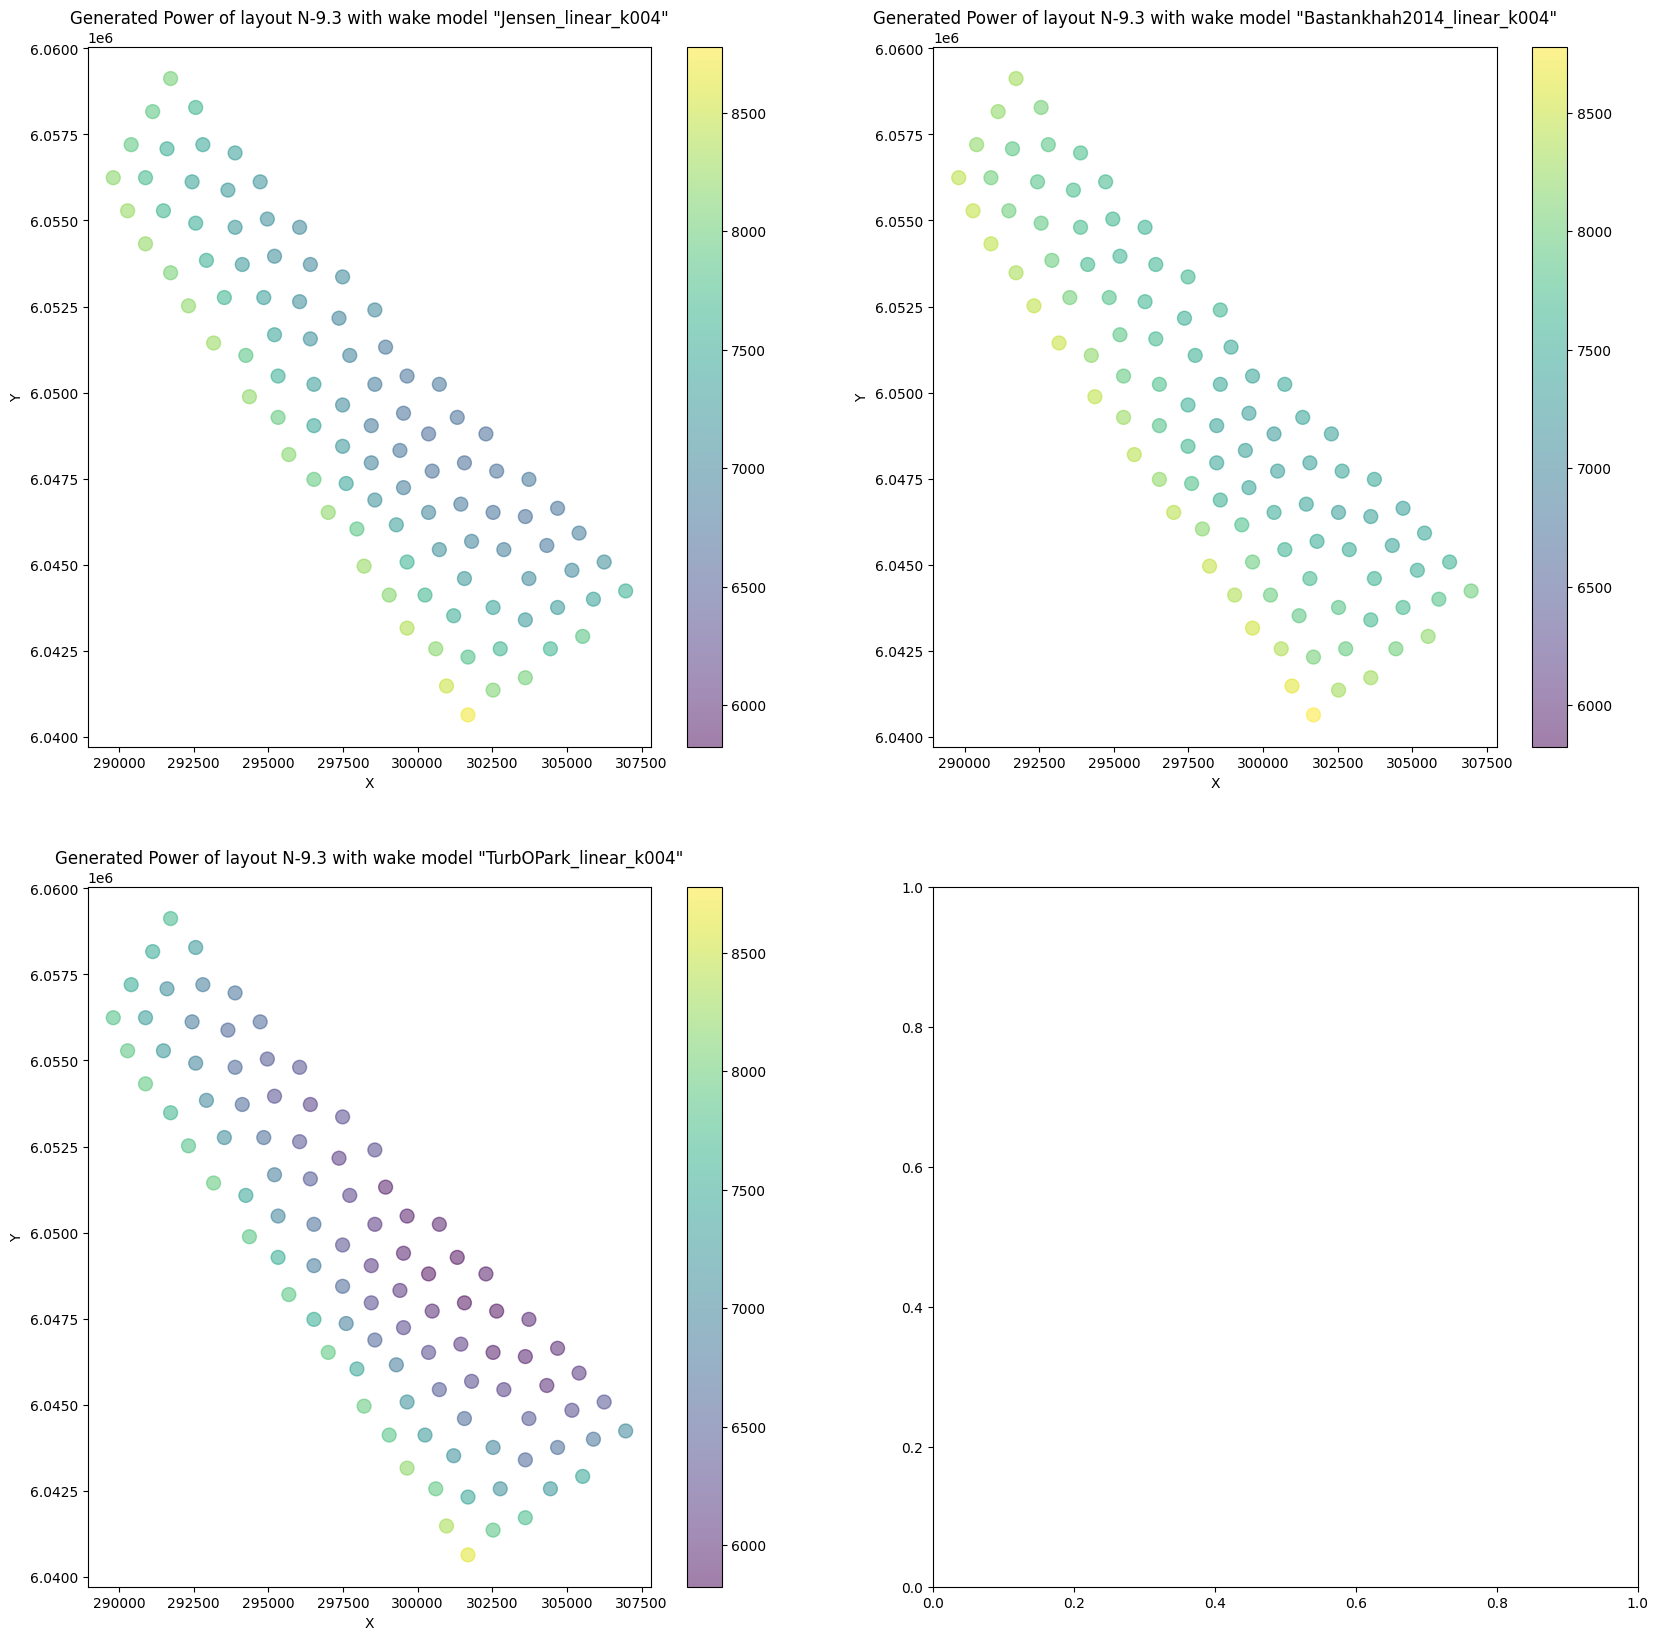

In [172]:
# Comparison of the models for area N-9.3
compare_models(farm_results_jensen_n93, farm_results_bastankhah_n93, farm_results_turbopark_n93, 'N-9.3', area_n93)